# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin


- There are many times where you want to extract imporant features from high-dimensional data


- In essence, the goal is to compress data to some lower latent space where you can extract information


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/3-swissroll-unfolded.png?raw=true)


## Autoencoder

![imag](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder.png?raw=true)


- **Encoder** - Neural network that deconstructs the data into the most important statistical components


- **Embedding Layer(s)** - One or many layers were information is extracted


- **Decoder** - Neural network that translates the latent space to original dimensionality.


### Mathematical Objective


- Minimize the reconstruction loss based on some metric.
  - Mean squared error


- Good at avoiding influence of anomalies
  - Mean absolute error


- Good at capturing details within spectra


### Optimizers


- Standard optimizers like ADAM tend to be sufficient


- Can use more complex optimizers 2nd order, adhessian to optimize small models.


### Practical Objective


- Create an autoencoder that has performant reconstruction


- Create a low-dimensional and interpretable latent space
  - Reduce the dimensionality
  - Impose non-negativity contraints
  - Impose regularization
  - Impose sparsity
  - Impose constraints on the shape of the latent distribution
  - Impose soft-constraints that favor disentanglement


- Create a latent trajectory that is suitable for generation


# Imports Packages


In [1]:
# installs the tutorial package
!pip install m3_learning --no-deps
!pip install scikit-learn
!pip install wget
!pip install hyperspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f12b572d2e3dc3293ddc095721c5186586f77bcff5cbcbafa232cb12da924d7c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
m3-learning 0.0.24 requires autopep8, which is not installed.
m3-learning 0.0.24 requires BGlib, which is not installed.
m3-learning 0.0.24 requires datafed, which is not installed.
m3-learning 0.0.24 requires hyperspy, which is not installed.
m3-learning 0.0.24 requires jupyter, which is not installed.
m3-learning 0.0.24 requires jupyter-book, which is not installed.
m3-learning 0.0.24 requires pycroscopy, which is not instal

In [3]:
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import inspect

from m3_learning.util.code import print_code


from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function
from m3_learning.viz.layout import layout_fig, embedding_maps
from m3_learning.util.data_generators import generate_data

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

set_style("default")
random_seed(seed=42)

default set for seaborn
default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


# Generating Data


- We want to generate a hyperspectral image


- This can be done by taking the RGB values of an image and using them as parameters for a function


## Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [4]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image


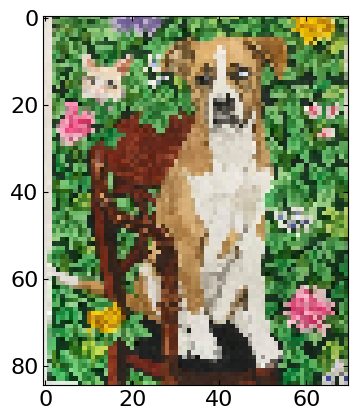

In [5]:
# Plots dog image
plt.imshow(image)


## Generating some data based on the image

### Define a non-linear function


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/generated.png?raw=true)


In [6]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [7]:
print_code(generate_data)

24: def generate_data(values, function=default_nl_function, length=25, range_=[-1, 1]):
25:   """function to generate data based on an arbitrary function
26: 
27:   Args:
28:       values (array): Input values to use
29:       function (obj, optional): Function to use for generation. Defaults to default_nl_function.
30:       length (int, optional): length of the vector to generate. Defaults to 25.
31:       range_ (list, optional): range of spectra where you generate data. Defaults to [-1, 1].
32: 
33:   Returns:
34:       array: computed spectra
35:   """
36:   # build x vector
37:   x = np.linspace(range_[0], range_[1], length)
38: 
39:   data = np.zeros((values.shape[0], length))
40: 
41:   for i in range(values.shape[0]):
42:       data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])
43: 
44:   return data
45: 


In [8]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3),
                         length=10, function=non_linear_fn)


In [9]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data


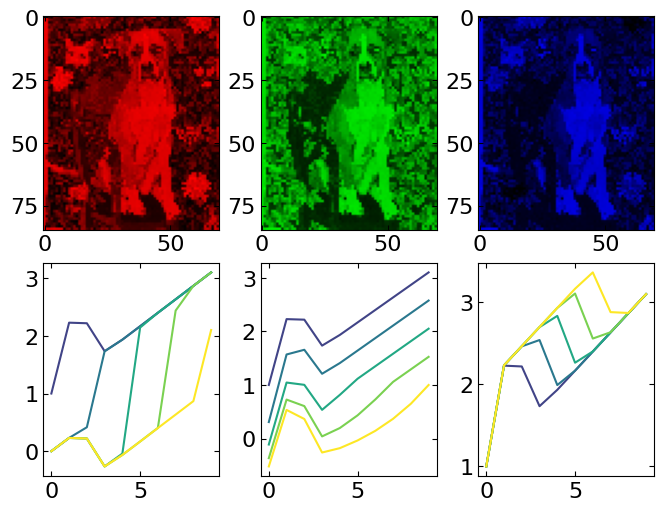

In [10]:
fig, ax = layout_fig(6, mod=3, figsize=(10, 5))

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    # for the first three plots we plot the image
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        # for the last three plots we plot the hyperspectral image
        values = np.zeros((5, 3))

        # generates 5 linearly spaced values between 0 and 1
        values[:, i - 3] = np.linspace(0, 1, 5)

        # generates the spectra
        y_data = generate_data(values, length=10)

        for j in range(y_data.shape[0]):

            # computes the colormap for each spectra based on the value
            color = cmap((j + 1) / y_data.shape[0])

            # plots the data
            ax.plot(y_data[j], c=color)


## Building a Simple Autoencoder


### Defines the encoder and the decoder


In [11]:
# sets the number of latent dimensions for the autoencoder
latent_dim = 12


class Encoder(nn.Module):
    """Encoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    """Decoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


### Builds the autoencoder


In [12]:
class Autoencoder(nn.Module):
    """
    Autoencoder class that combines the encoder and decoder
    """

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


### Instantiates the model


In [13]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

# choose a device based on your system
if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

# builds the encode, decoder, and autoencoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [14]:
# prints the model structure

try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 12 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


### Builds the dataloader


In [15]:

# builds a dataloader
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [16]:
print_code(Train)

201: def Train(
202:     model,
203:     encoder,
204:     decoder,
205:     train_iterator,
206:     optimizer,
207:     epochs,
208:     coef=0,
209:     coef_1=0,
210:     ln_parm=1,
211:     beta=None,
212:     mse=True,
213:     device="cuda",
214:     save_weight = False,
215: ):
216:     """Function that trains the model
217: 
218:     Args:
219:         model (Pytorch model): autoencoder model
220:         encoder (PyTorch model): encoder of the mode
221:         decoder (PyTorch model): decoder of the model
222:         train_iterator (iter): iterator used from straining
223:         optimizer (obj): optimization methods used
224:         epochs (int): number of epochs
225:         coef (int, optional): used to set the lambda value of the regularization. Defaults to 0.
226:         coef1 (int, optional): not implemented. Defaults to 0.
227:         ln_parm (int, optional): norm value. Defaults to 1.
228:         beta (float, optional): beta for variational autoencoder. Default

In [17]:
# fixes the seed
random_seed(seed=42)

# trains the model
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 44.21it/s]


Epoch 0, Train Loss: 2.0557
.............................


100%|██████████| 19/19 [00:00<00:00, 336.17it/s]


Epoch 1, Train Loss: 1.8709
.............................


100%|██████████| 19/19 [00:00<00:00, 401.88it/s]


Epoch 2, Train Loss: 1.7014
.............................


100%|██████████| 19/19 [00:00<00:00, 436.24it/s]


Epoch 3, Train Loss: 1.5465
.............................


100%|██████████| 19/19 [00:00<00:00, 447.42it/s]


Epoch 4, Train Loss: 1.3983
.............................


100%|██████████| 19/19 [00:00<00:00, 448.84it/s]


Epoch 5, Train Loss: 1.2586
.............................


100%|██████████| 19/19 [00:00<00:00, 447.85it/s]


Epoch 6, Train Loss: 1.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 398.71it/s]


Epoch 7, Train Loss: 1.0058
.............................


100%|██████████| 19/19 [00:00<00:00, 433.85it/s]


Epoch 8, Train Loss: 0.8919
.............................


100%|██████████| 19/19 [00:00<00:00, 434.84it/s]


Epoch 9, Train Loss: 0.7870
.............................


100%|██████████| 19/19 [00:00<00:00, 417.18it/s]


Epoch 10, Train Loss: 0.6910
.............................


100%|██████████| 19/19 [00:00<00:00, 435.36it/s]


Epoch 11, Train Loss: 0.6044
.............................


100%|██████████| 19/19 [00:00<00:00, 437.32it/s]


Epoch 12, Train Loss: 0.5278
.............................


100%|██████████| 19/19 [00:00<00:00, 453.60it/s]


Epoch 13, Train Loss: 0.4611
.............................


100%|██████████| 19/19 [00:00<00:00, 437.73it/s]


Epoch 14, Train Loss: 0.4038
.............................


100%|██████████| 19/19 [00:00<00:00, 451.83it/s]


Epoch 15, Train Loss: 0.3553
.............................


100%|██████████| 19/19 [00:00<00:00, 397.94it/s]


Epoch 16, Train Loss: 0.3155
.............................


100%|██████████| 19/19 [00:00<00:00, 438.80it/s]


Epoch 17, Train Loss: 0.2828
.............................


100%|██████████| 19/19 [00:00<00:00, 443.09it/s]


Epoch 18, Train Loss: 0.2565
.............................


100%|██████████| 19/19 [00:00<00:00, 450.45it/s]


Epoch 19, Train Loss: 0.2355
.............................


100%|██████████| 19/19 [00:00<00:00, 440.48it/s]


Epoch 20, Train Loss: 0.2191
.............................


100%|██████████| 19/19 [00:00<00:00, 450.64it/s]


Epoch 21, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 454.12it/s]


Epoch 22, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 325.77it/s]


Epoch 23, Train Loss: 0.1857
.............................


100%|██████████| 19/19 [00:00<00:00, 453.50it/s]


Epoch 24, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 452.84it/s]


Epoch 25, Train Loss: 0.1714
.............................


100%|██████████| 19/19 [00:00<00:00, 420.51it/s]


Epoch 26, Train Loss: 0.1664
.............................


100%|██████████| 19/19 [00:00<00:00, 445.60it/s]


Epoch 27, Train Loss: 0.1614
.............................


100%|██████████| 19/19 [00:00<00:00, 433.58it/s]


Epoch 28, Train Loss: 0.1573
.............................


100%|██████████| 19/19 [00:00<00:00, 436.03it/s]


Epoch 29, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 410.49it/s]


Epoch 30, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 440.74it/s]


Epoch 31, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 442.88it/s]


Epoch 32, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 449.05it/s]


Epoch 33, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 433.14it/s]


Epoch 34, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 419.79it/s]


Epoch 35, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 414.42it/s]


Epoch 36, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 442.46it/s]


Epoch 37, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 407.33it/s]


Epoch 38, Train Loss: 0.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 404.93it/s]


Epoch 39, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 412.98it/s]


Epoch 40, Train Loss: 0.1245
.............................


100%|██████████| 19/19 [00:00<00:00, 445.30it/s]


Epoch 41, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 437.36it/s]


Epoch 42, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 440.59it/s]


Epoch 43, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 312.43it/s]


Epoch 44, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 427.31it/s]


Epoch 45, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 437.98it/s]


Epoch 46, Train Loss: 0.1121
.............................


100%|██████████| 19/19 [00:00<00:00, 433.62it/s]


Epoch 47, Train Loss: 0.1099
.............................


100%|██████████| 19/19 [00:00<00:00, 428.50it/s]


Epoch 48, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 436.55it/s]


Epoch 49, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 402.94it/s]


Epoch 50, Train Loss: 0.1044
.............................


100%|██████████| 19/19 [00:00<00:00, 402.96it/s]


Epoch 51, Train Loss: 0.1024
.............................


100%|██████████| 19/19 [00:00<00:00, 295.94it/s]


Epoch 52, Train Loss: 0.1005
.............................


100%|██████████| 19/19 [00:00<00:00, 301.04it/s]


Epoch 53, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 305.71it/s]


Epoch 54, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 312.23it/s]


Epoch 55, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 310.36it/s]


Epoch 56, Train Loss: 0.0933
.............................


100%|██████████| 19/19 [00:00<00:00, 323.11it/s]


Epoch 57, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 324.98it/s]


Epoch 58, Train Loss: 0.0897
.............................


100%|██████████| 19/19 [00:00<00:00, 313.03it/s]


Epoch 59, Train Loss: 0.0880
.............................


100%|██████████| 19/19 [00:00<00:00, 306.37it/s]


Epoch 60, Train Loss: 0.0863
.............................


100%|██████████| 19/19 [00:00<00:00, 309.63it/s]


Epoch 61, Train Loss: 0.0847
.............................


100%|██████████| 19/19 [00:00<00:00, 291.98it/s]


Epoch 62, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 330.91it/s]


Epoch 63, Train Loss: 0.0816
.............................


100%|██████████| 19/19 [00:00<00:00, 338.71it/s]


Epoch 64, Train Loss: 0.0801
.............................


100%|██████████| 19/19 [00:00<00:00, 335.71it/s]


Epoch 65, Train Loss: 0.0784
.............................


100%|██████████| 19/19 [00:00<00:00, 331.91it/s]


Epoch 66, Train Loss: 0.0771
.............................


100%|██████████| 19/19 [00:00<00:00, 317.73it/s]


Epoch 67, Train Loss: 0.0755
.............................


100%|██████████| 19/19 [00:00<00:00, 327.36it/s]


Epoch 68, Train Loss: 0.0743
.............................


100%|██████████| 19/19 [00:00<00:00, 330.86it/s]


Epoch 69, Train Loss: 0.0727
.............................


100%|██████████| 19/19 [00:00<00:00, 297.41it/s]


Epoch 70, Train Loss: 0.0713
.............................


100%|██████████| 19/19 [00:00<00:00, 324.55it/s]


Epoch 71, Train Loss: 0.0701
.............................


100%|██████████| 19/19 [00:00<00:00, 318.49it/s]


Epoch 72, Train Loss: 0.0689
.............................


100%|██████████| 19/19 [00:00<00:00, 328.39it/s]


Epoch 73, Train Loss: 0.0676
.............................


100%|██████████| 19/19 [00:00<00:00, 327.66it/s]


Epoch 74, Train Loss: 0.0664
.............................


100%|██████████| 19/19 [00:00<00:00, 342.23it/s]


Epoch 75, Train Loss: 0.0651
.............................


100%|██████████| 19/19 [00:00<00:00, 314.79it/s]


Epoch 76, Train Loss: 0.0639
.............................


100%|██████████| 19/19 [00:00<00:00, 272.43it/s]


Epoch 77, Train Loss: 0.0628
.............................


100%|██████████| 19/19 [00:00<00:00, 245.08it/s]


Epoch 78, Train Loss: 0.0618
.............................


100%|██████████| 19/19 [00:00<00:00, 262.60it/s]


Epoch 79, Train Loss: 0.0607
.............................


100%|██████████| 19/19 [00:00<00:00, 312.67it/s]


Epoch 80, Train Loss: 0.0597
.............................


100%|██████████| 19/19 [00:00<00:00, 288.45it/s]


Epoch 81, Train Loss: 0.0586
.............................


100%|██████████| 19/19 [00:00<00:00, 302.02it/s]


Epoch 82, Train Loss: 0.0577
.............................


100%|██████████| 19/19 [00:00<00:00, 309.96it/s]


Epoch 83, Train Loss: 0.0568
.............................


100%|██████████| 19/19 [00:00<00:00, 279.21it/s]


Epoch 84, Train Loss: 0.0558
.............................


100%|██████████| 19/19 [00:00<00:00, 267.84it/s]


Epoch 85, Train Loss: 0.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 266.68it/s]


Epoch 86, Train Loss: 0.0539
.............................


100%|██████████| 19/19 [00:00<00:00, 342.01it/s]


Epoch 87, Train Loss: 0.0531
.............................


100%|██████████| 19/19 [00:00<00:00, 408.97it/s]


Epoch 88, Train Loss: 0.0524
.............................


100%|██████████| 19/19 [00:00<00:00, 386.23it/s]


Epoch 89, Train Loss: 0.0515
.............................


100%|██████████| 19/19 [00:00<00:00, 381.13it/s]


Epoch 90, Train Loss: 0.0507
.............................


100%|██████████| 19/19 [00:00<00:00, 373.96it/s]


Epoch 91, Train Loss: 0.0500
.............................


100%|██████████| 19/19 [00:00<00:00, 420.13it/s]


Epoch 92, Train Loss: 0.0492
.............................


100%|██████████| 19/19 [00:00<00:00, 411.86it/s]


Epoch 93, Train Loss: 0.0484
.............................


100%|██████████| 19/19 [00:00<00:00, 397.82it/s]


Epoch 94, Train Loss: 0.0477
.............................


100%|██████████| 19/19 [00:00<00:00, 428.13it/s]


Epoch 95, Train Loss: 0.0470
.............................


100%|██████████| 19/19 [00:00<00:00, 314.24it/s]


Epoch 96, Train Loss: 0.0463
.............................


100%|██████████| 19/19 [00:00<00:00, 415.90it/s]


Epoch 97, Train Loss: 0.0457
.............................


100%|██████████| 19/19 [00:00<00:00, 376.02it/s]


Epoch 98, Train Loss: 0.0451
.............................


100%|██████████| 19/19 [00:00<00:00, 415.78it/s]


Epoch 99, Train Loss: 0.0445
.............................


100%|██████████| 19/19 [00:00<00:00, 433.05it/s]


Epoch 100, Train Loss: 0.0437
.............................


100%|██████████| 19/19 [00:00<00:00, 397.92it/s]


Epoch 101, Train Loss: 0.0431
.............................


100%|██████████| 19/19 [00:00<00:00, 411.09it/s]


Epoch 102, Train Loss: 0.0425
.............................


100%|██████████| 19/19 [00:00<00:00, 411.67it/s]


Epoch 103, Train Loss: 0.0420
.............................


100%|██████████| 19/19 [00:00<00:00, 396.60it/s]


Epoch 104, Train Loss: 0.0415
.............................


100%|██████████| 19/19 [00:00<00:00, 74.85it/s]


Epoch 105, Train Loss: 0.0409
.............................


100%|██████████| 19/19 [00:00<00:00, 109.07it/s]


Epoch 106, Train Loss: 0.0403
.............................


100%|██████████| 19/19 [00:00<00:00, 185.72it/s]


Epoch 107, Train Loss: 0.0397
.............................


100%|██████████| 19/19 [00:00<00:00, 311.61it/s]


Epoch 108, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 403.32it/s]


Epoch 109, Train Loss: 0.0388
.............................


100%|██████████| 19/19 [00:00<00:00, 413.85it/s]


Epoch 110, Train Loss: 0.0382
.............................


100%|██████████| 19/19 [00:00<00:00, 307.98it/s]


Epoch 111, Train Loss: 0.0378
.............................


100%|██████████| 19/19 [00:00<00:00, 369.12it/s]


Epoch 112, Train Loss: 0.0373
.............................


100%|██████████| 19/19 [00:00<00:00, 392.12it/s]


Epoch 113, Train Loss: 0.0369
.............................


100%|██████████| 19/19 [00:00<00:00, 384.36it/s]


Epoch 114, Train Loss: 0.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 402.18it/s]


Epoch 115, Train Loss: 0.0359
.............................


100%|██████████| 19/19 [00:00<00:00, 154.78it/s]


Epoch 116, Train Loss: 0.0354
.............................


100%|██████████| 19/19 [00:00<00:00, 155.71it/s]


Epoch 117, Train Loss: 0.0350
.............................


100%|██████████| 19/19 [00:00<00:00, 134.06it/s]


Epoch 118, Train Loss: 0.0346
.............................


100%|██████████| 19/19 [00:00<00:00, 243.44it/s]


Epoch 119, Train Loss: 0.0341
.............................


100%|██████████| 19/19 [00:00<00:00, 142.09it/s]


Epoch 120, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 418.39it/s]


Epoch 121, Train Loss: 0.0333
.............................


100%|██████████| 19/19 [00:00<00:00, 401.55it/s]


Epoch 122, Train Loss: 0.0330
.............................


100%|██████████| 19/19 [00:00<00:00, 380.52it/s]


Epoch 123, Train Loss: 0.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 399.93it/s]


Epoch 124, Train Loss: 0.0321
.............................


100%|██████████| 19/19 [00:00<00:00, 416.56it/s]


Epoch 125, Train Loss: 0.0318
.............................


100%|██████████| 19/19 [00:00<00:00, 380.96it/s]


Epoch 126, Train Loss: 0.0314
.............................


100%|██████████| 19/19 [00:00<00:00, 417.86it/s]


Epoch 127, Train Loss: 0.0311
.............................


100%|██████████| 19/19 [00:00<00:00, 409.72it/s]


Epoch 128, Train Loss: 0.0307
.............................


100%|██████████| 19/19 [00:00<00:00, 430.16it/s]


Epoch 129, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 114.62it/s]


Epoch 130, Train Loss: 0.0300
.............................


100%|██████████| 19/19 [00:00<00:00, 96.27it/s]


Epoch 131, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 129.63it/s]


Epoch 132, Train Loss: 0.0294
.............................


100%|██████████| 19/19 [00:00<00:00, 305.48it/s]


Epoch 133, Train Loss: 0.0290
.............................


100%|██████████| 19/19 [00:00<00:00, 395.10it/s]


Epoch 134, Train Loss: 0.0287
.............................


100%|██████████| 19/19 [00:00<00:00, 408.65it/s]


Epoch 135, Train Loss: 0.0283
.............................


100%|██████████| 19/19 [00:00<00:00, 406.39it/s]


Epoch 136, Train Loss: 0.0280
.............................


100%|██████████| 19/19 [00:00<00:00, 417.09it/s]


Epoch 137, Train Loss: 0.0278
.............................


100%|██████████| 19/19 [00:00<00:00, 408.30it/s]


Epoch 138, Train Loss: 0.0274
.............................


100%|██████████| 19/19 [00:00<00:00, 365.22it/s]


Epoch 139, Train Loss: 0.0271
.............................


100%|██████████| 19/19 [00:00<00:00, 394.50it/s]


Epoch 140, Train Loss: 0.0268
.............................


100%|██████████| 19/19 [00:00<00:00, 407.69it/s]


Epoch 141, Train Loss: 0.0266
.............................


100%|██████████| 19/19 [00:00<00:00, 422.24it/s]


Epoch 142, Train Loss: 0.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 395.54it/s]


Epoch 143, Train Loss: 0.0259
.............................


100%|██████████| 19/19 [00:00<00:00, 417.89it/s]


Epoch 144, Train Loss: 0.0257
.............................


100%|██████████| 19/19 [00:00<00:00, 373.69it/s]


Epoch 145, Train Loss: 0.0254
.............................


100%|██████████| 19/19 [00:00<00:00, 416.43it/s]


Epoch 146, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 399.07it/s]


Epoch 147, Train Loss: 0.0250
.............................


100%|██████████| 19/19 [00:00<00:00, 425.28it/s]


Epoch 148, Train Loss: 0.0246
.............................


100%|██████████| 19/19 [00:00<00:00, 413.98it/s]


Epoch 149, Train Loss: 0.0245
.............................


100%|██████████| 19/19 [00:00<00:00, 420.53it/s]


Epoch 150, Train Loss: 0.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 390.47it/s]


Epoch 151, Train Loss: 0.0239
.............................


100%|██████████| 19/19 [00:00<00:00, 390.53it/s]


Epoch 152, Train Loss: 0.0237
.............................


100%|██████████| 19/19 [00:00<00:00, 313.55it/s]


Epoch 153, Train Loss: 0.0234
.............................


100%|██████████| 19/19 [00:00<00:00, 393.72it/s]


Epoch 154, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 386.74it/s]


Epoch 155, Train Loss: 0.0230
.............................


100%|██████████| 19/19 [00:00<00:00, 408.44it/s]


Epoch 156, Train Loss: 0.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 405.17it/s]


Epoch 157, Train Loss: 0.0225
.............................


100%|██████████| 19/19 [00:00<00:00, 402.14it/s]


Epoch 158, Train Loss: 0.0224
.............................


100%|██████████| 19/19 [00:00<00:00, 406.78it/s]


Epoch 159, Train Loss: 0.0220
.............................


100%|██████████| 19/19 [00:00<00:00, 407.18it/s]


Epoch 160, Train Loss: 0.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 407.09it/s]


Epoch 161, Train Loss: 0.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 388.61it/s]


Epoch 162, Train Loss: 0.0215
.............................


100%|██████████| 19/19 [00:00<00:00, 427.41it/s]


Epoch 163, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 381.00it/s]


Epoch 164, Train Loss: 0.0211
.............................


100%|██████████| 19/19 [00:00<00:00, 403.36it/s]


Epoch 165, Train Loss: 0.0208
.............................


100%|██████████| 19/19 [00:00<00:00, 398.64it/s]


Epoch 166, Train Loss: 0.0207
.............................


100%|██████████| 19/19 [00:00<00:00, 427.79it/s]


Epoch 167, Train Loss: 0.0204
.............................


100%|██████████| 19/19 [00:00<00:00, 378.23it/s]


Epoch 168, Train Loss: 0.0202
.............................


100%|██████████| 19/19 [00:00<00:00, 407.09it/s]


Epoch 169, Train Loss: 0.0201
.............................


100%|██████████| 19/19 [00:00<00:00, 404.97it/s]


Epoch 170, Train Loss: 0.0199
.............................


100%|██████████| 19/19 [00:00<00:00, 415.68it/s]


Epoch 171, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 415.02it/s]


Epoch 172, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 327.18it/s]


Epoch 173, Train Loss: 0.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 400.83it/s]


Epoch 174, Train Loss: 0.0192
.............................


100%|██████████| 19/19 [00:00<00:00, 398.36it/s]


Epoch 175, Train Loss: 0.0190
.............................


100%|██████████| 19/19 [00:00<00:00, 400.64it/s]


Epoch 176, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 392.28it/s]


Epoch 177, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 404.47it/s]


Epoch 178, Train Loss: 0.0185
.............................


100%|██████████| 19/19 [00:00<00:00, 409.16it/s]


Epoch 179, Train Loss: 0.0182
.............................


100%|██████████| 19/19 [00:00<00:00, 396.24it/s]


Epoch 180, Train Loss: 0.0181
.............................


100%|██████████| 19/19 [00:00<00:00, 397.49it/s]


Epoch 181, Train Loss: 0.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 392.90it/s]


Epoch 182, Train Loss: 0.0178
.............................


100%|██████████| 19/19 [00:00<00:00, 412.72it/s]


Epoch 183, Train Loss: 0.0176
.............................


100%|██████████| 19/19 [00:00<00:00, 372.75it/s]


Epoch 184, Train Loss: 0.0174
.............................


100%|██████████| 19/19 [00:00<00:00, 390.02it/s]


Epoch 185, Train Loss: 0.0173
.............................


100%|██████████| 19/19 [00:00<00:00, 435.31it/s]


Epoch 186, Train Loss: 0.0171
.............................


100%|██████████| 19/19 [00:00<00:00, 400.63it/s]


Epoch 187, Train Loss: 0.0169
.............................


100%|██████████| 19/19 [00:00<00:00, 414.66it/s]


Epoch 188, Train Loss: 0.0168
.............................


100%|██████████| 19/19 [00:00<00:00, 401.44it/s]


Epoch 189, Train Loss: 0.0166
.............................


100%|██████████| 19/19 [00:00<00:00, 401.48it/s]


Epoch 190, Train Loss: 0.0165
.............................


100%|██████████| 19/19 [00:00<00:00, 366.83it/s]


Epoch 191, Train Loss: 0.0164
.............................


100%|██████████| 19/19 [00:00<00:00, 372.35it/s]


Epoch 192, Train Loss: 0.0162
.............................


100%|██████████| 19/19 [00:00<00:00, 326.10it/s]


Epoch 193, Train Loss: 0.0161
.............................


100%|██████████| 19/19 [00:00<00:00, 401.54it/s]


Epoch 194, Train Loss: 0.0159
.............................


100%|██████████| 19/19 [00:00<00:00, 396.80it/s]


Epoch 195, Train Loss: 0.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 314.25it/s]


Epoch 196, Train Loss: 0.0156
.............................


100%|██████████| 19/19 [00:00<00:00, 410.03it/s]


Epoch 197, Train Loss: 0.0155
.............................


100%|██████████| 19/19 [00:00<00:00, 406.23it/s]


Epoch 198, Train Loss: 0.0153
.............................


100%|██████████| 19/19 [00:00<00:00, 416.23it/s]


Epoch 199, Train Loss: 0.0152
.............................


100%|██████████| 19/19 [00:00<00:00, 366.49it/s]


Epoch 200, Train Loss: 0.0150
.............................


100%|██████████| 19/19 [00:00<00:00, 404.74it/s]


Epoch 201, Train Loss: 0.0148
.............................


100%|██████████| 19/19 [00:00<00:00, 394.41it/s]


Epoch 202, Train Loss: 0.0147
.............................


100%|██████████| 19/19 [00:00<00:00, 372.28it/s]


Epoch 203, Train Loss: 0.0145
.............................


100%|██████████| 19/19 [00:00<00:00, 404.81it/s]


Epoch 204, Train Loss: 0.0144
.............................


100%|██████████| 19/19 [00:00<00:00, 399.85it/s]


Epoch 205, Train Loss: 0.0143
.............................


100%|██████████| 19/19 [00:00<00:00, 407.14it/s]


Epoch 206, Train Loss: 0.0141
.............................


100%|██████████| 19/19 [00:00<00:00, 422.47it/s]


Epoch 207, Train Loss: 0.0139
.............................


100%|██████████| 19/19 [00:00<00:00, 398.56it/s]


Epoch 208, Train Loss: 0.0138
.............................


100%|██████████| 19/19 [00:00<00:00, 404.24it/s]


Epoch 209, Train Loss: 0.0136
.............................


100%|██████████| 19/19 [00:00<00:00, 416.75it/s]


Epoch 210, Train Loss: 0.0135
.............................


100%|██████████| 19/19 [00:00<00:00, 416.83it/s]


Epoch 211, Train Loss: 0.0134
.............................


100%|██████████| 19/19 [00:00<00:00, 405.21it/s]


Epoch 212, Train Loss: 0.0133
.............................


100%|██████████| 19/19 [00:00<00:00, 326.84it/s]


Epoch 213, Train Loss: 0.0131
.............................


100%|██████████| 19/19 [00:00<00:00, 389.34it/s]


Epoch 214, Train Loss: 0.0129
.............................


100%|██████████| 19/19 [00:00<00:00, 396.14it/s]


Epoch 215, Train Loss: 0.0128
.............................


100%|██████████| 19/19 [00:00<00:00, 388.01it/s]


Epoch 216, Train Loss: 0.0127
.............................


100%|██████████| 19/19 [00:00<00:00, 390.52it/s]


Epoch 217, Train Loss: 0.0125
.............................


100%|██████████| 19/19 [00:00<00:00, 401.19it/s]


Epoch 218, Train Loss: 0.0123
.............................


100%|██████████| 19/19 [00:00<00:00, 400.62it/s]


Epoch 219, Train Loss: 0.0122
.............................


100%|██████████| 19/19 [00:00<00:00, 378.80it/s]


Epoch 220, Train Loss: 0.0120
.............................


100%|██████████| 19/19 [00:00<00:00, 405.32it/s]


Epoch 221, Train Loss: 0.0119
.............................


100%|██████████| 19/19 [00:00<00:00, 390.98it/s]


Epoch 222, Train Loss: 0.0118
.............................


100%|██████████| 19/19 [00:00<00:00, 408.90it/s]


Epoch 223, Train Loss: 0.0116
.............................


100%|██████████| 19/19 [00:00<00:00, 397.28it/s]


Epoch 224, Train Loss: 0.0115
.............................


100%|██████████| 19/19 [00:00<00:00, 390.44it/s]


Epoch 225, Train Loss: 0.0114
.............................


100%|██████████| 19/19 [00:00<00:00, 392.07it/s]


Epoch 226, Train Loss: 0.0112
.............................


100%|██████████| 19/19 [00:00<00:00, 386.90it/s]


Epoch 227, Train Loss: 0.0110
.............................


100%|██████████| 19/19 [00:00<00:00, 407.22it/s]


Epoch 228, Train Loss: 0.0109
.............................


100%|██████████| 19/19 [00:00<00:00, 415.64it/s]


Epoch 229, Train Loss: 0.0108
.............................


100%|██████████| 19/19 [00:00<00:00, 390.11it/s]


Epoch 230, Train Loss: 0.0106
.............................


100%|██████████| 19/19 [00:00<00:00, 441.51it/s]


Epoch 231, Train Loss: 0.0105
.............................


100%|██████████| 19/19 [00:00<00:00, 427.85it/s]


Epoch 232, Train Loss: 0.0104
.............................


100%|██████████| 19/19 [00:00<00:00, 345.95it/s]


Epoch 233, Train Loss: 0.0102
.............................


100%|██████████| 19/19 [00:00<00:00, 403.25it/s]


Epoch 234, Train Loss: 0.0101
.............................


100%|██████████| 19/19 [00:00<00:00, 383.17it/s]


Epoch 235, Train Loss: 0.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 405.40it/s]


Epoch 236, Train Loss: 0.0098
.............................


100%|██████████| 19/19 [00:00<00:00, 416.37it/s]


Epoch 237, Train Loss: 0.0096
.............................


100%|██████████| 19/19 [00:00<00:00, 424.12it/s]


Epoch 238, Train Loss: 0.0096
.............................


100%|██████████| 19/19 [00:00<00:00, 404.05it/s]


Epoch 239, Train Loss: 0.0094
.............................


100%|██████████| 19/19 [00:00<00:00, 385.18it/s]


Epoch 240, Train Loss: 0.0093
.............................


100%|██████████| 19/19 [00:00<00:00, 397.47it/s]


Epoch 241, Train Loss: 0.0092
.............................


100%|██████████| 19/19 [00:00<00:00, 411.84it/s]


Epoch 242, Train Loss: 0.0090
.............................


100%|██████████| 19/19 [00:00<00:00, 408.39it/s]


Epoch 243, Train Loss: 0.0088
.............................


100%|██████████| 19/19 [00:00<00:00, 401.12it/s]


Epoch 244, Train Loss: 0.0087
.............................


100%|██████████| 19/19 [00:00<00:00, 373.39it/s]


Epoch 245, Train Loss: 0.0086
.............................


100%|██████████| 19/19 [00:00<00:00, 413.56it/s]


Epoch 246, Train Loss: 0.0084
.............................


100%|██████████| 19/19 [00:00<00:00, 413.24it/s]


Epoch 247, Train Loss: 0.0083
.............................


100%|██████████| 19/19 [00:00<00:00, 399.72it/s]


Epoch 248, Train Loss: 0.0082
.............................


100%|██████████| 19/19 [00:00<00:00, 380.06it/s]


Epoch 249, Train Loss: 0.0080
.............................


100%|██████████| 19/19 [00:00<00:00, 386.35it/s]


Epoch 250, Train Loss: 0.0079
.............................


100%|██████████| 19/19 [00:00<00:00, 407.97it/s]


Epoch 251, Train Loss: 0.0078
.............................


100%|██████████| 19/19 [00:00<00:00, 401.03it/s]


Epoch 252, Train Loss: 0.0077
.............................


100%|██████████| 19/19 [00:00<00:00, 308.66it/s]


Epoch 253, Train Loss: 0.0075
.............................


100%|██████████| 19/19 [00:00<00:00, 375.04it/s]


Epoch 254, Train Loss: 0.0074
.............................


100%|██████████| 19/19 [00:00<00:00, 373.75it/s]


Epoch 255, Train Loss: 0.0073
.............................


100%|██████████| 19/19 [00:00<00:00, 341.80it/s]


Epoch 256, Train Loss: 0.0071
.............................


100%|██████████| 19/19 [00:00<00:00, 265.42it/s]


Epoch 257, Train Loss: 0.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 287.02it/s]


Epoch 258, Train Loss: 0.0069
.............................


100%|██████████| 19/19 [00:00<00:00, 307.14it/s]


Epoch 259, Train Loss: 0.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 259.37it/s]


Epoch 260, Train Loss: 0.0066
.............................


100%|██████████| 19/19 [00:00<00:00, 271.21it/s]


Epoch 261, Train Loss: 0.0065
.............................


100%|██████████| 19/19 [00:00<00:00, 305.37it/s]


Epoch 262, Train Loss: 0.0064
.............................


100%|██████████| 19/19 [00:00<00:00, 329.49it/s]


Epoch 263, Train Loss: 0.0062
.............................


100%|██████████| 19/19 [00:00<00:00, 300.90it/s]


Epoch 264, Train Loss: 0.0061
.............................


100%|██████████| 19/19 [00:00<00:00, 298.10it/s]


Epoch 265, Train Loss: 0.0060
.............................


100%|██████████| 19/19 [00:00<00:00, 327.58it/s]


Epoch 266, Train Loss: 0.0059
.............................


100%|██████████| 19/19 [00:00<00:00, 323.27it/s]


Epoch 267, Train Loss: 0.0057
.............................


100%|██████████| 19/19 [00:00<00:00, 309.79it/s]


Epoch 268, Train Loss: 0.0056
.............................


100%|██████████| 19/19 [00:00<00:00, 254.93it/s]


Epoch 269, Train Loss: 0.0055
.............................


100%|██████████| 19/19 [00:00<00:00, 290.82it/s]


Epoch 270, Train Loss: 0.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 313.47it/s]


Epoch 271, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 266.31it/s]


Epoch 272, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 315.31it/s]


Epoch 273, Train Loss: 0.0050
.............................


100%|██████████| 19/19 [00:00<00:00, 271.72it/s]


Epoch 274, Train Loss: 0.0049
.............................


100%|██████████| 19/19 [00:00<00:00, 289.57it/s]


Epoch 275, Train Loss: 0.0048
.............................


100%|██████████| 19/19 [00:00<00:00, 293.28it/s]


Epoch 276, Train Loss: 0.0047
.............................


100%|██████████| 19/19 [00:00<00:00, 311.27it/s]


Epoch 277, Train Loss: 0.0046
.............................


100%|██████████| 19/19 [00:00<00:00, 331.73it/s]


Epoch 278, Train Loss: 0.0045
.............................


100%|██████████| 19/19 [00:00<00:00, 335.85it/s]


Epoch 279, Train Loss: 0.0043
.............................


100%|██████████| 19/19 [00:00<00:00, 300.14it/s]


Epoch 280, Train Loss: 0.0042
.............................


100%|██████████| 19/19 [00:00<00:00, 272.47it/s]


Epoch 281, Train Loss: 0.0041
.............................


100%|██████████| 19/19 [00:00<00:00, 290.47it/s]


Epoch 282, Train Loss: 0.0040
.............................


100%|██████████| 19/19 [00:00<00:00, 268.71it/s]


Epoch 283, Train Loss: 0.0039
.............................


100%|██████████| 19/19 [00:00<00:00, 237.01it/s]


Epoch 284, Train Loss: 0.0038
.............................


100%|██████████| 19/19 [00:00<00:00, 278.51it/s]


Epoch 285, Train Loss: 0.0037
.............................


100%|██████████| 19/19 [00:00<00:00, 311.42it/s]


Epoch 286, Train Loss: 0.0036
.............................


100%|██████████| 19/19 [00:00<00:00, 297.47it/s]


Epoch 287, Train Loss: 0.0035
.............................


100%|██████████| 19/19 [00:00<00:00, 282.31it/s]


Epoch 288, Train Loss: 0.0034
.............................


100%|██████████| 19/19 [00:00<00:00, 267.59it/s]


Epoch 289, Train Loss: 0.0033
.............................


100%|██████████| 19/19 [00:00<00:00, 289.18it/s]


Epoch 290, Train Loss: 0.0032
.............................


100%|██████████| 19/19 [00:00<00:00, 274.05it/s]


Epoch 291, Train Loss: 0.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 265.91it/s]


Epoch 292, Train Loss: 0.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 290.26it/s]


Epoch 293, Train Loss: 0.0029
.............................


100%|██████████| 19/19 [00:00<00:00, 281.44it/s]


Epoch 294, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 302.34it/s]


Epoch 295, Train Loss: 0.0027
.............................


100%|██████████| 19/19 [00:00<00:00, 376.67it/s]


Epoch 296, Train Loss: 0.0026
.............................


100%|██████████| 19/19 [00:00<00:00, 391.67it/s]


Epoch 297, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 397.40it/s]


Epoch 298, Train Loss: 0.0024
.............................


100%|██████████| 19/19 [00:00<00:00, 377.26it/s]


Epoch 299, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 366.73it/s]


Epoch 300, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 319.96it/s]


Epoch 301, Train Loss: 0.0022
.............................


100%|██████████| 19/19 [00:00<00:00, 385.75it/s]


Epoch 302, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 385.82it/s]


Epoch 303, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 378.48it/s]


Epoch 304, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 344.23it/s]


Epoch 305, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 397.97it/s]


Epoch 306, Train Loss: 0.0018
.............................


100%|██████████| 19/19 [00:00<00:00, 389.50it/s]


Epoch 307, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 389.73it/s]


Epoch 308, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 389.63it/s]


Epoch 309, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 380.22it/s]


Epoch 310, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 369.23it/s]


Epoch 311, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 393.20it/s]


Epoch 312, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 383.36it/s]


Epoch 313, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 370.42it/s]


Epoch 314, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 364.34it/s]


Epoch 315, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 378.90it/s]


Epoch 316, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 366.91it/s]


Epoch 317, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 367.33it/s]


Epoch 318, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 381.29it/s]


Epoch 319, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 304.33it/s]


Epoch 320, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 382.36it/s]


Epoch 321, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 386.71it/s]


Epoch 322, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 361.38it/s]


Epoch 323, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 390.59it/s]


Epoch 324, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 372.97it/s]


Epoch 325, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 368.20it/s]


Epoch 326, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 385.86it/s]


Epoch 327, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 389.18it/s]


Epoch 328, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 388.13it/s]


Epoch 329, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 378.97it/s]


Epoch 330, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 375.47it/s]


Epoch 331, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 383.94it/s]


Epoch 332, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 385.79it/s]


Epoch 333, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 369.31it/s]


Epoch 334, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 362.34it/s]


Epoch 335, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 367.37it/s]


Epoch 336, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 397.29it/s]


Epoch 337, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 397.60it/s]


Epoch 338, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 306.89it/s]


Epoch 339, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 372.49it/s]


Epoch 340, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 386.16it/s]


Epoch 341, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 388.99it/s]


Epoch 342, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 387.62it/s]


Epoch 343, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 373.08it/s]


Epoch 344, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 374.68it/s]


Epoch 345, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 398.60it/s]


Epoch 346, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 384.20it/s]


Epoch 347, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 383.49it/s]


Epoch 348, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 363.20it/s]


Epoch 349, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 377.91it/s]


Epoch 350, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 384.06it/s]


Epoch 351, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 390.70it/s]


Epoch 352, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 388.88it/s]


Epoch 353, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 377.19it/s]


Epoch 354, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 370.76it/s]


Epoch 355, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 358.98it/s]


Epoch 356, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 388.31it/s]


Epoch 357, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 308.01it/s]


Epoch 358, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 361.25it/s]


Epoch 359, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 366.29it/s]


Epoch 360, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 370.47it/s]


Epoch 361, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 378.28it/s]


Epoch 362, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 382.85it/s]


Epoch 363, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 392.21it/s]


Epoch 364, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 356.40it/s]


Epoch 365, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 373.27it/s]


Epoch 366, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 369.30it/s]


Epoch 367, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 384.95it/s]


Epoch 368, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 379.95it/s]


Epoch 369, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 373.19it/s]


Epoch 370, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 376.48it/s]


Epoch 371, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 375.65it/s]


Epoch 372, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 374.41it/s]


Epoch 373, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 388.92it/s]


Epoch 374, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 360.81it/s]


Epoch 375, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 385.84it/s]


Epoch 376, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 315.70it/s]


Epoch 377, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 361.42it/s]


Epoch 378, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 387.23it/s]


Epoch 379, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 387.40it/s]


Epoch 380, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 366.16it/s]


Epoch 381, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 372.21it/s]


Epoch 382, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 366.14it/s]


Epoch 383, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 387.67it/s]


Epoch 384, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 388.67it/s]


Epoch 385, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 375.56it/s]


Epoch 386, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 374.72it/s]


Epoch 387, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 365.22it/s]


Epoch 388, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 389.14it/s]


Epoch 389, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 377.76it/s]


Epoch 390, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 376.15it/s]


Epoch 391, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 381.76it/s]


Epoch 392, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 369.82it/s]


Epoch 393, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 337.82it/s]


Epoch 394, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 361.77it/s]


Epoch 395, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 296.59it/s]


Epoch 396, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 377.89it/s]


Epoch 397, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 385.97it/s]


Epoch 398, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 382.00it/s]


Epoch 399, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 365.42it/s]


Epoch 400, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 384.20it/s]


Epoch 401, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 380.39it/s]


Epoch 402, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 365.11it/s]


Epoch 403, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 377.97it/s]


Epoch 404, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 362.08it/s]


Epoch 405, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 380.28it/s]


Epoch 406, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 383.52it/s]


Epoch 407, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 371.10it/s]


Epoch 408, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 366.12it/s]


Epoch 409, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 373.40it/s]


Epoch 410, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 388.91it/s]


Epoch 411, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 353.48it/s]


Epoch 412, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 347.83it/s]


Epoch 413, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 350.04it/s]


Epoch 414, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 272.45it/s]


Epoch 415, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 385.25it/s]


Epoch 416, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 380.71it/s]


Epoch 417, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 386.03it/s]


Epoch 418, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 355.92it/s]


Epoch 419, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 363.61it/s]


Epoch 420, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 350.50it/s]


Epoch 421, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 391.80it/s]


Epoch 422, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 382.52it/s]


Epoch 423, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 392.75it/s]


Epoch 424, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 368.70it/s]


Epoch 425, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 376.48it/s]


Epoch 426, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 371.27it/s]


Epoch 427, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 344.55it/s]


Epoch 428, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 349.82it/s]


Epoch 429, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 342.17it/s]


Epoch 430, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 379.55it/s]


Epoch 431, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 365.52it/s]


Epoch 432, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 337.00it/s]


Epoch 433, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 319.93it/s]


Epoch 434, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 356.67it/s]


Epoch 435, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 336.27it/s]


Epoch 436, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 318.73it/s]


Epoch 437, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 398.91it/s]


Epoch 438, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 376.99it/s]


Epoch 439, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 373.37it/s]


Epoch 440, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 364.65it/s]


Epoch 441, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 383.44it/s]


Epoch 442, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 373.10it/s]


Epoch 443, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 364.20it/s]


Epoch 444, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 378.18it/s]


Epoch 445, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 364.65it/s]


Epoch 446, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 378.23it/s]


Epoch 447, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 385.63it/s]


Epoch 448, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 349.45it/s]


Epoch 449, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 365.69it/s]


Epoch 450, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 387.27it/s]


Epoch 451, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 302.46it/s]


Epoch 452, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 372.56it/s]


Epoch 453, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 369.61it/s]


Epoch 454, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 389.99it/s]


Epoch 455, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 376.17it/s]


Epoch 456, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 377.25it/s]


Epoch 457, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 353.96it/s]


Epoch 458, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 365.36it/s]


Epoch 459, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 354.08it/s]


Epoch 460, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 382.33it/s]


Epoch 461, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 349.79it/s]


Epoch 462, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 374.77it/s]


Epoch 463, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 362.59it/s]


Epoch 464, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 362.18it/s]


Epoch 465, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 376.67it/s]


Epoch 466, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 351.07it/s]


Epoch 467, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 306.64it/s]


Epoch 468, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 371.04it/s]


Epoch 469, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 387.36it/s]


Epoch 470, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 287.73it/s]


Epoch 471, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 384.48it/s]


Epoch 472, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 362.52it/s]


Epoch 473, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 345.17it/s]


Epoch 474, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 358.56it/s]


Epoch 475, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 374.17it/s]


Epoch 476, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 282.75it/s]


Epoch 477, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 297.44it/s]


Epoch 478, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 284.91it/s]


Epoch 479, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 287.97it/s]


Epoch 480, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 270.28it/s]


Epoch 481, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 300.32it/s]


Epoch 482, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 271.02it/s]


Epoch 483, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 303.86it/s]


Epoch 484, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 287.55it/s]


Epoch 485, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 327.80it/s]


Epoch 486, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 248.54it/s]


Epoch 487, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 296.70it/s]


Epoch 488, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 328.95it/s]


Epoch 489, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 309.16it/s]


Epoch 490, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 329.58it/s]


Epoch 491, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 324.86it/s]


Epoch 492, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 326.65it/s]


Epoch 493, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 305.56it/s]


Epoch 494, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 321.66it/s]


Epoch 495, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 323.63it/s]


Epoch 496, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 317.94it/s]


Epoch 497, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 312.11it/s]


Epoch 498, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 308.81it/s]

Epoch 499, Train Loss: 0.0000
.............................


### Evaluates the model after training


In [18]:
print_code(transform_nn)

278: def transform_nn(data, encoder, decoder, device = 'cuda'):
279:     """Extracts the inference from the autoencoder
280: 
281:     Args:
282:         data (array, float): input data
283:         encoder (PyTorch model): encoder block
284:         decoder (PyTorch model): decoder block
285:         device (str, optional): selects the device to use. Defaults to "cuda".
286: 
287:     Returns:
288:         array, float: encoder results, decoder results
289:     """
290:     try:
291:         encoded_spectra = encoder(
292:             torch.tensor(np.atleast_3d(data), dtype=torch.float32).to(device)
293:         )
294:     except:
295:         pass
296: 
297:     try:
298:         encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))
299:     except:
300:         pass
301: 
302:     decoded_spectra = decoder(encoded_spectra)
303: 
304:     encoded_spectra = encoded_spectra.to("cpu")
305:     encoded_spectra = encoded_spectra.detach().numpy()
306:     decoded_sp

In [19]:
# evaluates the model
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


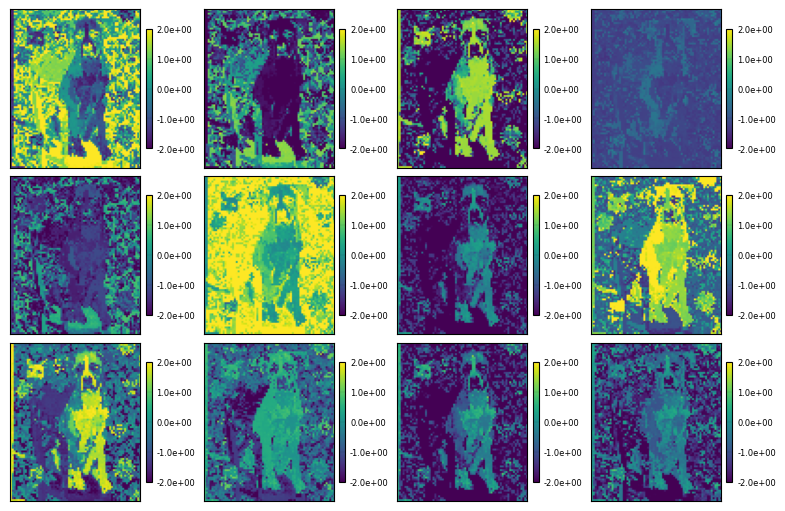

In [20]:
# computes the embeddings
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5), clim=(-2, 2))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


- We know that we only have 3 intrinsic latent variables


## Model with 3 latent variables

### Instantiates the model (3 latent variables)


In [21]:
# rebuilds the model with 3 latent dimensions
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [22]:
# prints the summary of the model
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 3 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


In [23]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [24]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 303.29it/s]


Epoch 0, Train Loss: 2.3594
.............................


100%|██████████| 19/19 [00:00<00:00, 427.24it/s]


Epoch 1, Train Loss: 2.3181
.............................


100%|██████████| 19/19 [00:00<00:00, 433.54it/s]


Epoch 2, Train Loss: 2.2805
.............................


100%|██████████| 19/19 [00:00<00:00, 422.37it/s]


Epoch 3, Train Loss: 2.2494
.............................


100%|██████████| 19/19 [00:00<00:00, 420.64it/s]


Epoch 4, Train Loss: 2.2163
.............................


100%|██████████| 19/19 [00:00<00:00, 431.96it/s]


Epoch 5, Train Loss: 2.1850
.............................


100%|██████████| 19/19 [00:00<00:00, 433.94it/s]


Epoch 6, Train Loss: 2.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 383.48it/s]


Epoch 7, Train Loss: 2.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 411.68it/s]


Epoch 8, Train Loss: 2.0912
.............................


100%|██████████| 19/19 [00:00<00:00, 427.11it/s]


Epoch 9, Train Loss: 2.0593
.............................


100%|██████████| 19/19 [00:00<00:00, 387.66it/s]


Epoch 10, Train Loss: 2.0236
.............................


100%|██████████| 19/19 [00:00<00:00, 402.66it/s]


Epoch 11, Train Loss: 1.9853
.............................


100%|██████████| 19/19 [00:00<00:00, 427.65it/s]


Epoch 12, Train Loss: 1.9495
.............................


100%|██████████| 19/19 [00:00<00:00, 429.98it/s]


Epoch 13, Train Loss: 1.9113
.............................


100%|██████████| 19/19 [00:00<00:00, 384.29it/s]


Epoch 14, Train Loss: 1.8703
.............................


100%|██████████| 19/19 [00:00<00:00, 320.36it/s]


Epoch 15, Train Loss: 1.8264
.............................


100%|██████████| 19/19 [00:00<00:00, 313.81it/s]


Epoch 16, Train Loss: 1.7808
.............................


100%|██████████| 19/19 [00:00<00:00, 192.32it/s]


Epoch 17, Train Loss: 1.7369
.............................


100%|██████████| 19/19 [00:00<00:00, 246.62it/s]


Epoch 18, Train Loss: 1.6876
.............................


100%|██████████| 19/19 [00:00<00:00, 271.08it/s]


Epoch 19, Train Loss: 1.6333
.............................


100%|██████████| 19/19 [00:00<00:00, 276.25it/s]


Epoch 20, Train Loss: 1.5798
.............................


100%|██████████| 19/19 [00:00<00:00, 279.68it/s]


Epoch 21, Train Loss: 1.5261
.............................


100%|██████████| 19/19 [00:00<00:00, 176.18it/s]


Epoch 22, Train Loss: 1.4660
.............................


100%|██████████| 19/19 [00:00<00:00, 275.64it/s]


Epoch 23, Train Loss: 1.4064
.............................


100%|██████████| 19/19 [00:00<00:00, 275.25it/s]


Epoch 24, Train Loss: 1.3457
.............................


100%|██████████| 19/19 [00:00<00:00, 291.76it/s]


Epoch 25, Train Loss: 1.2864
.............................


100%|██████████| 19/19 [00:00<00:00, 265.57it/s]


Epoch 26, Train Loss: 1.2266
.............................


100%|██████████| 19/19 [00:00<00:00, 270.32it/s]


Epoch 27, Train Loss: 1.1685
.............................


100%|██████████| 19/19 [00:00<00:00, 236.29it/s]


Epoch 28, Train Loss: 1.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 258.45it/s]


Epoch 29, Train Loss: 1.0524
.............................


100%|██████████| 19/19 [00:00<00:00, 242.58it/s]


Epoch 30, Train Loss: 0.9975
.............................


100%|██████████| 19/19 [00:00<00:00, 296.09it/s]


Epoch 31, Train Loss: 0.9439
.............................


100%|██████████| 19/19 [00:00<00:00, 248.15it/s]


Epoch 32, Train Loss: 0.8917
.............................


100%|██████████| 19/19 [00:00<00:00, 292.40it/s]


Epoch 33, Train Loss: 0.8427
.............................


100%|██████████| 19/19 [00:00<00:00, 259.67it/s]


Epoch 34, Train Loss: 0.7950
.............................


100%|██████████| 19/19 [00:00<00:00, 290.72it/s]


Epoch 35, Train Loss: 0.7502
.............................


100%|██████████| 19/19 [00:00<00:00, 261.40it/s]


Epoch 36, Train Loss: 0.7077
.............................


100%|██████████| 19/19 [00:00<00:00, 225.99it/s]


Epoch 37, Train Loss: 0.6668
.............................


100%|██████████| 19/19 [00:00<00:00, 149.62it/s]


Epoch 38, Train Loss: 0.6293
.............................


100%|██████████| 19/19 [00:00<00:00, 119.39it/s]


Epoch 39, Train Loss: 0.5935
.............................


100%|██████████| 19/19 [00:00<00:00, 192.95it/s]


Epoch 40, Train Loss: 0.5598
.............................


100%|██████████| 19/19 [00:00<00:00, 120.28it/s]


Epoch 41, Train Loss: 0.5290
.............................


100%|██████████| 19/19 [00:00<00:00, 300.69it/s]


Epoch 42, Train Loss: 0.5001
.............................


100%|██████████| 19/19 [00:00<00:00, 289.14it/s]


Epoch 43, Train Loss: 0.4723
.............................


100%|██████████| 19/19 [00:00<00:00, 246.61it/s]


Epoch 44, Train Loss: 0.4470
.............................


100%|██████████| 19/19 [00:00<00:00, 219.13it/s]


Epoch 45, Train Loss: 0.4242
.............................


100%|██████████| 19/19 [00:00<00:00, 292.71it/s]


Epoch 46, Train Loss: 0.4030
.............................


100%|██████████| 19/19 [00:00<00:00, 256.74it/s]


Epoch 47, Train Loss: 0.3825
.............................


100%|██████████| 19/19 [00:00<00:00, 391.08it/s]


Epoch 48, Train Loss: 0.3655
.............................


100%|██████████| 19/19 [00:00<00:00, 393.27it/s]


Epoch 49, Train Loss: 0.3486
.............................


100%|██████████| 19/19 [00:00<00:00, 426.10it/s]


Epoch 50, Train Loss: 0.3335
.............................


100%|██████████| 19/19 [00:00<00:00, 430.84it/s]


Epoch 51, Train Loss: 0.3193
.............................


100%|██████████| 19/19 [00:00<00:00, 349.53it/s]


Epoch 52, Train Loss: 0.3065
.............................


100%|██████████| 19/19 [00:00<00:00, 422.67it/s]


Epoch 53, Train Loss: 0.2943
.............................


100%|██████████| 19/19 [00:00<00:00, 421.54it/s]


Epoch 54, Train Loss: 0.2836
.............................


100%|██████████| 19/19 [00:00<00:00, 351.72it/s]


Epoch 55, Train Loss: 0.2732
.............................


100%|██████████| 19/19 [00:00<00:00, 419.58it/s]


Epoch 56, Train Loss: 0.2647
.............................


100%|██████████| 19/19 [00:00<00:00, 413.35it/s]


Epoch 57, Train Loss: 0.2565
.............................


100%|██████████| 19/19 [00:00<00:00, 428.01it/s]


Epoch 58, Train Loss: 0.2486
.............................


100%|██████████| 19/19 [00:00<00:00, 421.92it/s]


Epoch 59, Train Loss: 0.2418
.............................


100%|██████████| 19/19 [00:00<00:00, 390.53it/s]


Epoch 60, Train Loss: 0.2354
.............................


100%|██████████| 19/19 [00:00<00:00, 416.19it/s]


Epoch 61, Train Loss: 0.2295
.............................


100%|██████████| 19/19 [00:00<00:00, 408.55it/s]


Epoch 62, Train Loss: 0.2243
.............................


100%|██████████| 19/19 [00:00<00:00, 385.72it/s]


Epoch 63, Train Loss: 0.2194
.............................


100%|██████████| 19/19 [00:00<00:00, 413.38it/s]


Epoch 64, Train Loss: 0.2149
.............................


100%|██████████| 19/19 [00:00<00:00, 424.46it/s]


Epoch 65, Train Loss: 0.2106
.............................


100%|██████████| 19/19 [00:00<00:00, 418.61it/s]


Epoch 66, Train Loss: 0.2071
.............................


100%|██████████| 19/19 [00:00<00:00, 423.71it/s]


Epoch 67, Train Loss: 0.2032
.............................


100%|██████████| 19/19 [00:00<00:00, 409.70it/s]


Epoch 68, Train Loss: 0.2003
.............................


100%|██████████| 19/19 [00:00<00:00, 417.07it/s]


Epoch 69, Train Loss: 0.1968
.............................


100%|██████████| 19/19 [00:00<00:00, 431.74it/s]


Epoch 70, Train Loss: 0.1943
.............................


100%|██████████| 19/19 [00:00<00:00, 443.48it/s]


Epoch 71, Train Loss: 0.1916
.............................


100%|██████████| 19/19 [00:00<00:00, 407.53it/s]


Epoch 72, Train Loss: 0.1892
.............................


100%|██████████| 19/19 [00:00<00:00, 396.50it/s]


Epoch 73, Train Loss: 0.1871
.............................


100%|██████████| 19/19 [00:00<00:00, 424.07it/s]


Epoch 74, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 347.37it/s]


Epoch 75, Train Loss: 0.1827
.............................


100%|██████████| 19/19 [00:00<00:00, 253.81it/s]


Epoch 76, Train Loss: 0.1810
.............................


100%|██████████| 19/19 [00:00<00:00, 419.96it/s]


Epoch 77, Train Loss: 0.1790
.............................


100%|██████████| 19/19 [00:00<00:00, 421.62it/s]


Epoch 78, Train Loss: 0.1775
.............................


100%|██████████| 19/19 [00:00<00:00, 409.25it/s]


Epoch 79, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 430.77it/s]


Epoch 80, Train Loss: 0.1748
.............................


100%|██████████| 19/19 [00:00<00:00, 405.75it/s]


Epoch 81, Train Loss: 0.1733
.............................


100%|██████████| 19/19 [00:00<00:00, 377.98it/s]


Epoch 82, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 412.56it/s]


Epoch 83, Train Loss: 0.1712
.............................


100%|██████████| 19/19 [00:00<00:00, 369.32it/s]


Epoch 84, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 409.95it/s]


Epoch 85, Train Loss: 0.1690
.............................


100%|██████████| 19/19 [00:00<00:00, 407.71it/s]


Epoch 86, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 421.26it/s]


Epoch 87, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 417.55it/s]


Epoch 88, Train Loss: 0.1664
.............................


100%|██████████| 19/19 [00:00<00:00, 420.35it/s]


Epoch 89, Train Loss: 0.1657
.............................


100%|██████████| 19/19 [00:00<00:00, 418.22it/s]


Epoch 90, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 420.60it/s]


Epoch 91, Train Loss: 0.1641
.............................


100%|██████████| 19/19 [00:00<00:00, 431.39it/s]


Epoch 92, Train Loss: 0.1634
.............................


100%|██████████| 19/19 [00:00<00:00, 420.87it/s]


Epoch 93, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 405.03it/s]


Epoch 94, Train Loss: 0.1623
.............................


100%|██████████| 19/19 [00:00<00:00, 396.43it/s]


Epoch 95, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 336.79it/s]


Epoch 96, Train Loss: 0.1612
.............................


100%|██████████| 19/19 [00:00<00:00, 411.27it/s]


Epoch 97, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 415.56it/s]


Epoch 98, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 406.61it/s]


Epoch 99, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 413.77it/s]


Epoch 100, Train Loss: 0.1595
.............................


100%|██████████| 19/19 [00:00<00:00, 399.31it/s]


Epoch 101, Train Loss: 0.1592
.............................


100%|██████████| 19/19 [00:00<00:00, 411.56it/s]


Epoch 102, Train Loss: 0.1587
.............................


100%|██████████| 19/19 [00:00<00:00, 368.10it/s]


Epoch 103, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 402.98it/s]


Epoch 104, Train Loss: 0.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 420.72it/s]


Epoch 105, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 405.32it/s]


Epoch 106, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 395.71it/s]


Epoch 107, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 390.90it/s]


Epoch 108, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 431.52it/s]


Epoch 109, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 407.95it/s]


Epoch 110, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 406.17it/s]


Epoch 111, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 422.79it/s]


Epoch 112, Train Loss: 0.1559
.............................


100%|██████████| 19/19 [00:00<00:00, 418.08it/s]


Epoch 113, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 385.90it/s]


Epoch 114, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 420.95it/s]


Epoch 115, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 398.68it/s]


Epoch 116, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 312.83it/s]


Epoch 117, Train Loss: 0.1545
.............................


100%|██████████| 19/19 [00:00<00:00, 410.99it/s]


Epoch 118, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 410.65it/s]


Epoch 119, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 414.72it/s]


Epoch 120, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 408.75it/s]


Epoch 121, Train Loss: 0.1537
.............................


100%|██████████| 19/19 [00:00<00:00, 412.70it/s]


Epoch 122, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 387.98it/s]


Epoch 123, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 348.01it/s]


Epoch 124, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 420.77it/s]


Epoch 125, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 403.19it/s]


Epoch 126, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 417.21it/s]


Epoch 127, Train Loss: 0.1524
.............................


100%|██████████| 19/19 [00:00<00:00, 415.12it/s]


Epoch 128, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 373.97it/s]


Epoch 129, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 404.34it/s]


Epoch 130, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 389.57it/s]


Epoch 131, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 395.75it/s]


Epoch 132, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 403.26it/s]


Epoch 133, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 377.48it/s]


Epoch 134, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 410.30it/s]


Epoch 135, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 400.41it/s]


Epoch 136, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 328.99it/s]


Epoch 137, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 393.71it/s]


Epoch 138, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 365.04it/s]


Epoch 139, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 394.82it/s]


Epoch 140, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 396.85it/s]


Epoch 141, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 371.88it/s]


Epoch 142, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 400.05it/s]


Epoch 143, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 395.45it/s]


Epoch 144, Train Loss: 0.1485
.............................


100%|██████████| 19/19 [00:00<00:00, 394.86it/s]


Epoch 145, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 394.09it/s]


Epoch 146, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 415.57it/s]


Epoch 147, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 341.72it/s]


Epoch 148, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 274.41it/s]


Epoch 149, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 295.20it/s]


Epoch 150, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 309.64it/s]


Epoch 151, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 311.62it/s]


Epoch 152, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 284.52it/s]


Epoch 153, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 262.35it/s]


Epoch 154, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 298.07it/s]


Epoch 155, Train Loss: 0.1458
.............................


100%|██████████| 19/19 [00:00<00:00, 285.87it/s]


Epoch 156, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 303.17it/s]


Epoch 157, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 264.00it/s]


Epoch 158, Train Loss: 0.1451
.............................


100%|██████████| 19/19 [00:00<00:00, 288.97it/s]


Epoch 159, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 328.54it/s]


Epoch 160, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 322.88it/s]


Epoch 161, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 301.07it/s]


Epoch 162, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 328.45it/s]


Epoch 163, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 317.32it/s]


Epoch 164, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 255.48it/s]


Epoch 165, Train Loss: 0.1431
.............................


100%|██████████| 19/19 [00:00<00:00, 319.74it/s]


Epoch 166, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 317.10it/s]


Epoch 167, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 321.10it/s]


Epoch 168, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 320.02it/s]


Epoch 169, Train Loss: 0.1422
.............................


100%|██████████| 19/19 [00:00<00:00, 261.98it/s]


Epoch 170, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 326.53it/s]


Epoch 171, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 316.78it/s]


Epoch 172, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 292.72it/s]


Epoch 173, Train Loss: 0.1411
.............................


100%|██████████| 19/19 [00:00<00:00, 278.29it/s]


Epoch 174, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 294.85it/s]


Epoch 175, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 302.66it/s]


Epoch 176, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 311.98it/s]


Epoch 177, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 306.86it/s]


Epoch 178, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 288.20it/s]


Epoch 179, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 267.10it/s]


Epoch 180, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 303.84it/s]


Epoch 181, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 264.69it/s]


Epoch 182, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 267.77it/s]


Epoch 183, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 252.04it/s]


Epoch 184, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 217.64it/s]


Epoch 185, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 303.46it/s]


Epoch 186, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 385.82it/s]


Epoch 187, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 396.40it/s]


Epoch 188, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 397.01it/s]


Epoch 189, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 412.27it/s]


Epoch 190, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 382.62it/s]


Epoch 191, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 409.78it/s]


Epoch 192, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 376.31it/s]


Epoch 193, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 390.73it/s]


Epoch 194, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 422.10it/s]


Epoch 195, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 405.01it/s]


Epoch 196, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 378.18it/s]


Epoch 197, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 409.22it/s]


Epoch 198, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 366.61it/s]


Epoch 199, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 404.15it/s]


Epoch 200, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 400.58it/s]


Epoch 201, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 406.67it/s]


Epoch 202, Train Loss: 0.1326
.............................


100%|██████████| 19/19 [00:00<00:00, 416.15it/s]


Epoch 203, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 309.51it/s]


Epoch 204, Train Loss: 0.1321
.............................


100%|██████████| 19/19 [00:00<00:00, 386.97it/s]


Epoch 205, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 408.22it/s]


Epoch 206, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 330.84it/s]


Epoch 207, Train Loss: 0.1311
.............................


100%|██████████| 19/19 [00:00<00:00, 411.71it/s]


Epoch 208, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 364.74it/s]


Epoch 209, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 383.39it/s]


Epoch 210, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 407.52it/s]


Epoch 211, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 388.97it/s]


Epoch 212, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 417.32it/s]


Epoch 213, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 402.40it/s]


Epoch 214, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 370.06it/s]


Epoch 215, Train Loss: 0.1287
.............................


100%|██████████| 19/19 [00:00<00:00, 381.47it/s]


Epoch 216, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 388.02it/s]


Epoch 217, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 386.60it/s]


Epoch 218, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 370.12it/s]


Epoch 219, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 398.68it/s]


Epoch 220, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 408.48it/s]


Epoch 221, Train Loss: 0.1271
.............................


100%|██████████| 19/19 [00:00<00:00, 397.13it/s]


Epoch 222, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 333.05it/s]


Epoch 223, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 323.60it/s]


Epoch 224, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 390.40it/s]


Epoch 225, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 388.25it/s]


Epoch 226, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 402.49it/s]


Epoch 227, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 381.92it/s]


Epoch 228, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 385.06it/s]


Epoch 229, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 334.80it/s]


Epoch 230, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 401.23it/s]


Epoch 231, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 392.62it/s]


Epoch 232, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 393.13it/s]


Epoch 233, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 329.18it/s]


Epoch 234, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 364.82it/s]


Epoch 235, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 404.72it/s]


Epoch 236, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 396.15it/s]


Epoch 237, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 383.62it/s]


Epoch 238, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 400.05it/s]


Epoch 239, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 381.34it/s]


Epoch 240, Train Loss: 0.1217
.............................


100%|██████████| 19/19 [00:00<00:00, 382.84it/s]


Epoch 241, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 383.27it/s]


Epoch 242, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 305.00it/s]


Epoch 243, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 393.42it/s]


Epoch 244, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 382.84it/s]


Epoch 245, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 384.71it/s]


Epoch 246, Train Loss: 0.1198
.............................


100%|██████████| 19/19 [00:00<00:00, 399.47it/s]


Epoch 247, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 406.66it/s]


Epoch 248, Train Loss: 0.1193
.............................


100%|██████████| 19/19 [00:00<00:00, 384.04it/s]


Epoch 249, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 379.93it/s]


Epoch 250, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 391.94it/s]


Epoch 251, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 397.89it/s]


Epoch 252, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 405.53it/s]


Epoch 253, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 384.56it/s]


Epoch 254, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 375.91it/s]


Epoch 255, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 392.88it/s]


Epoch 256, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 402.17it/s]


Epoch 257, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 412.09it/s]


Epoch 258, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 370.20it/s]


Epoch 259, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 399.49it/s]


Epoch 260, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 377.11it/s]


Epoch 261, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 329.69it/s]


Epoch 262, Train Loss: 0.1156
.............................


100%|██████████| 19/19 [00:00<00:00, 375.21it/s]


Epoch 263, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 386.31it/s]


Epoch 264, Train Loss: 0.1150
.............................


100%|██████████| 19/19 [00:00<00:00, 380.45it/s]


Epoch 265, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 361.93it/s]


Epoch 266, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 385.64it/s]


Epoch 267, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 383.48it/s]


Epoch 268, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 387.39it/s]


Epoch 269, Train Loss: 0.1137
.............................


100%|██████████| 19/19 [00:00<00:00, 383.75it/s]


Epoch 270, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 398.84it/s]


Epoch 271, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 387.50it/s]


Epoch 272, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 399.38it/s]


Epoch 273, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 374.40it/s]


Epoch 274, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 378.66it/s]


Epoch 275, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 403.74it/s]


Epoch 276, Train Loss: 0.1122
.............................


100%|██████████| 19/19 [00:00<00:00, 396.92it/s]


Epoch 277, Train Loss: 0.1119
.............................


100%|██████████| 19/19 [00:00<00:00, 377.27it/s]


Epoch 278, Train Loss: 0.1117
.............................


100%|██████████| 19/19 [00:00<00:00, 360.78it/s]


Epoch 279, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 374.06it/s]


Epoch 280, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 335.27it/s]


Epoch 281, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 268.14it/s]


Epoch 282, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 376.54it/s]


Epoch 283, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 394.61it/s]


Epoch 284, Train Loss: 0.1104
.............................


100%|██████████| 19/19 [00:00<00:00, 399.31it/s]


Epoch 285, Train Loss: 0.1100
.............................


100%|██████████| 19/19 [00:00<00:00, 401.82it/s]


Epoch 286, Train Loss: 0.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 403.46it/s]


Epoch 287, Train Loss: 0.1094
.............................


100%|██████████| 19/19 [00:00<00:00, 354.24it/s]


Epoch 288, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 389.67it/s]


Epoch 289, Train Loss: 0.1092
.............................


100%|██████████| 19/19 [00:00<00:00, 400.18it/s]


Epoch 290, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 379.77it/s]


Epoch 291, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 387.26it/s]


Epoch 292, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 392.03it/s]


Epoch 293, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 392.00it/s]


Epoch 294, Train Loss: 0.1083
.............................


100%|██████████| 19/19 [00:00<00:00, 396.91it/s]


Epoch 295, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 400.33it/s]


Epoch 296, Train Loss: 0.1079
.............................


100%|██████████| 19/19 [00:00<00:00, 400.50it/s]


Epoch 297, Train Loss: 0.1076
.............................


100%|██████████| 19/19 [00:00<00:00, 360.58it/s]


Epoch 298, Train Loss: 0.1073
.............................


100%|██████████| 19/19 [00:00<00:00, 378.45it/s]


Epoch 299, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 394.45it/s]


Epoch 300, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 319.87it/s]


Epoch 301, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 383.84it/s]


Epoch 302, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 390.03it/s]


Epoch 303, Train Loss: 0.1066
.............................


100%|██████████| 19/19 [00:00<00:00, 390.22it/s]


Epoch 304, Train Loss: 0.1063
.............................


100%|██████████| 19/19 [00:00<00:00, 379.37it/s]


Epoch 305, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 387.26it/s]


Epoch 306, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 393.51it/s]


Epoch 307, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 382.88it/s]


Epoch 308, Train Loss: 0.1060
.............................


100%|██████████| 19/19 [00:00<00:00, 392.81it/s]


Epoch 309, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 387.83it/s]


Epoch 310, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 356.87it/s]


Epoch 311, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 390.71it/s]


Epoch 312, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 373.14it/s]


Epoch 313, Train Loss: 0.1050
.............................


100%|██████████| 19/19 [00:00<00:00, 398.51it/s]


Epoch 314, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 391.30it/s]


Epoch 315, Train Loss: 0.1045
.............................


100%|██████████| 19/19 [00:00<00:00, 386.95it/s]


Epoch 316, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 380.14it/s]


Epoch 317, Train Loss: 0.1042
.............................


100%|██████████| 19/19 [00:00<00:00, 348.37it/s]


Epoch 318, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 388.26it/s]


Epoch 319, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 368.47it/s]


Epoch 320, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 334.00it/s]


Epoch 321, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 375.87it/s]


Epoch 322, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 373.49it/s]


Epoch 323, Train Loss: 0.1035
.............................


100%|██████████| 19/19 [00:00<00:00, 381.29it/s]


Epoch 324, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 372.48it/s]


Epoch 325, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 382.90it/s]


Epoch 326, Train Loss: 0.1029
.............................


100%|██████████| 19/19 [00:00<00:00, 365.58it/s]


Epoch 327, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 372.40it/s]


Epoch 328, Train Loss: 0.1028
.............................


100%|██████████| 19/19 [00:00<00:00, 387.56it/s]


Epoch 329, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 377.99it/s]


Epoch 330, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 380.19it/s]


Epoch 331, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 382.28it/s]


Epoch 332, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 374.08it/s]


Epoch 333, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 394.48it/s]


Epoch 334, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 373.65it/s]


Epoch 335, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 350.21it/s]


Epoch 336, Train Loss: 0.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 381.31it/s]


Epoch 337, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 383.58it/s]


Epoch 338, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 357.68it/s]


Epoch 339, Train Loss: 0.1014
.............................


100%|██████████| 19/19 [00:00<00:00, 339.38it/s]


Epoch 340, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 370.60it/s]


Epoch 341, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 377.08it/s]


Epoch 342, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 378.44it/s]


Epoch 343, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 367.56it/s]


Epoch 344, Train Loss: 0.1008
.............................


100%|██████████| 19/19 [00:00<00:00, 370.46it/s]


Epoch 345, Train Loss: 0.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 378.12it/s]


Epoch 346, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 379.73it/s]


Epoch 347, Train Loss: 0.1004
.............................


100%|██████████| 19/19 [00:00<00:00, 364.69it/s]


Epoch 348, Train Loss: 0.1002
.............................


100%|██████████| 19/19 [00:00<00:00, 374.08it/s]


Epoch 349, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 385.64it/s]


Epoch 350, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 382.81it/s]


Epoch 351, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 377.02it/s]


Epoch 352, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 361.94it/s]


Epoch 353, Train Loss: 0.0997
.............................


100%|██████████| 19/19 [00:00<00:00, 363.03it/s]


Epoch 354, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 372.12it/s]


Epoch 355, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 369.41it/s]


Epoch 356, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 385.60it/s]


Epoch 357, Train Loss: 0.0991
.............................


100%|██████████| 19/19 [00:00<00:00, 306.51it/s]


Epoch 358, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 309.47it/s]


Epoch 359, Train Loss: 0.0989
.............................


100%|██████████| 19/19 [00:00<00:00, 338.23it/s]


Epoch 360, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 383.91it/s]


Epoch 361, Train Loss: 0.0988
.............................


100%|██████████| 19/19 [00:00<00:00, 335.99it/s]


Epoch 362, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 364.45it/s]


Epoch 363, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 363.83it/s]


Epoch 364, Train Loss: 0.0985
.............................


100%|██████████| 19/19 [00:00<00:00, 376.53it/s]


Epoch 365, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 346.14it/s]


Epoch 366, Train Loss: 0.0982
.............................


100%|██████████| 19/19 [00:00<00:00, 334.24it/s]


Epoch 367, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 365.17it/s]


Epoch 368, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 363.15it/s]


Epoch 369, Train Loss: 0.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 380.99it/s]


Epoch 370, Train Loss: 0.0975
.............................


100%|██████████| 19/19 [00:00<00:00, 316.88it/s]


Epoch 371, Train Loss: 0.0977
.............................


100%|██████████| 19/19 [00:00<00:00, 271.67it/s]


Epoch 372, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 310.12it/s]


Epoch 373, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 293.02it/s]


Epoch 374, Train Loss: 0.0973
.............................


100%|██████████| 19/19 [00:00<00:00, 303.45it/s]


Epoch 375, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 231.39it/s]


Epoch 376, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 281.79it/s]


Epoch 377, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 250.29it/s]


Epoch 378, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 290.16it/s]


Epoch 379, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 266.20it/s]


Epoch 380, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 293.26it/s]


Epoch 381, Train Loss: 0.0963
.............................


100%|██████████| 19/19 [00:00<00:00, 317.74it/s]


Epoch 382, Train Loss: 0.0961
.............................


100%|██████████| 19/19 [00:00<00:00, 311.51it/s]


Epoch 383, Train Loss: 0.0962
.............................


100%|██████████| 19/19 [00:00<00:00, 292.09it/s]


Epoch 384, Train Loss: 0.0960
.............................


100%|██████████| 19/19 [00:00<00:00, 309.67it/s]


Epoch 385, Train Loss: 0.0959
.............................


100%|██████████| 19/19 [00:00<00:00, 275.56it/s]


Epoch 386, Train Loss: 0.0958
.............................


100%|██████████| 19/19 [00:00<00:00, 260.16it/s]


Epoch 387, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 309.50it/s]


Epoch 388, Train Loss: 0.0955
.............................


100%|██████████| 19/19 [00:00<00:00, 308.23it/s]


Epoch 389, Train Loss: 0.0954
.............................


100%|██████████| 19/19 [00:00<00:00, 327.06it/s]


Epoch 390, Train Loss: 0.0953
.............................


100%|██████████| 19/19 [00:00<00:00, 270.33it/s]


Epoch 391, Train Loss: 0.0951
.............................


100%|██████████| 19/19 [00:00<00:00, 295.71it/s]


Epoch 392, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 327.59it/s]


Epoch 393, Train Loss: 0.0948
.............................


100%|██████████| 19/19 [00:00<00:00, 313.19it/s]


Epoch 394, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 332.65it/s]


Epoch 395, Train Loss: 0.0944
.............................


100%|██████████| 19/19 [00:00<00:00, 294.32it/s]


Epoch 396, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 332.17it/s]


Epoch 397, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 336.03it/s]


Epoch 398, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 316.70it/s]


Epoch 399, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 305.15it/s]


Epoch 400, Train Loss: 0.0939
.............................


100%|██████████| 19/19 [00:00<00:00, 248.15it/s]


Epoch 401, Train Loss: 0.0937
.............................


100%|██████████| 19/19 [00:00<00:00, 244.19it/s]


Epoch 402, Train Loss: 0.0935
.............................


100%|██████████| 19/19 [00:00<00:00, 267.51it/s]


Epoch 403, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 262.20it/s]


Epoch 404, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 285.02it/s]


Epoch 405, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 252.20it/s]


Epoch 406, Train Loss: 0.0930
.............................


100%|██████████| 19/19 [00:00<00:00, 244.32it/s]


Epoch 407, Train Loss: 0.0929
.............................


100%|██████████| 19/19 [00:00<00:00, 265.81it/s]


Epoch 408, Train Loss: 0.0926
.............................


100%|██████████| 19/19 [00:00<00:00, 220.21it/s]


Epoch 409, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 242.83it/s]


Epoch 410, Train Loss: 0.0926
.............................


100%|██████████| 19/19 [00:00<00:00, 279.76it/s]


Epoch 411, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 255.63it/s]


Epoch 412, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 282.36it/s]


Epoch 413, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 256.34it/s]


Epoch 414, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 376.18it/s]


Epoch 415, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 374.83it/s]


Epoch 416, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 364.86it/s]


Epoch 417, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 359.10it/s]


Epoch 418, Train Loss: 0.0916
.............................


100%|██████████| 19/19 [00:00<00:00, 358.77it/s]


Epoch 419, Train Loss: 0.0913
.............................


100%|██████████| 19/19 [00:00<00:00, 372.29it/s]


Epoch 420, Train Loss: 0.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 371.26it/s]


Epoch 421, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 378.42it/s]


Epoch 422, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 298.28it/s]


Epoch 423, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 376.43it/s]


Epoch 424, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 345.66it/s]


Epoch 425, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 367.80it/s]


Epoch 426, Train Loss: 0.0903
.............................


100%|██████████| 19/19 [00:00<00:00, 375.43it/s]


Epoch 427, Train Loss: 0.0901
.............................


100%|██████████| 19/19 [00:00<00:00, 372.17it/s]


Epoch 428, Train Loss: 0.0900
.............................


100%|██████████| 19/19 [00:00<00:00, 379.52it/s]


Epoch 429, Train Loss: 0.0899
.............................


100%|██████████| 19/19 [00:00<00:00, 359.48it/s]


Epoch 430, Train Loss: 0.0896
.............................


100%|██████████| 19/19 [00:00<00:00, 307.79it/s]


Epoch 431, Train Loss: 0.0896
.............................


100%|██████████| 19/19 [00:00<00:00, 328.50it/s]


Epoch 432, Train Loss: 0.0894
.............................


100%|██████████| 19/19 [00:00<00:00, 357.56it/s]


Epoch 433, Train Loss: 0.0894
.............................


100%|██████████| 19/19 [00:00<00:00, 349.94it/s]


Epoch 434, Train Loss: 0.0892
.............................


100%|██████████| 19/19 [00:00<00:00, 341.91it/s]


Epoch 435, Train Loss: 0.0889
.............................


100%|██████████| 19/19 [00:00<00:00, 364.18it/s]


Epoch 436, Train Loss: 0.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 365.27it/s]


Epoch 437, Train Loss: 0.0887
.............................


100%|██████████| 19/19 [00:00<00:00, 370.33it/s]


Epoch 438, Train Loss: 0.0885
.............................


100%|██████████| 19/19 [00:00<00:00, 364.48it/s]


Epoch 439, Train Loss: 0.0884
.............................


100%|██████████| 19/19 [00:00<00:00, 371.28it/s]


Epoch 440, Train Loss: 0.0883
.............................


100%|██████████| 19/19 [00:00<00:00, 301.54it/s]


Epoch 441, Train Loss: 0.0882
.............................


100%|██████████| 19/19 [00:00<00:00, 380.05it/s]


Epoch 442, Train Loss: 0.0878
.............................


100%|██████████| 19/19 [00:00<00:00, 357.40it/s]


Epoch 443, Train Loss: 0.0878
.............................


100%|██████████| 19/19 [00:00<00:00, 370.38it/s]


Epoch 444, Train Loss: 0.0876
.............................


100%|██████████| 19/19 [00:00<00:00, 371.17it/s]


Epoch 445, Train Loss: 0.0875
.............................


100%|██████████| 19/19 [00:00<00:00, 368.77it/s]


Epoch 446, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 387.02it/s]


Epoch 447, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 352.72it/s]


Epoch 448, Train Loss: 0.0870
.............................


100%|██████████| 19/19 [00:00<00:00, 342.73it/s]


Epoch 449, Train Loss: 0.0870
.............................


100%|██████████| 19/19 [00:00<00:00, 353.30it/s]


Epoch 450, Train Loss: 0.0868
.............................


100%|██████████| 19/19 [00:00<00:00, 371.75it/s]


Epoch 451, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 366.85it/s]


Epoch 452, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 373.46it/s]


Epoch 453, Train Loss: 0.0864
.............................


100%|██████████| 19/19 [00:00<00:00, 379.42it/s]


Epoch 454, Train Loss: 0.0863
.............................


100%|██████████| 19/19 [00:00<00:00, 358.72it/s]


Epoch 455, Train Loss: 0.0860
.............................


100%|██████████| 19/19 [00:00<00:00, 345.87it/s]


Epoch 456, Train Loss: 0.0858
.............................


100%|██████████| 19/19 [00:00<00:00, 371.49it/s]


Epoch 457, Train Loss: 0.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 370.90it/s]


Epoch 458, Train Loss: 0.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 348.90it/s]


Epoch 459, Train Loss: 0.0856
.............................


100%|██████████| 19/19 [00:00<00:00, 289.21it/s]


Epoch 460, Train Loss: 0.0854
.............................


100%|██████████| 19/19 [00:00<00:00, 360.37it/s]


Epoch 461, Train Loss: 0.0852
.............................


100%|██████████| 19/19 [00:00<00:00, 364.26it/s]


Epoch 462, Train Loss: 0.0850
.............................


100%|██████████| 19/19 [00:00<00:00, 365.08it/s]


Epoch 463, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 374.76it/s]


Epoch 464, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 375.21it/s]


Epoch 465, Train Loss: 0.0847
.............................


100%|██████████| 19/19 [00:00<00:00, 343.08it/s]


Epoch 466, Train Loss: 0.0845
.............................


100%|██████████| 19/19 [00:00<00:00, 344.87it/s]


Epoch 467, Train Loss: 0.0843
.............................


100%|██████████| 19/19 [00:00<00:00, 362.95it/s]


Epoch 468, Train Loss: 0.0843
.............................


100%|██████████| 19/19 [00:00<00:00, 330.24it/s]


Epoch 469, Train Loss: 0.0841
.............................


100%|██████████| 19/19 [00:00<00:00, 369.29it/s]


Epoch 470, Train Loss: 0.0840
.............................


100%|██████████| 19/19 [00:00<00:00, 380.80it/s]


Epoch 471, Train Loss: 0.0839
.............................


100%|██████████| 19/19 [00:00<00:00, 371.06it/s]


Epoch 472, Train Loss: 0.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 357.60it/s]


Epoch 473, Train Loss: 0.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 362.54it/s]


Epoch 474, Train Loss: 0.0833
.............................


100%|██████████| 19/19 [00:00<00:00, 360.21it/s]


Epoch 475, Train Loss: 0.0834
.............................


100%|██████████| 19/19 [00:00<00:00, 371.04it/s]


Epoch 476, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 370.51it/s]


Epoch 477, Train Loss: 0.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 284.16it/s]


Epoch 478, Train Loss: 0.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 364.40it/s]


Epoch 479, Train Loss: 0.0827
.............................


100%|██████████| 19/19 [00:00<00:00, 388.07it/s]


Epoch 480, Train Loss: 0.0826
.............................


100%|██████████| 19/19 [00:00<00:00, 363.49it/s]


Epoch 481, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 356.05it/s]


Epoch 482, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 363.85it/s]


Epoch 483, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 368.51it/s]


Epoch 484, Train Loss: 0.0822
.............................


100%|██████████| 19/19 [00:00<00:00, 337.90it/s]


Epoch 485, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 338.23it/s]


Epoch 486, Train Loss: 0.0818
.............................


100%|██████████| 19/19 [00:00<00:00, 355.15it/s]


Epoch 487, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 363.11it/s]


Epoch 488, Train Loss: 0.0817
.............................


100%|██████████| 19/19 [00:00<00:00, 385.88it/s]


Epoch 489, Train Loss: 0.0815
.............................


100%|██████████| 19/19 [00:00<00:00, 359.48it/s]


Epoch 490, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 350.22it/s]


Epoch 491, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 367.30it/s]


Epoch 492, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 375.69it/s]


Epoch 493, Train Loss: 0.0811
.............................


100%|██████████| 19/19 [00:00<00:00, 365.05it/s]


Epoch 494, Train Loss: 0.0809
.............................


100%|██████████| 19/19 [00:00<00:00, 371.32it/s]


Epoch 495, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 290.83it/s]


Epoch 496, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 354.36it/s]


Epoch 497, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 362.68it/s]


Epoch 498, Train Loss: 0.0804
.............................


100%|██████████| 19/19 [00:00<00:00, 356.73it/s]

Epoch 499, Train Loss: 0.0803
.............................


In [25]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


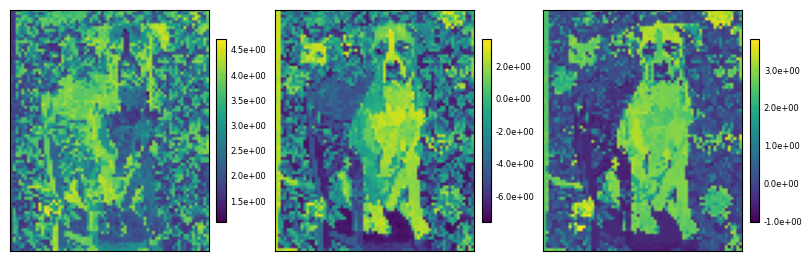

In [26]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


### Generator

- Now we want to see how the spectra changes as we traverse the latent space


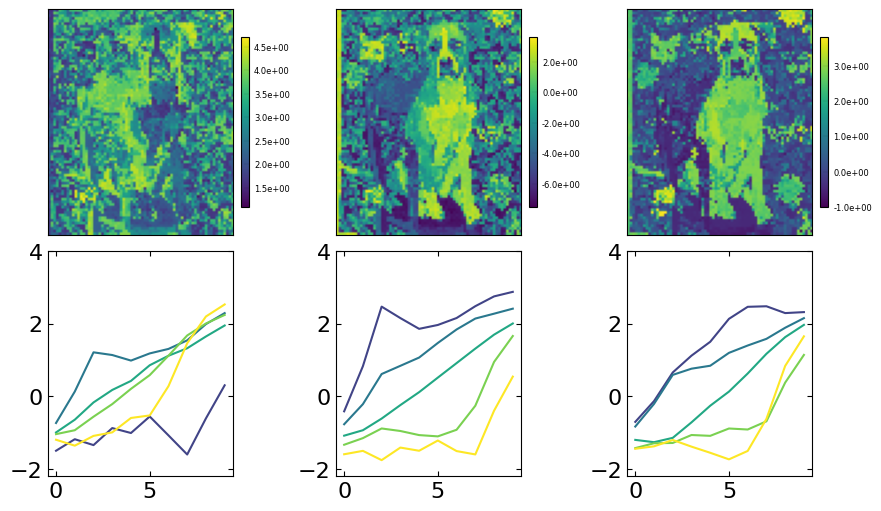

In [27]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


## Recurrent Neural Network Autoencoders


- The above example did not consider the temporal information in the data.


- This can be improved by using a recurrent neural network that processes each time step sequentially.


- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/LSTM%20Node.png?raw=true)


### Builds the model


In [28]:
latent_dim = 12

# encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [29]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


### Dataloader


In [30]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [31]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 22.29it/s]


Epoch 0, Train Loss: 2.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 135.22it/s]


Epoch 1, Train Loss: 2.2313
.............................


100%|██████████| 19/19 [00:00<00:00, 135.93it/s]


Epoch 2, Train Loss: 2.2214
.............................


100%|██████████| 19/19 [00:00<00:00, 132.38it/s]


Epoch 3, Train Loss: 2.2117
.............................


100%|██████████| 19/19 [00:00<00:00, 120.90it/s]


Epoch 4, Train Loss: 2.2020
.............................


100%|██████████| 19/19 [00:00<00:00, 128.51it/s]


Epoch 5, Train Loss: 2.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 131.20it/s]


Epoch 6, Train Loss: 2.1826
.............................


100%|██████████| 19/19 [00:00<00:00, 134.23it/s]


Epoch 7, Train Loss: 2.1729
.............................


100%|██████████| 19/19 [00:00<00:00, 130.61it/s]


Epoch 8, Train Loss: 2.1631
.............................


100%|██████████| 19/19 [00:00<00:00, 130.22it/s]


Epoch 9, Train Loss: 2.1533
.............................


100%|██████████| 19/19 [00:00<00:00, 116.07it/s]


Epoch 10, Train Loss: 2.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 130.48it/s]


Epoch 11, Train Loss: 2.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 125.96it/s]


Epoch 12, Train Loss: 2.1230
.............................


100%|██████████| 19/19 [00:00<00:00, 131.60it/s]


Epoch 13, Train Loss: 2.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 133.39it/s]


Epoch 14, Train Loss: 2.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 130.90it/s]


Epoch 15, Train Loss: 2.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 129.46it/s]


Epoch 16, Train Loss: 2.0799
.............................


100%|██████████| 19/19 [00:00<00:00, 111.63it/s]


Epoch 17, Train Loss: 2.0686
.............................


100%|██████████| 19/19 [00:00<00:00, 128.40it/s]


Epoch 18, Train Loss: 2.0569
.............................


100%|██████████| 19/19 [00:00<00:00, 79.70it/s]


Epoch 19, Train Loss: 2.0449
.............................


100%|██████████| 19/19 [00:00<00:00, 84.85it/s]


Epoch 20, Train Loss: 2.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 80.12it/s]


Epoch 21, Train Loss: 2.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 79.83it/s]


Epoch 22, Train Loss: 2.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 86.22it/s]


Epoch 23, Train Loss: 1.9937
.............................


100%|██████████| 19/19 [00:00<00:00, 87.36it/s]


Epoch 24, Train Loss: 1.9799
.............................


100%|██████████| 19/19 [00:00<00:00, 81.38it/s]


Epoch 25, Train Loss: 1.9658
.............................


100%|██████████| 19/19 [00:00<00:00, 84.31it/s]


Epoch 26, Train Loss: 1.9512
.............................


100%|██████████| 19/19 [00:00<00:00, 78.19it/s]


Epoch 27, Train Loss: 1.9362
.............................


100%|██████████| 19/19 [00:00<00:00, 90.40it/s]


Epoch 28, Train Loss: 1.9208
.............................


100%|██████████| 19/19 [00:00<00:00, 133.98it/s]


Epoch 29, Train Loss: 1.9050
.............................


100%|██████████| 19/19 [00:00<00:00, 131.68it/s]


Epoch 30, Train Loss: 1.8887
.............................


100%|██████████| 19/19 [00:00<00:00, 130.55it/s]


Epoch 31, Train Loss: 1.8719
.............................


100%|██████████| 19/19 [00:00<00:00, 132.93it/s]


Epoch 32, Train Loss: 1.8548
.............................


100%|██████████| 19/19 [00:00<00:00, 115.79it/s]


Epoch 33, Train Loss: 1.8372
.............................


100%|██████████| 19/19 [00:00<00:00, 133.20it/s]


Epoch 34, Train Loss: 1.8192
.............................


100%|██████████| 19/19 [00:00<00:00, 131.36it/s]


Epoch 35, Train Loss: 1.8008
.............................


100%|██████████| 19/19 [00:00<00:00, 132.42it/s]


Epoch 36, Train Loss: 1.7821
.............................


100%|██████████| 19/19 [00:00<00:00, 129.15it/s]


Epoch 37, Train Loss: 1.7630
.............................


100%|██████████| 19/19 [00:00<00:00, 133.50it/s]


Epoch 38, Train Loss: 1.7436
.............................


100%|██████████| 19/19 [00:00<00:00, 120.67it/s]


Epoch 39, Train Loss: 1.7240
.............................


100%|██████████| 19/19 [00:00<00:00, 128.09it/s]


Epoch 40, Train Loss: 1.7042
.............................


100%|██████████| 19/19 [00:00<00:00, 134.41it/s]


Epoch 41, Train Loss: 1.6842
.............................


100%|██████████| 19/19 [00:00<00:00, 129.88it/s]


Epoch 42, Train Loss: 1.6642
.............................


100%|██████████| 19/19 [00:00<00:00, 133.15it/s]


Epoch 43, Train Loss: 1.6441
.............................


100%|██████████| 19/19 [00:00<00:00, 132.13it/s]


Epoch 44, Train Loss: 1.6241
.............................


100%|██████████| 19/19 [00:00<00:00, 132.29it/s]


Epoch 45, Train Loss: 1.6043
.............................


100%|██████████| 19/19 [00:00<00:00, 121.43it/s]


Epoch 46, Train Loss: 1.5846
.............................


100%|██████████| 19/19 [00:00<00:00, 122.05it/s]


Epoch 47, Train Loss: 1.5652
.............................


100%|██████████| 19/19 [00:00<00:00, 130.71it/s]


Epoch 48, Train Loss: 1.5462
.............................


100%|██████████| 19/19 [00:00<00:00, 130.70it/s]


Epoch 49, Train Loss: 1.5276
.............................


100%|██████████| 19/19 [00:00<00:00, 132.90it/s]


Epoch 50, Train Loss: 1.5093
.............................


100%|██████████| 19/19 [00:00<00:00, 131.43it/s]


Epoch 51, Train Loss: 1.4916
.............................


100%|██████████| 19/19 [00:00<00:00, 133.04it/s]


Epoch 52, Train Loss: 1.4743
.............................


100%|██████████| 19/19 [00:00<00:00, 117.75it/s]


Epoch 53, Train Loss: 1.4574
.............................


100%|██████████| 19/19 [00:00<00:00, 131.35it/s]


Epoch 54, Train Loss: 1.4410
.............................


100%|██████████| 19/19 [00:00<00:00, 132.80it/s]


Epoch 55, Train Loss: 1.4251
.............................


100%|██████████| 19/19 [00:00<00:00, 133.70it/s]


Epoch 56, Train Loss: 1.4096
.............................


100%|██████████| 19/19 [00:00<00:00, 131.01it/s]


Epoch 57, Train Loss: 1.3944
.............................


100%|██████████| 19/19 [00:00<00:00, 123.31it/s]


Epoch 58, Train Loss: 1.3796
.............................


100%|██████████| 19/19 [00:00<00:00, 128.05it/s]


Epoch 59, Train Loss: 1.3650
.............................


100%|██████████| 19/19 [00:00<00:00, 123.60it/s]


Epoch 60, Train Loss: 1.3507
.............................


100%|██████████| 19/19 [00:00<00:00, 134.64it/s]


Epoch 61, Train Loss: 1.3366
.............................


100%|██████████| 19/19 [00:00<00:00, 129.44it/s]


Epoch 62, Train Loss: 1.3226
.............................


100%|██████████| 19/19 [00:00<00:00, 130.93it/s]


Epoch 63, Train Loss: 1.3087
.............................


100%|██████████| 19/19 [00:00<00:00, 134.74it/s]


Epoch 64, Train Loss: 1.2948
.............................


100%|██████████| 19/19 [00:00<00:00, 129.42it/s]


Epoch 65, Train Loss: 1.2810
.............................


100%|██████████| 19/19 [00:00<00:00, 133.01it/s]


Epoch 66, Train Loss: 1.2672
.............................


100%|██████████| 19/19 [00:00<00:00, 119.39it/s]


Epoch 67, Train Loss: 1.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 130.40it/s]


Epoch 68, Train Loss: 1.2395
.............................


100%|██████████| 19/19 [00:00<00:00, 129.28it/s]


Epoch 69, Train Loss: 1.2255
.............................


100%|██████████| 19/19 [00:00<00:00, 132.67it/s]


Epoch 70, Train Loss: 1.2115
.............................


100%|██████████| 19/19 [00:00<00:00, 129.43it/s]


Epoch 71, Train Loss: 1.1974
.............................


100%|██████████| 19/19 [00:00<00:00, 128.68it/s]


Epoch 72, Train Loss: 1.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 128.56it/s]


Epoch 73, Train Loss: 1.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 117.61it/s]


Epoch 74, Train Loss: 1.1546
.............................


100%|██████████| 19/19 [00:00<00:00, 129.39it/s]


Epoch 75, Train Loss: 1.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 132.16it/s]


Epoch 76, Train Loss: 1.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 131.26it/s]


Epoch 77, Train Loss: 1.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 125.61it/s]


Epoch 78, Train Loss: 1.0962
.............................


100%|██████████| 19/19 [00:00<00:00, 126.67it/s]


Epoch 79, Train Loss: 1.0814
.............................


100%|██████████| 19/19 [00:00<00:00, 120.96it/s]


Epoch 80, Train Loss: 1.0666
.............................


100%|██████████| 19/19 [00:00<00:00, 134.08it/s]


Epoch 81, Train Loss: 1.0516
.............................


100%|██████████| 19/19 [00:00<00:00, 130.67it/s]


Epoch 82, Train Loss: 1.0367
.............................


100%|██████████| 19/19 [00:00<00:00, 130.27it/s]


Epoch 83, Train Loss: 1.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 132.93it/s]


Epoch 84, Train Loss: 1.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 128.74it/s]


Epoch 85, Train Loss: 0.9916
.............................


100%|██████████| 19/19 [00:00<00:00, 123.87it/s]


Epoch 86, Train Loss: 0.9766
.............................


100%|██████████| 19/19 [00:00<00:00, 117.35it/s]


Epoch 87, Train Loss: 0.9615
.............................


100%|██████████| 19/19 [00:00<00:00, 129.19it/s]


Epoch 88, Train Loss: 0.9465
.............................


100%|██████████| 19/19 [00:00<00:00, 127.12it/s]


Epoch 89, Train Loss: 0.9314
.............................


100%|██████████| 19/19 [00:00<00:00, 128.90it/s]


Epoch 90, Train Loss: 0.9164
.............................


100%|██████████| 19/19 [00:00<00:00, 129.40it/s]


Epoch 91, Train Loss: 0.9015
.............................


100%|██████████| 19/19 [00:00<00:00, 127.68it/s]


Epoch 92, Train Loss: 0.8866
.............................


100%|██████████| 19/19 [00:00<00:00, 131.30it/s]


Epoch 93, Train Loss: 0.8717
.............................


100%|██████████| 19/19 [00:00<00:00, 98.69it/s] 


Epoch 94, Train Loss: 0.8569
.............................


100%|██████████| 19/19 [00:00<00:00, 82.77it/s]


Epoch 95, Train Loss: 0.8422
.............................


100%|██████████| 19/19 [00:00<00:00, 83.90it/s]


Epoch 96, Train Loss: 0.8275
.............................


100%|██████████| 19/19 [00:00<00:00, 83.10it/s]


Epoch 97, Train Loss: 0.8129
.............................


100%|██████████| 19/19 [00:00<00:00, 78.89it/s]


Epoch 98, Train Loss: 0.7984
.............................


100%|██████████| 19/19 [00:00<00:00, 83.05it/s]


Epoch 99, Train Loss: 0.7840
.............................


100%|██████████| 19/19 [00:00<00:00, 85.11it/s]


Epoch 100, Train Loss: 0.7697
.............................


100%|██████████| 19/19 [00:00<00:00, 81.28it/s]


Epoch 101, Train Loss: 0.7555
.............................


100%|██████████| 19/19 [00:00<00:00, 77.94it/s]


Epoch 102, Train Loss: 0.7414
.............................


100%|██████████| 19/19 [00:00<00:00, 77.11it/s]


Epoch 103, Train Loss: 0.7274
.............................


100%|██████████| 19/19 [00:00<00:00, 130.10it/s]


Epoch 104, Train Loss: 0.7135
.............................


100%|██████████| 19/19 [00:00<00:00, 126.66it/s]


Epoch 105, Train Loss: 0.6997
.............................


100%|██████████| 19/19 [00:00<00:00, 131.39it/s]


Epoch 106, Train Loss: 0.6861
.............................


100%|██████████| 19/19 [00:00<00:00, 129.57it/s]


Epoch 107, Train Loss: 0.6726
.............................


100%|██████████| 19/19 [00:00<00:00, 127.97it/s]


Epoch 108, Train Loss: 0.6592
.............................


100%|██████████| 19/19 [00:00<00:00, 119.61it/s]


Epoch 109, Train Loss: 0.6459
.............................


100%|██████████| 19/19 [00:00<00:00, 130.04it/s]


Epoch 110, Train Loss: 0.6328
.............................


100%|██████████| 19/19 [00:00<00:00, 128.42it/s]


Epoch 111, Train Loss: 0.6199
.............................


100%|██████████| 19/19 [00:00<00:00, 124.74it/s]


Epoch 112, Train Loss: 0.6070
.............................


100%|██████████| 19/19 [00:00<00:00, 122.74it/s]


Epoch 113, Train Loss: 0.5944
.............................


100%|██████████| 19/19 [00:00<00:00, 132.12it/s]


Epoch 114, Train Loss: 0.5818
.............................


100%|██████████| 19/19 [00:00<00:00, 131.59it/s]


Epoch 115, Train Loss: 0.5695
.............................


100%|██████████| 19/19 [00:00<00:00, 117.40it/s]


Epoch 116, Train Loss: 0.5573
.............................


100%|██████████| 19/19 [00:00<00:00, 126.12it/s]


Epoch 117, Train Loss: 0.5453
.............................


100%|██████████| 19/19 [00:00<00:00, 132.32it/s]


Epoch 118, Train Loss: 0.5334
.............................


100%|██████████| 19/19 [00:00<00:00, 125.49it/s]


Epoch 119, Train Loss: 0.5218
.............................


100%|██████████| 19/19 [00:00<00:00, 129.52it/s]


Epoch 120, Train Loss: 0.5104
.............................


100%|██████████| 19/19 [00:00<00:00, 128.73it/s]


Epoch 121, Train Loss: 0.4991
.............................


100%|██████████| 19/19 [00:00<00:00, 129.99it/s]


Epoch 122, Train Loss: 0.4881
.............................


100%|██████████| 19/19 [00:00<00:00, 118.28it/s]


Epoch 123, Train Loss: 0.4774
.............................


100%|██████████| 19/19 [00:00<00:00, 127.14it/s]


Epoch 124, Train Loss: 0.4668
.............................


100%|██████████| 19/19 [00:00<00:00, 127.34it/s]


Epoch 125, Train Loss: 0.4566
.............................


100%|██████████| 19/19 [00:00<00:00, 126.28it/s]


Epoch 126, Train Loss: 0.4466
.............................


100%|██████████| 19/19 [00:00<00:00, 128.25it/s]


Epoch 127, Train Loss: 0.4369
.............................


100%|██████████| 19/19 [00:00<00:00, 130.10it/s]


Epoch 128, Train Loss: 0.4274
.............................


100%|██████████| 19/19 [00:00<00:00, 119.28it/s]


Epoch 129, Train Loss: 0.4183
.............................


100%|██████████| 19/19 [00:00<00:00, 129.36it/s]


Epoch 130, Train Loss: 0.4094
.............................


100%|██████████| 19/19 [00:00<00:00, 128.20it/s]


Epoch 131, Train Loss: 0.4008
.............................


100%|██████████| 19/19 [00:00<00:00, 125.39it/s]


Epoch 132, Train Loss: 0.3925
.............................


100%|██████████| 19/19 [00:00<00:00, 128.27it/s]


Epoch 133, Train Loss: 0.3845
.............................


100%|██████████| 19/19 [00:00<00:00, 128.96it/s]


Epoch 134, Train Loss: 0.3767
.............................


100%|██████████| 19/19 [00:00<00:00, 126.06it/s]


Epoch 135, Train Loss: 0.3692
.............................


100%|██████████| 19/19 [00:00<00:00, 116.51it/s]


Epoch 136, Train Loss: 0.3620
.............................


100%|██████████| 19/19 [00:00<00:00, 125.95it/s]


Epoch 137, Train Loss: 0.3550
.............................


100%|██████████| 19/19 [00:00<00:00, 131.81it/s]


Epoch 138, Train Loss: 0.3482
.............................


100%|██████████| 19/19 [00:00<00:00, 114.98it/s]


Epoch 139, Train Loss: 0.3417
.............................


100%|██████████| 19/19 [00:00<00:00, 126.10it/s]


Epoch 140, Train Loss: 0.3354
.............................


100%|██████████| 19/19 [00:00<00:00, 127.49it/s]


Epoch 141, Train Loss: 0.3294
.............................


100%|██████████| 19/19 [00:00<00:00, 131.17it/s]


Epoch 142, Train Loss: 0.3235
.............................


100%|██████████| 19/19 [00:00<00:00, 119.36it/s]


Epoch 143, Train Loss: 0.3179
.............................


100%|██████████| 19/19 [00:00<00:00, 129.95it/s]


Epoch 144, Train Loss: 0.3124
.............................


100%|██████████| 19/19 [00:00<00:00, 127.41it/s]


Epoch 145, Train Loss: 0.3072
.............................


100%|██████████| 19/19 [00:00<00:00, 115.36it/s]


Epoch 146, Train Loss: 0.3021
.............................


100%|██████████| 19/19 [00:00<00:00, 127.99it/s]


Epoch 147, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 129.55it/s]


Epoch 148, Train Loss: 0.2926
.............................


100%|██████████| 19/19 [00:00<00:00, 119.42it/s]


Epoch 149, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 126.15it/s]


Epoch 150, Train Loss: 0.2837
.............................


100%|██████████| 19/19 [00:00<00:00, 134.01it/s]


Epoch 151, Train Loss: 0.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 124.72it/s]


Epoch 152, Train Loss: 0.2754
.............................


100%|██████████| 19/19 [00:00<00:00, 126.87it/s]


Epoch 153, Train Loss: 0.2716
.............................


100%|██████████| 19/19 [00:00<00:00, 129.60it/s]


Epoch 154, Train Loss: 0.2678
.............................


100%|██████████| 19/19 [00:00<00:00, 129.42it/s]


Epoch 155, Train Loss: 0.2642
.............................


100%|██████████| 19/19 [00:00<00:00, 115.46it/s]


Epoch 156, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 129.06it/s]


Epoch 157, Train Loss: 0.2574
.............................


100%|██████████| 19/19 [00:00<00:00, 124.86it/s]


Epoch 158, Train Loss: 0.2542
.............................


100%|██████████| 19/19 [00:00<00:00, 128.87it/s]


Epoch 159, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 126.52it/s]


Epoch 160, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 127.88it/s]


Epoch 161, Train Loss: 0.2453
.............................


100%|██████████| 19/19 [00:00<00:00, 127.07it/s]


Epoch 162, Train Loss: 0.2425
.............................


100%|██████████| 19/19 [00:00<00:00, 116.32it/s]


Epoch 163, Train Loss: 0.2399
.............................


100%|██████████| 19/19 [00:00<00:00, 118.77it/s]


Epoch 164, Train Loss: 0.2374
.............................


100%|██████████| 19/19 [00:00<00:00, 126.54it/s]


Epoch 165, Train Loss: 0.2349
.............................


100%|██████████| 19/19 [00:00<00:00, 121.70it/s]


Epoch 166, Train Loss: 0.2326
.............................


100%|██████████| 19/19 [00:00<00:00, 126.64it/s]


Epoch 167, Train Loss: 0.2303
.............................


100%|██████████| 19/19 [00:00<00:00, 96.58it/s] 


Epoch 168, Train Loss: 0.2281
.............................


100%|██████████| 19/19 [00:00<00:00, 74.55it/s]


Epoch 169, Train Loss: 0.2261
.............................


100%|██████████| 19/19 [00:00<00:00, 86.17it/s]


Epoch 170, Train Loss: 0.2241
.............................


100%|██████████| 19/19 [00:00<00:00, 82.37it/s]


Epoch 171, Train Loss: 0.2221
.............................


100%|██████████| 19/19 [00:00<00:00, 87.53it/s]


Epoch 172, Train Loss: 0.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 73.81it/s]


Epoch 173, Train Loss: 0.2185
.............................


100%|██████████| 19/19 [00:00<00:00, 30.30it/s]


Epoch 174, Train Loss: 0.2167
.............................


100%|██████████| 19/19 [00:00<00:00, 54.52it/s]


Epoch 175, Train Loss: 0.2151
.............................


100%|██████████| 19/19 [00:00<00:00, 77.12it/s]


Epoch 176, Train Loss: 0.2135
.............................


100%|██████████| 19/19 [00:00<00:00, 114.36it/s]


Epoch 177, Train Loss: 0.2119
.............................


100%|██████████| 19/19 [00:00<00:00, 128.52it/s]


Epoch 178, Train Loss: 0.2104
.............................


100%|██████████| 19/19 [00:00<00:00, 129.39it/s]


Epoch 179, Train Loss: 0.2090
.............................


100%|██████████| 19/19 [00:00<00:00, 126.89it/s]


Epoch 180, Train Loss: 0.2076
.............................


100%|██████████| 19/19 [00:00<00:00, 127.98it/s]


Epoch 181, Train Loss: 0.2062
.............................


100%|██████████| 19/19 [00:00<00:00, 116.00it/s]


Epoch 182, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 128.77it/s]


Epoch 183, Train Loss: 0.2036
.............................


100%|██████████| 19/19 [00:00<00:00, 124.88it/s]


Epoch 184, Train Loss: 0.2024
.............................


100%|██████████| 19/19 [00:00<00:00, 125.90it/s]


Epoch 185, Train Loss: 0.2012
.............................


100%|██████████| 19/19 [00:00<00:00, 126.22it/s]


Epoch 186, Train Loss: 0.2000
.............................


100%|██████████| 19/19 [00:00<00:00, 127.28it/s]


Epoch 187, Train Loss: 0.1989
.............................


100%|██████████| 19/19 [00:00<00:00, 111.09it/s]


Epoch 188, Train Loss: 0.1977
.............................


100%|██████████| 19/19 [00:00<00:00, 124.40it/s]


Epoch 189, Train Loss: 0.1967
.............................


100%|██████████| 19/19 [00:00<00:00, 124.54it/s]


Epoch 190, Train Loss: 0.1956
.............................


100%|██████████| 19/19 [00:00<00:00, 125.98it/s]


Epoch 191, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 124.38it/s]


Epoch 192, Train Loss: 0.1935
.............................


100%|██████████| 19/19 [00:00<00:00, 127.07it/s]


Epoch 193, Train Loss: 0.1925
.............................


100%|██████████| 19/19 [00:00<00:00, 127.24it/s]


Epoch 194, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 117.95it/s]


Epoch 195, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 114.98it/s]


Epoch 196, Train Loss: 0.1897
.............................


100%|██████████| 19/19 [00:00<00:00, 125.84it/s]


Epoch 197, Train Loss: 0.1888
.............................


100%|██████████| 19/19 [00:00<00:00, 130.98it/s]


Epoch 198, Train Loss: 0.1879
.............................


100%|██████████| 19/19 [00:00<00:00, 128.26it/s]


Epoch 199, Train Loss: 0.1871
.............................


100%|██████████| 19/19 [00:00<00:00, 109.44it/s]


Epoch 200, Train Loss: 0.1862
.............................


100%|██████████| 19/19 [00:00<00:00, 116.57it/s]


Epoch 201, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 128.83it/s]


Epoch 202, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 127.59it/s]


Epoch 203, Train Loss: 0.1839
.............................


100%|██████████| 19/19 [00:00<00:00, 131.32it/s]


Epoch 204, Train Loss: 0.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 127.01it/s]


Epoch 205, Train Loss: 0.1825
.............................


100%|██████████| 19/19 [00:00<00:00, 129.09it/s]


Epoch 206, Train Loss: 0.1818
.............................


100%|██████████| 19/19 [00:00<00:00, 124.85it/s]


Epoch 207, Train Loss: 0.1812
.............................


100%|██████████| 19/19 [00:00<00:00, 117.45it/s]


Epoch 208, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 125.21it/s]


Epoch 209, Train Loss: 0.1799
.............................


100%|██████████| 19/19 [00:00<00:00, 126.89it/s]


Epoch 210, Train Loss: 0.1793
.............................


100%|██████████| 19/19 [00:00<00:00, 126.32it/s]


Epoch 211, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 127.17it/s]


Epoch 212, Train Loss: 0.1781
.............................


100%|██████████| 19/19 [00:00<00:00, 126.20it/s]


Epoch 213, Train Loss: 0.1776
.............................


100%|██████████| 19/19 [00:00<00:00, 126.71it/s]


Epoch 214, Train Loss: 0.1771
.............................


100%|██████████| 19/19 [00:00<00:00, 113.95it/s]


Epoch 215, Train Loss: 0.1765
.............................


100%|██████████| 19/19 [00:00<00:00, 126.10it/s]


Epoch 216, Train Loss: 0.1760
.............................


100%|██████████| 19/19 [00:00<00:00, 126.51it/s]


Epoch 217, Train Loss: 0.1755
.............................


100%|██████████| 19/19 [00:00<00:00, 122.92it/s]


Epoch 218, Train Loss: 0.1750
.............................


100%|██████████| 19/19 [00:00<00:00, 119.30it/s]


Epoch 219, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 127.44it/s]


Epoch 220, Train Loss: 0.1741
.............................


100%|██████████| 19/19 [00:00<00:00, 113.32it/s]


Epoch 221, Train Loss: 0.1736
.............................


100%|██████████| 19/19 [00:00<00:00, 124.55it/s]


Epoch 222, Train Loss: 0.1732
.............................


100%|██████████| 19/19 [00:00<00:00, 126.79it/s]


Epoch 223, Train Loss: 0.1728
.............................


100%|██████████| 19/19 [00:00<00:00, 128.37it/s]


Epoch 224, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 128.32it/s]


Epoch 225, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 127.76it/s]


Epoch 226, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 121.46it/s]


Epoch 227, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 112.43it/s]


Epoch 228, Train Loss: 0.1707
.............................


100%|██████████| 19/19 [00:00<00:00, 124.66it/s]


Epoch 229, Train Loss: 0.1704
.............................


100%|██████████| 19/19 [00:00<00:00, 118.65it/s]


Epoch 230, Train Loss: 0.1700
.............................


100%|██████████| 19/19 [00:00<00:00, 122.66it/s]


Epoch 231, Train Loss: 0.1696
.............................


100%|██████████| 19/19 [00:00<00:00, 129.97it/s]


Epoch 232, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 120.76it/s]


Epoch 233, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 116.81it/s]


Epoch 234, Train Loss: 0.1685
.............................


100%|██████████| 19/19 [00:00<00:00, 121.46it/s]


Epoch 235, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 125.73it/s]


Epoch 236, Train Loss: 0.1678
.............................


100%|██████████| 19/19 [00:00<00:00, 123.55it/s]


Epoch 237, Train Loss: 0.1675
.............................


100%|██████████| 19/19 [00:00<00:00, 120.26it/s]


Epoch 238, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 120.81it/s]


Epoch 239, Train Loss: 0.1668
.............................


100%|██████████| 19/19 [00:00<00:00, 102.48it/s]


Epoch 240, Train Loss: 0.1665
.............................


100%|██████████| 19/19 [00:00<00:00, 79.44it/s]


Epoch 241, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 85.17it/s]


Epoch 242, Train Loss: 0.1659
.............................


100%|██████████| 19/19 [00:00<00:00, 85.43it/s]


Epoch 243, Train Loss: 0.1655
.............................


100%|██████████| 19/19 [00:00<00:00, 85.48it/s]


Epoch 244, Train Loss: 0.1652
.............................


100%|██████████| 19/19 [00:00<00:00, 82.51it/s]


Epoch 245, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 88.07it/s]


Epoch 246, Train Loss: 0.1646
.............................


100%|██████████| 19/19 [00:00<00:00, 80.64it/s]


Epoch 247, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 74.78it/s]


Epoch 248, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 77.99it/s]


Epoch 249, Train Loss: 0.1637
.............................


100%|██████████| 19/19 [00:00<00:00, 75.40it/s]


Epoch 250, Train Loss: 0.1634
.............................


100%|██████████| 19/19 [00:00<00:00, 125.84it/s]


Epoch 251, Train Loss: 0.1631
.............................


100%|██████████| 19/19 [00:00<00:00, 118.34it/s]


Epoch 252, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 121.18it/s]


Epoch 253, Train Loss: 0.1625
.............................


100%|██████████| 19/19 [00:00<00:00, 117.57it/s]


Epoch 254, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 121.18it/s]


Epoch 255, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 105.64it/s]


Epoch 256, Train Loss: 0.1616
.............................


100%|██████████| 19/19 [00:00<00:00, 121.47it/s]


Epoch 257, Train Loss: 0.1614
.............................


100%|██████████| 19/19 [00:00<00:00, 124.95it/s]


Epoch 258, Train Loss: 0.1611
.............................


100%|██████████| 19/19 [00:00<00:00, 128.09it/s]


Epoch 259, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 124.17it/s]


Epoch 260, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 124.97it/s]


Epoch 261, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 115.98it/s]


Epoch 262, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 126.87it/s]


Epoch 263, Train Loss: 0.1597
.............................


100%|██████████| 19/19 [00:00<00:00, 121.07it/s]


Epoch 264, Train Loss: 0.1594
.............................


100%|██████████| 19/19 [00:00<00:00, 116.73it/s]


Epoch 265, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 124.09it/s]


Epoch 266, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 123.78it/s]


Epoch 267, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 118.66it/s]


Epoch 268, Train Loss: 0.1583
.............................


100%|██████████| 19/19 [00:00<00:00, 123.37it/s]


Epoch 269, Train Loss: 0.1580
.............................


100%|██████████| 19/19 [00:00<00:00, 122.14it/s]


Epoch 270, Train Loss: 0.1577
.............................


100%|██████████| 19/19 [00:00<00:00, 125.43it/s]


Epoch 271, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 126.26it/s]


Epoch 272, Train Loss: 0.1571
.............................


100%|██████████| 19/19 [00:00<00:00, 126.87it/s]


Epoch 273, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 36.84it/s]


Epoch 274, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 123.35it/s]


Epoch 275, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 127.98it/s]


Epoch 276, Train Loss: 0.1560
.............................


100%|██████████| 19/19 [00:00<00:00, 123.53it/s]


Epoch 277, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 120.69it/s]


Epoch 278, Train Loss: 0.1555
.............................


100%|██████████| 19/19 [00:00<00:00, 112.73it/s]


Epoch 279, Train Loss: 0.1552
.............................


100%|██████████| 19/19 [00:00<00:00, 124.93it/s]


Epoch 280, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 122.50it/s]


Epoch 281, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 124.50it/s]


Epoch 282, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 124.48it/s]


Epoch 283, Train Loss: 0.1541
.............................


100%|██████████| 19/19 [00:00<00:00, 123.08it/s]


Epoch 284, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 125.50it/s]


Epoch 285, Train Loss: 0.1536
.............................


100%|██████████| 19/19 [00:00<00:00, 112.83it/s]


Epoch 286, Train Loss: 0.1533
.............................


100%|██████████| 19/19 [00:00<00:00, 121.96it/s]


Epoch 287, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 120.80it/s]


Epoch 288, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 121.78it/s]


Epoch 289, Train Loss: 0.1525
.............................


100%|██████████| 19/19 [00:00<00:00, 123.61it/s]


Epoch 290, Train Loss: 0.1522
.............................


100%|██████████| 19/19 [00:00<00:00, 121.98it/s]


Epoch 291, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 112.78it/s]


Epoch 292, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 121.39it/s]


Epoch 293, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 123.69it/s]


Epoch 294, Train Loss: 0.1511
.............................


100%|██████████| 19/19 [00:00<00:00, 124.09it/s]


Epoch 295, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 127.28it/s]


Epoch 296, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 120.97it/s]


Epoch 297, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 124.13it/s]


Epoch 298, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 112.33it/s]


Epoch 299, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 123.35it/s]


Epoch 300, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 123.32it/s]


Epoch 301, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 124.79it/s]


Epoch 302, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 121.25it/s]


Epoch 303, Train Loss: 0.1488
.............................


100%|██████████| 19/19 [00:00<00:00, 122.85it/s]


Epoch 304, Train Loss: 0.1485
.............................


100%|██████████| 19/19 [00:00<00:00, 98.39it/s]


Epoch 305, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 124.08it/s]


Epoch 306, Train Loss: 0.1480
.............................


100%|██████████| 19/19 [00:00<00:00, 119.70it/s]


Epoch 307, Train Loss: 0.1477
.............................


100%|██████████| 19/19 [00:00<00:00, 121.23it/s]


Epoch 308, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 122.85it/s]


Epoch 309, Train Loss: 0.1472
.............................


100%|██████████| 19/19 [00:00<00:00, 123.37it/s]


Epoch 310, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 74.32it/s]


Epoch 311, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 83.62it/s]


Epoch 312, Train Loss: 0.1465
.............................


100%|██████████| 19/19 [00:00<00:00, 83.09it/s]


Epoch 313, Train Loss: 0.1462
.............................


100%|██████████| 19/19 [00:00<00:00, 79.62it/s]


Epoch 314, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 83.72it/s]


Epoch 315, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 82.97it/s]


Epoch 316, Train Loss: 0.1455
.............................


100%|██████████| 19/19 [00:00<00:00, 79.83it/s]


Epoch 317, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 78.65it/s]


Epoch 318, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 80.39it/s]


Epoch 319, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 77.87it/s]


Epoch 320, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 96.21it/s]

Epoch 321, Train Loss: 0.1442
.............................



100%|██████████| 19/19 [00:00<00:00, 124.93it/s]


Epoch 322, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 121.67it/s]


Epoch 323, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 123.67it/s]


Epoch 324, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 121.62it/s]


Epoch 325, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 115.89it/s]


Epoch 326, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 124.14it/s]


Epoch 327, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 128.01it/s]


Epoch 328, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 124.67it/s]


Epoch 329, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 125.83it/s]


Epoch 330, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 114.25it/s]


Epoch 331, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 120.33it/s]


Epoch 332, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 104.13it/s]


Epoch 333, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 124.40it/s]


Epoch 334, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 125.51it/s]


Epoch 335, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 122.69it/s]


Epoch 336, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 123.52it/s]


Epoch 337, Train Loss: 0.1405
.............................


100%|██████████| 19/19 [00:00<00:00, 127.66it/s]


Epoch 338, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 111.94it/s]


Epoch 339, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 122.72it/s]


Epoch 340, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 122.25it/s]


Epoch 341, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 121.62it/s]


Epoch 342, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 121.03it/s]


Epoch 343, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 125.26it/s]


Epoch 344, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 122.34it/s]


Epoch 345, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 113.65it/s]


Epoch 346, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 123.13it/s]


Epoch 347, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 122.60it/s]


Epoch 348, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 116.72it/s]


Epoch 349, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 124.78it/s]


Epoch 350, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 114.21it/s]


Epoch 351, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 113.50it/s]


Epoch 352, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 121.54it/s]


Epoch 353, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 125.48it/s]


Epoch 354, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 124.22it/s]


Epoch 355, Train Loss: 0.1366
.............................


100%|██████████| 19/19 [00:00<00:00, 127.29it/s]


Epoch 356, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 123.75it/s]


Epoch 357, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 123.63it/s]


Epoch 358, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 112.11it/s]


Epoch 359, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 121.33it/s]


Epoch 360, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 120.32it/s]


Epoch 361, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 110.46it/s]


Epoch 362, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 119.83it/s]


Epoch 363, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 123.09it/s]


Epoch 364, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 110.00it/s]


Epoch 365, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 122.91it/s]


Epoch 366, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 117.34it/s]


Epoch 367, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 120.26it/s]


Epoch 368, Train Loss: 0.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 124.72it/s]


Epoch 369, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 123.56it/s]


Epoch 370, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 112.45it/s]


Epoch 371, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 119.33it/s]


Epoch 372, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 113.65it/s]


Epoch 373, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 123.45it/s]


Epoch 374, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 105.69it/s]


Epoch 375, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 122.62it/s]


Epoch 376, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 111.68it/s]


Epoch 377, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 120.75it/s]


Epoch 378, Train Loss: 0.1324
.............................


100%|██████████| 19/19 [00:00<00:00, 119.28it/s]


Epoch 379, Train Loss: 0.1322
.............................


100%|██████████| 19/19 [00:00<00:00, 123.97it/s]


Epoch 380, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 125.65it/s]


Epoch 381, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 121.54it/s]


Epoch 382, Train Loss: 0.1317
.............................


100%|██████████| 19/19 [00:00<00:00, 80.50it/s]


Epoch 383, Train Loss: 0.1315
.............................


100%|██████████| 19/19 [00:00<00:00, 77.31it/s]


Epoch 384, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 81.11it/s]


Epoch 385, Train Loss: 0.1312
.............................


100%|██████████| 19/19 [00:00<00:00, 84.68it/s]


Epoch 386, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 82.09it/s]


Epoch 387, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 76.74it/s]


Epoch 388, Train Loss: 0.1307
.............................


100%|██████████| 19/19 [00:00<00:00, 81.33it/s]


Epoch 389, Train Loss: 0.1306
.............................


100%|██████████| 19/19 [00:00<00:00, 75.56it/s]


Epoch 390, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 79.11it/s]


Epoch 391, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 80.11it/s]


Epoch 392, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 77.14it/s]


Epoch 393, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 112.36it/s]


Epoch 394, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 119.47it/s]


Epoch 395, Train Loss: 0.1296
.............................


100%|██████████| 19/19 [00:00<00:00, 117.85it/s]


Epoch 396, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 117.99it/s]


Epoch 397, Train Loss: 0.1293
.............................


100%|██████████| 19/19 [00:00<00:00, 108.61it/s]


Epoch 398, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 122.32it/s]


Epoch 399, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 122.77it/s]


Epoch 400, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 124.43it/s]


Epoch 401, Train Loss: 0.1288
.............................


100%|██████████| 19/19 [00:00<00:00, 120.57it/s]


Epoch 402, Train Loss: 0.1286
.............................


100%|██████████| 19/19 [00:00<00:00, 119.83it/s]


Epoch 403, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 123.14it/s]


Epoch 404, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 111.70it/s]


Epoch 405, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 120.23it/s]


Epoch 406, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 112.47it/s]


Epoch 407, Train Loss: 0.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 112.24it/s]


Epoch 408, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 122.14it/s]


Epoch 409, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 118.56it/s]


Epoch 410, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 104.64it/s]


Epoch 411, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 123.11it/s]


Epoch 412, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 121.45it/s]


Epoch 413, Train Loss: 0.1270
.............................


100%|██████████| 19/19 [00:00<00:00, 120.31it/s]


Epoch 414, Train Loss: 0.1269
.............................


100%|██████████| 19/19 [00:00<00:00, 124.86it/s]


Epoch 415, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 119.72it/s]


Epoch 416, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 105.94it/s]


Epoch 417, Train Loss: 0.1265
.............................


100%|██████████| 19/19 [00:00<00:00, 125.02it/s]


Epoch 418, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 118.28it/s]


Epoch 419, Train Loss: 0.1262
.............................


100%|██████████| 19/19 [00:00<00:00, 120.81it/s]


Epoch 420, Train Loss: 0.1261
.............................


100%|██████████| 19/19 [00:00<00:00, 119.87it/s]


Epoch 421, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 121.12it/s]


Epoch 422, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 120.84it/s]


Epoch 423, Train Loss: 0.1257
.............................


100%|██████████| 19/19 [00:00<00:00, 119.87it/s]


Epoch 424, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 119.61it/s]


Epoch 425, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 124.78it/s]


Epoch 426, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 122.15it/s]


Epoch 427, Train Loss: 0.1251
.............................


100%|██████████| 19/19 [00:00<00:00, 123.34it/s]


Epoch 428, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 113.16it/s]


Epoch 429, Train Loss: 0.1249
.............................


100%|██████████| 19/19 [00:00<00:00, 114.34it/s]


Epoch 430, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 121.15it/s]


Epoch 431, Train Loss: 0.1246
.............................


100%|██████████| 19/19 [00:00<00:00, 120.79it/s]


Epoch 432, Train Loss: 0.1245
.............................


100%|██████████| 19/19 [00:00<00:00, 120.23it/s]


Epoch 433, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 120.17it/s]


Epoch 434, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 118.99it/s]


Epoch 435, Train Loss: 0.1241
.............................


100%|██████████| 19/19 [00:00<00:00, 113.06it/s]


Epoch 436, Train Loss: 0.1240
.............................


100%|██████████| 19/19 [00:00<00:00, 120.97it/s]


Epoch 437, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 124.39it/s]


Epoch 438, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 121.89it/s]


Epoch 439, Train Loss: 0.1236
.............................


100%|██████████| 19/19 [00:00<00:00, 120.64it/s]


Epoch 440, Train Loss: 0.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 116.41it/s]


Epoch 441, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 120.07it/s]


Epoch 442, Train Loss: 0.1232
.............................


100%|██████████| 19/19 [00:00<00:00, 111.42it/s]


Epoch 443, Train Loss: 0.1231
.............................


100%|██████████| 19/19 [00:00<00:00, 124.68it/s]


Epoch 444, Train Loss: 0.1229
.............................


100%|██████████| 19/19 [00:00<00:00, 123.66it/s]


Epoch 445, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 126.11it/s]


Epoch 446, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 119.62it/s]


Epoch 447, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 120.59it/s]


Epoch 448, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 111.57it/s]


Epoch 449, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 125.79it/s]


Epoch 450, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 119.88it/s]


Epoch 451, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 125.45it/s]


Epoch 452, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 121.32it/s]


Epoch 453, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 120.19it/s]


Epoch 454, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 76.38it/s]


Epoch 455, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 79.22it/s]


Epoch 456, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 80.41it/s]


Epoch 457, Train Loss: 0.1213
.............................


100%|██████████| 19/19 [00:00<00:00, 82.96it/s]


Epoch 458, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 75.95it/s]


Epoch 459, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 81.82it/s]


Epoch 460, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 83.55it/s]


Epoch 461, Train Loss: 0.1208
.............................


100%|██████████| 19/19 [00:00<00:00, 78.32it/s]


Epoch 462, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 81.80it/s]


Epoch 463, Train Loss: 0.1205
.............................


100%|██████████| 19/19 [00:00<00:00, 76.74it/s]


Epoch 464, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 94.38it/s]


Epoch 465, Train Loss: 0.1202
.............................


100%|██████████| 19/19 [00:00<00:00, 125.77it/s]


Epoch 466, Train Loss: 0.1201
.............................


100%|██████████| 19/19 [00:00<00:00, 115.97it/s]


Epoch 467, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 121.13it/s]


Epoch 468, Train Loss: 0.1199
.............................


100%|██████████| 19/19 [00:00<00:00, 119.24it/s]


Epoch 469, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 113.71it/s]


Epoch 470, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 119.13it/s]


Epoch 471, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 120.46it/s]


Epoch 472, Train Loss: 0.1194
.............................


100%|██████████| 19/19 [00:00<00:00, 109.74it/s]


Epoch 473, Train Loss: 0.1192
.............................


100%|██████████| 19/19 [00:00<00:00, 75.44it/s]


Epoch 474, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 72.11it/s]


Epoch 475, Train Loss: 0.1190
.............................


100%|██████████| 19/19 [00:00<00:00, 79.89it/s]


Epoch 476, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 80.76it/s]


Epoch 477, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 82.83it/s]


Epoch 478, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 82.61it/s]


Epoch 479, Train Loss: 0.1185
.............................


100%|██████████| 19/19 [00:00<00:00, 81.43it/s]


Epoch 480, Train Loss: 0.1183
.............................


100%|██████████| 19/19 [00:00<00:00, 80.36it/s]


Epoch 481, Train Loss: 0.1182
.............................


100%|██████████| 19/19 [00:00<00:00, 79.83it/s]


Epoch 482, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 73.45it/s]


Epoch 483, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 77.14it/s]


Epoch 484, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 121.33it/s]


Epoch 485, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 117.21it/s]


Epoch 486, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 123.39it/s]


Epoch 487, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 117.48it/s]


Epoch 488, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 122.13it/s]


Epoch 489, Train Loss: 0.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 111.75it/s]


Epoch 490, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 124.37it/s]


Epoch 491, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 116.12it/s]


Epoch 492, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 118.35it/s]


Epoch 493, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 118.02it/s]


Epoch 494, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 118.00it/s]


Epoch 495, Train Loss: 0.1164
.............................


100%|██████████| 19/19 [00:00<00:00, 112.87it/s]


Epoch 496, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 123.74it/s]


Epoch 497, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 118.79it/s]


Epoch 498, Train Loss: 0.1160
.............................


100%|██████████| 19/19 [00:00<00:00, 108.56it/s]

Epoch 499, Train Loss: 0.1159
.............................


### Validation


In [32]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


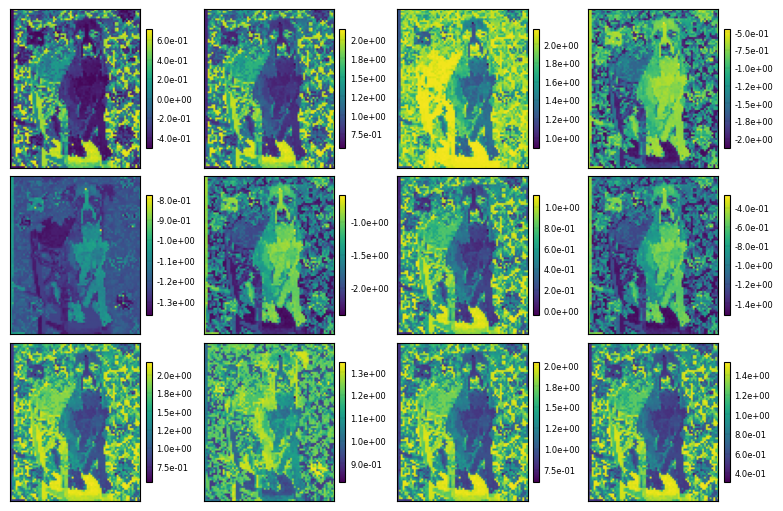

In [33]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


- This does not really mean too much because the latent variables are all competing with one another


## LSTM Autoencoder with 3 Latent Variables


In [34]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [44]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [36]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [37]:
random_seed(seed=42)

Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 107.57it/s]


Epoch 0, Train Loss: 2.0366
.............................


100%|██████████| 19/19 [00:00<00:00, 130.14it/s]


Epoch 1, Train Loss: 2.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 130.44it/s]


Epoch 2, Train Loss: 2.0296
.............................


100%|██████████| 19/19 [00:00<00:00, 121.04it/s]


Epoch 3, Train Loss: 2.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 129.57it/s]


Epoch 4, Train Loss: 2.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 130.74it/s]


Epoch 5, Train Loss: 2.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 129.22it/s]


Epoch 6, Train Loss: 2.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 125.97it/s]


Epoch 7, Train Loss: 2.0124
.............................


100%|██████████| 19/19 [00:00<00:00, 128.61it/s]


Epoch 8, Train Loss: 2.0089
.............................


100%|██████████| 19/19 [00:00<00:00, 94.91it/s] 


Epoch 9, Train Loss: 2.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 78.78it/s]


Epoch 10, Train Loss: 2.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 83.54it/s]


Epoch 11, Train Loss: 1.9984
.............................


100%|██████████| 19/19 [00:00<00:00, 84.17it/s]


Epoch 12, Train Loss: 1.9948
.............................


100%|██████████| 19/19 [00:00<00:00, 84.87it/s]


Epoch 13, Train Loss: 1.9912
.............................


100%|██████████| 19/19 [00:00<00:00, 82.60it/s]


Epoch 14, Train Loss: 1.9876
.............................


100%|██████████| 19/19 [00:00<00:00, 75.43it/s]


Epoch 15, Train Loss: 1.9839
.............................


100%|██████████| 19/19 [00:00<00:00, 80.74it/s]


Epoch 16, Train Loss: 1.9801
.............................


100%|██████████| 19/19 [00:00<00:00, 81.97it/s]


Epoch 17, Train Loss: 1.9763
.............................


100%|██████████| 19/19 [00:00<00:00, 78.90it/s]


Epoch 18, Train Loss: 1.9725
.............................


100%|██████████| 19/19 [00:00<00:00, 117.56it/s]


Epoch 19, Train Loss: 1.9685
.............................


100%|██████████| 19/19 [00:00<00:00, 130.04it/s]


Epoch 20, Train Loss: 1.9645
.............................


100%|██████████| 19/19 [00:00<00:00, 119.45it/s]


Epoch 21, Train Loss: 1.9604
.............................


100%|██████████| 19/19 [00:00<00:00, 127.41it/s]


Epoch 22, Train Loss: 1.9562
.............................


100%|██████████| 19/19 [00:00<00:00, 131.46it/s]


Epoch 23, Train Loss: 1.9519
.............................


100%|██████████| 19/19 [00:00<00:00, 132.70it/s]


Epoch 24, Train Loss: 1.9476
.............................


100%|██████████| 19/19 [00:00<00:00, 128.98it/s]


Epoch 25, Train Loss: 1.9431
.............................


100%|██████████| 19/19 [00:00<00:00, 119.15it/s]


Epoch 26, Train Loss: 1.9384
.............................


100%|██████████| 19/19 [00:00<00:00, 102.35it/s]


Epoch 27, Train Loss: 1.9337
.............................


100%|██████████| 19/19 [00:00<00:00, 129.65it/s]


Epoch 28, Train Loss: 1.9288
.............................


100%|██████████| 19/19 [00:00<00:00, 131.52it/s]


Epoch 29, Train Loss: 1.9238
.............................


100%|██████████| 19/19 [00:00<00:00, 130.10it/s]


Epoch 30, Train Loss: 1.9186
.............................


100%|██████████| 19/19 [00:00<00:00, 131.90it/s]


Epoch 31, Train Loss: 1.9133
.............................


100%|██████████| 19/19 [00:00<00:00, 117.62it/s]


Epoch 32, Train Loss: 1.9077
.............................


100%|██████████| 19/19 [00:00<00:00, 131.52it/s]


Epoch 33, Train Loss: 1.9021
.............................


100%|██████████| 19/19 [00:00<00:00, 131.89it/s]


Epoch 34, Train Loss: 1.8962
.............................


100%|██████████| 19/19 [00:00<00:00, 131.72it/s]


Epoch 35, Train Loss: 1.8901
.............................


100%|██████████| 19/19 [00:00<00:00, 130.33it/s]


Epoch 36, Train Loss: 1.8838
.............................


100%|██████████| 19/19 [00:00<00:00, 129.96it/s]


Epoch 37, Train Loss: 1.8773
.............................


100%|██████████| 19/19 [00:00<00:00, 123.35it/s]


Epoch 38, Train Loss: 1.8705
.............................


100%|██████████| 19/19 [00:00<00:00, 121.12it/s]


Epoch 39, Train Loss: 1.8635
.............................


100%|██████████| 19/19 [00:00<00:00, 123.46it/s]


Epoch 40, Train Loss: 1.8563
.............................


100%|██████████| 19/19 [00:00<00:00, 130.41it/s]


Epoch 41, Train Loss: 1.8487
.............................


100%|██████████| 19/19 [00:00<00:00, 127.04it/s]


Epoch 42, Train Loss: 1.8409
.............................


100%|██████████| 19/19 [00:00<00:00, 131.62it/s]


Epoch 43, Train Loss: 1.8328
.............................


100%|██████████| 19/19 [00:00<00:00, 130.39it/s]


Epoch 44, Train Loss: 1.8244
.............................


100%|██████████| 19/19 [00:00<00:00, 123.32it/s]


Epoch 45, Train Loss: 1.8156
.............................


100%|██████████| 19/19 [00:00<00:00, 112.68it/s]


Epoch 46, Train Loss: 1.8065
.............................


100%|██████████| 19/19 [00:00<00:00, 129.38it/s]


Epoch 47, Train Loss: 1.7971
.............................


100%|██████████| 19/19 [00:00<00:00, 132.71it/s]


Epoch 48, Train Loss: 1.7872
.............................


100%|██████████| 19/19 [00:00<00:00, 128.97it/s]


Epoch 49, Train Loss: 1.7770
.............................


100%|██████████| 19/19 [00:00<00:00, 130.46it/s]


Epoch 50, Train Loss: 1.7664
.............................


100%|██████████| 19/19 [00:00<00:00, 128.12it/s]


Epoch 51, Train Loss: 1.7553
.............................


100%|██████████| 19/19 [00:00<00:00, 117.25it/s]


Epoch 52, Train Loss: 1.7437
.............................


100%|██████████| 19/19 [00:00<00:00, 130.43it/s]


Epoch 53, Train Loss: 1.7317
.............................


100%|██████████| 19/19 [00:00<00:00, 130.13it/s]


Epoch 54, Train Loss: 1.7192
.............................


100%|██████████| 19/19 [00:00<00:00, 128.80it/s]


Epoch 55, Train Loss: 1.7062
.............................


100%|██████████| 19/19 [00:00<00:00, 128.09it/s]


Epoch 56, Train Loss: 1.6927
.............................


100%|██████████| 19/19 [00:00<00:00, 127.16it/s]


Epoch 57, Train Loss: 1.6786
.............................


100%|██████████| 19/19 [00:00<00:00, 127.91it/s]


Epoch 58, Train Loss: 1.6640
.............................


100%|██████████| 19/19 [00:00<00:00, 119.93it/s]


Epoch 59, Train Loss: 1.6488
.............................


100%|██████████| 19/19 [00:00<00:00, 126.16it/s]


Epoch 60, Train Loss: 1.6331
.............................


100%|██████████| 19/19 [00:00<00:00, 127.36it/s]


Epoch 61, Train Loss: 1.6169
.............................


100%|██████████| 19/19 [00:00<00:00, 131.21it/s]


Epoch 62, Train Loss: 1.6002
.............................


100%|██████████| 19/19 [00:00<00:00, 124.58it/s]


Epoch 63, Train Loss: 1.5830
.............................


100%|██████████| 19/19 [00:00<00:00, 125.00it/s]


Epoch 64, Train Loss: 1.5653
.............................


100%|██████████| 19/19 [00:00<00:00, 133.61it/s]


Epoch 65, Train Loss: 1.5472
.............................


100%|██████████| 19/19 [00:00<00:00, 114.99it/s]


Epoch 66, Train Loss: 1.5287
.............................


100%|██████████| 19/19 [00:00<00:00, 127.91it/s]


Epoch 67, Train Loss: 1.5099
.............................


100%|██████████| 19/19 [00:00<00:00, 130.66it/s]


Epoch 68, Train Loss: 1.4908
.............................


100%|██████████| 19/19 [00:00<00:00, 125.64it/s]


Epoch 69, Train Loss: 1.4715
.............................


100%|██████████| 19/19 [00:00<00:00, 128.97it/s]


Epoch 70, Train Loss: 1.4519
.............................


100%|██████████| 19/19 [00:00<00:00, 129.04it/s]


Epoch 71, Train Loss: 1.4322
.............................


100%|██████████| 19/19 [00:00<00:00, 117.00it/s]


Epoch 72, Train Loss: 1.4124
.............................


100%|██████████| 19/19 [00:00<00:00, 131.17it/s]


Epoch 73, Train Loss: 1.3925
.............................


100%|██████████| 19/19 [00:00<00:00, 131.19it/s]


Epoch 74, Train Loss: 1.3726
.............................


100%|██████████| 19/19 [00:00<00:00, 127.08it/s]


Epoch 75, Train Loss: 1.3526
.............................


100%|██████████| 19/19 [00:00<00:00, 128.57it/s]


Epoch 76, Train Loss: 1.3327
.............................


100%|██████████| 19/19 [00:00<00:00, 126.79it/s]


Epoch 77, Train Loss: 1.3128
.............................


100%|██████████| 19/19 [00:00<00:00, 125.22it/s]


Epoch 78, Train Loss: 1.2929
.............................


100%|██████████| 19/19 [00:00<00:00, 116.46it/s]


Epoch 79, Train Loss: 1.2731
.............................


100%|██████████| 19/19 [00:00<00:00, 128.25it/s]


Epoch 80, Train Loss: 1.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 129.02it/s]


Epoch 81, Train Loss: 1.2337
.............................


100%|██████████| 19/19 [00:00<00:00, 128.86it/s]


Epoch 82, Train Loss: 1.2141
.............................


100%|██████████| 19/19 [00:00<00:00, 124.69it/s]


Epoch 83, Train Loss: 1.1946
.............................


100%|██████████| 19/19 [00:00<00:00, 79.50it/s]


Epoch 84, Train Loss: 1.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 83.51it/s]


Epoch 85, Train Loss: 1.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 86.88it/s]


Epoch 86, Train Loss: 1.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 87.15it/s]


Epoch 87, Train Loss: 1.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 85.57it/s]


Epoch 88, Train Loss: 1.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 86.28it/s]


Epoch 89, Train Loss: 1.0786
.............................


100%|██████████| 19/19 [00:00<00:00, 82.96it/s]


Epoch 90, Train Loss: 1.0593
.............................


100%|██████████| 19/19 [00:00<00:00, 82.95it/s]


Epoch 91, Train Loss: 1.0400
.............................


100%|██████████| 19/19 [00:00<00:00, 76.95it/s]


Epoch 92, Train Loss: 1.0206
.............................


100%|██████████| 19/19 [00:00<00:00, 86.20it/s]


Epoch 93, Train Loss: 1.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 131.55it/s]


Epoch 94, Train Loss: 0.9814
.............................


100%|██████████| 19/19 [00:00<00:00, 118.26it/s]


Epoch 95, Train Loss: 0.9616
.............................


100%|██████████| 19/19 [00:00<00:00, 129.27it/s]


Epoch 96, Train Loss: 0.9417
.............................


100%|██████████| 19/19 [00:00<00:00, 130.67it/s]


Epoch 97, Train Loss: 0.9216
.............................


100%|██████████| 19/19 [00:00<00:00, 126.22it/s]


Epoch 98, Train Loss: 0.9012
.............................


100%|██████████| 19/19 [00:00<00:00, 128.04it/s]


Epoch 99, Train Loss: 0.8807
.............................


100%|██████████| 19/19 [00:00<00:00, 131.12it/s]


Epoch 100, Train Loss: 0.8600
.............................


100%|██████████| 19/19 [00:00<00:00, 114.82it/s]


Epoch 101, Train Loss: 0.8391
.............................


100%|██████████| 19/19 [00:00<00:00, 129.64it/s]


Epoch 102, Train Loss: 0.8181
.............................


100%|██████████| 19/19 [00:00<00:00, 128.08it/s]


Epoch 103, Train Loss: 0.7968
.............................


100%|██████████| 19/19 [00:00<00:00, 126.65it/s]


Epoch 104, Train Loss: 0.7754
.............................


100%|██████████| 19/19 [00:00<00:00, 123.21it/s]


Epoch 105, Train Loss: 0.7539
.............................


100%|██████████| 19/19 [00:00<00:00, 129.19it/s]


Epoch 106, Train Loss: 0.7324
.............................


100%|██████████| 19/19 [00:00<00:00, 129.18it/s]


Epoch 107, Train Loss: 0.7108
.............................


100%|██████████| 19/19 [00:00<00:00, 121.44it/s]


Epoch 108, Train Loss: 0.6893
.............................


100%|██████████| 19/19 [00:00<00:00, 126.83it/s]


Epoch 109, Train Loss: 0.6680
.............................


100%|██████████| 19/19 [00:00<00:00, 129.35it/s]


Epoch 110, Train Loss: 0.6468
.............................


100%|██████████| 19/19 [00:00<00:00, 123.90it/s]


Epoch 111, Train Loss: 0.6259
.............................


100%|██████████| 19/19 [00:00<00:00, 130.87it/s]


Epoch 112, Train Loss: 0.6053
.............................


100%|██████████| 19/19 [00:00<00:00, 123.59it/s]


Epoch 113, Train Loss: 0.5852
.............................


100%|██████████| 19/19 [00:00<00:00, 128.84it/s]


Epoch 114, Train Loss: 0.5657
.............................


100%|██████████| 19/19 [00:00<00:00, 109.84it/s]


Epoch 115, Train Loss: 0.5467
.............................


100%|██████████| 19/19 [00:00<00:00, 126.80it/s]


Epoch 116, Train Loss: 0.5284
.............................


100%|██████████| 19/19 [00:00<00:00, 117.48it/s]


Epoch 117, Train Loss: 0.5108
.............................


100%|██████████| 19/19 [00:00<00:00, 120.38it/s]


Epoch 118, Train Loss: 0.4939
.............................


100%|██████████| 19/19 [00:00<00:00, 125.51it/s]


Epoch 119, Train Loss: 0.4779
.............................


100%|██████████| 19/19 [00:00<00:00, 129.38it/s]


Epoch 120, Train Loss: 0.4626
.............................


100%|██████████| 19/19 [00:00<00:00, 116.31it/s]


Epoch 121, Train Loss: 0.4482
.............................


100%|██████████| 19/19 [00:00<00:00, 125.29it/s]


Epoch 122, Train Loss: 0.4346
.............................


100%|██████████| 19/19 [00:00<00:00, 127.92it/s]


Epoch 123, Train Loss: 0.4218
.............................


100%|██████████| 19/19 [00:00<00:00, 126.22it/s]


Epoch 124, Train Loss: 0.4097
.............................


100%|██████████| 19/19 [00:00<00:00, 125.55it/s]


Epoch 125, Train Loss: 0.3984
.............................


100%|██████████| 19/19 [00:00<00:00, 128.36it/s]


Epoch 126, Train Loss: 0.3878
.............................


100%|██████████| 19/19 [00:00<00:00, 126.50it/s]


Epoch 127, Train Loss: 0.3778
.............................


100%|██████████| 19/19 [00:00<00:00, 115.76it/s]


Epoch 128, Train Loss: 0.3685
.............................


100%|██████████| 19/19 [00:00<00:00, 130.02it/s]


Epoch 129, Train Loss: 0.3597
.............................


100%|██████████| 19/19 [00:00<00:00, 128.43it/s]


Epoch 130, Train Loss: 0.3515
.............................


100%|██████████| 19/19 [00:00<00:00, 126.91it/s]


Epoch 131, Train Loss: 0.3438
.............................


100%|██████████| 19/19 [00:00<00:00, 126.76it/s]


Epoch 132, Train Loss: 0.3365
.............................


100%|██████████| 19/19 [00:00<00:00, 128.46it/s]


Epoch 133, Train Loss: 0.3297
.............................


100%|██████████| 19/19 [00:00<00:00, 127.57it/s]


Epoch 134, Train Loss: 0.3232
.............................


100%|██████████| 19/19 [00:00<00:00, 117.28it/s]


Epoch 135, Train Loss: 0.3171
.............................


100%|██████████| 19/19 [00:00<00:00, 128.28it/s]


Epoch 136, Train Loss: 0.3114
.............................


100%|██████████| 19/19 [00:00<00:00, 122.48it/s]


Epoch 137, Train Loss: 0.3060
.............................


100%|██████████| 19/19 [00:00<00:00, 129.61it/s]


Epoch 138, Train Loss: 0.3009
.............................


100%|██████████| 19/19 [00:00<00:00, 127.05it/s]


Epoch 139, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 129.25it/s]


Epoch 140, Train Loss: 0.2915
.............................


100%|██████████| 19/19 [00:00<00:00, 116.68it/s]


Epoch 141, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 127.65it/s]


Epoch 142, Train Loss: 0.2831
.............................


100%|██████████| 19/19 [00:00<00:00, 126.93it/s]


Epoch 143, Train Loss: 0.2792
.............................


100%|██████████| 19/19 [00:00<00:00, 130.66it/s]


Epoch 144, Train Loss: 0.2756
.............................


100%|██████████| 19/19 [00:00<00:00, 123.47it/s]


Epoch 145, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 124.83it/s]


Epoch 146, Train Loss: 0.2688
.............................


100%|██████████| 19/19 [00:00<00:00, 126.85it/s]


Epoch 147, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 115.64it/s]


Epoch 148, Train Loss: 0.2628
.............................


100%|██████████| 19/19 [00:00<00:00, 127.04it/s]


Epoch 149, Train Loss: 0.2600
.............................


100%|██████████| 19/19 [00:00<00:00, 125.31it/s]


Epoch 150, Train Loss: 0.2574
.............................


100%|██████████| 19/19 [00:00<00:00, 127.65it/s]


Epoch 151, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 129.43it/s]


Epoch 152, Train Loss: 0.2525
.............................


100%|██████████| 19/19 [00:00<00:00, 118.41it/s]


Epoch 153, Train Loss: 0.2502
.............................


100%|██████████| 19/19 [00:00<00:00, 124.93it/s]


Epoch 154, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 119.34it/s]


Epoch 155, Train Loss: 0.2461
.............................


100%|██████████| 19/19 [00:00<00:00, 126.19it/s]


Epoch 156, Train Loss: 0.2441
.............................


100%|██████████| 19/19 [00:00<00:00, 116.23it/s]


Epoch 157, Train Loss: 0.2423
.............................


100%|██████████| 19/19 [00:00<00:00, 81.83it/s]


Epoch 158, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 80.33it/s]


Epoch 159, Train Loss: 0.2389
.............................


100%|██████████| 19/19 [00:00<00:00, 77.89it/s]


Epoch 160, Train Loss: 0.2373
.............................


100%|██████████| 19/19 [00:00<00:00, 82.96it/s]


Epoch 161, Train Loss: 0.2358
.............................


100%|██████████| 19/19 [00:00<00:00, 83.12it/s]


Epoch 162, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 86.82it/s]


Epoch 163, Train Loss: 0.2329
.............................


100%|██████████| 19/19 [00:00<00:00, 78.23it/s]


Epoch 164, Train Loss: 0.2316
.............................


100%|██████████| 19/19 [00:00<00:00, 76.21it/s]


Epoch 165, Train Loss: 0.2303
.............................


100%|██████████| 19/19 [00:00<00:00, 79.93it/s]


Epoch 166, Train Loss: 0.2291
.............................


100%|██████████| 19/19 [00:00<00:00, 93.89it/s]


Epoch 167, Train Loss: 0.2280
.............................


100%|██████████| 19/19 [00:00<00:00, 128.14it/s]


Epoch 168, Train Loss: 0.2269
.............................


100%|██████████| 19/19 [00:00<00:00, 128.23it/s]


Epoch 169, Train Loss: 0.2258
.............................


100%|██████████| 19/19 [00:00<00:00, 116.23it/s]


Epoch 170, Train Loss: 0.2248
.............................


100%|██████████| 19/19 [00:00<00:00, 125.55it/s]


Epoch 171, Train Loss: 0.2238
.............................


100%|██████████| 19/19 [00:00<00:00, 127.38it/s]


Epoch 172, Train Loss: 0.2228
.............................


100%|██████████| 19/19 [00:00<00:00, 123.32it/s]


Epoch 173, Train Loss: 0.2219
.............................


100%|██████████| 19/19 [00:00<00:00, 125.57it/s]


Epoch 174, Train Loss: 0.2210
.............................


100%|██████████| 19/19 [00:00<00:00, 121.03it/s]


Epoch 175, Train Loss: 0.2201
.............................


100%|██████████| 19/19 [00:00<00:00, 116.02it/s]


Epoch 176, Train Loss: 0.2193
.............................


100%|██████████| 19/19 [00:00<00:00, 125.57it/s]


Epoch 177, Train Loss: 0.2185
.............................


100%|██████████| 19/19 [00:00<00:00, 126.45it/s]


Epoch 178, Train Loss: 0.2177
.............................


100%|██████████| 19/19 [00:00<00:00, 128.30it/s]


Epoch 179, Train Loss: 0.2169
.............................


100%|██████████| 19/19 [00:00<00:00, 127.17it/s]


Epoch 180, Train Loss: 0.2162
.............................


100%|██████████| 19/19 [00:00<00:00, 123.25it/s]


Epoch 181, Train Loss: 0.2155
.............................


100%|██████████| 19/19 [00:00<00:00, 127.01it/s]


Epoch 182, Train Loss: 0.2147
.............................


100%|██████████| 19/19 [00:00<00:00, 115.37it/s]


Epoch 183, Train Loss: 0.2140
.............................


100%|██████████| 19/19 [00:00<00:00, 127.78it/s]


Epoch 184, Train Loss: 0.2134
.............................


100%|██████████| 19/19 [00:00<00:00, 126.67it/s]


Epoch 185, Train Loss: 0.2127
.............................


100%|██████████| 19/19 [00:00<00:00, 126.33it/s]


Epoch 186, Train Loss: 0.2120
.............................


100%|██████████| 19/19 [00:00<00:00, 125.43it/s]


Epoch 187, Train Loss: 0.2114
.............................


100%|██████████| 19/19 [00:00<00:00, 127.40it/s]


Epoch 188, Train Loss: 0.2108
.............................


100%|██████████| 19/19 [00:00<00:00, 123.30it/s]


Epoch 189, Train Loss: 0.2101
.............................


100%|██████████| 19/19 [00:00<00:00, 116.39it/s]


Epoch 190, Train Loss: 0.2095
.............................


100%|██████████| 19/19 [00:00<00:00, 125.35it/s]


Epoch 191, Train Loss: 0.2089
.............................


100%|██████████| 19/19 [00:00<00:00, 126.87it/s]


Epoch 192, Train Loss: 0.2083
.............................


100%|██████████| 19/19 [00:00<00:00, 127.49it/s]


Epoch 193, Train Loss: 0.2078
.............................


100%|██████████| 19/19 [00:00<00:00, 131.18it/s]


Epoch 194, Train Loss: 0.2072
.............................


100%|██████████| 19/19 [00:00<00:00, 125.16it/s]


Epoch 195, Train Loss: 0.2066
.............................


100%|██████████| 19/19 [00:00<00:00, 112.99it/s]


Epoch 196, Train Loss: 0.2061
.............................


100%|██████████| 19/19 [00:00<00:00, 125.10it/s]


Epoch 197, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 127.43it/s]


Epoch 198, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 128.44it/s]


Epoch 199, Train Loss: 0.2044
.............................


100%|██████████| 19/19 [00:00<00:00, 124.44it/s]


Epoch 200, Train Loss: 0.2039
.............................


100%|██████████| 19/19 [00:00<00:00, 118.88it/s]


Epoch 201, Train Loss: 0.2033
.............................


100%|██████████| 19/19 [00:00<00:00, 123.51it/s]


Epoch 202, Train Loss: 0.2028
.............................


100%|██████████| 19/19 [00:00<00:00, 109.66it/s]


Epoch 203, Train Loss: 0.2023
.............................


100%|██████████| 19/19 [00:00<00:00, 121.33it/s]


Epoch 204, Train Loss: 0.2018
.............................


100%|██████████| 19/19 [00:00<00:00, 120.54it/s]


Epoch 205, Train Loss: 0.2013
.............................


100%|██████████| 19/19 [00:00<00:00, 122.28it/s]


Epoch 206, Train Loss: 0.2008
.............................


100%|██████████| 19/19 [00:00<00:00, 122.47it/s]


Epoch 207, Train Loss: 0.2002
.............................


100%|██████████| 19/19 [00:00<00:00, 120.45it/s]


Epoch 208, Train Loss: 0.1998
.............................


100%|██████████| 19/19 [00:00<00:00, 111.92it/s]


Epoch 209, Train Loss: 0.1993
.............................


100%|██████████| 19/19 [00:00<00:00, 118.28it/s]


Epoch 210, Train Loss: 0.1988
.............................


100%|██████████| 19/19 [00:00<00:00, 109.15it/s]


Epoch 211, Train Loss: 0.1983
.............................


100%|██████████| 19/19 [00:00<00:00, 116.87it/s]


Epoch 212, Train Loss: 0.1978
.............................


100%|██████████| 19/19 [00:00<00:00, 126.87it/s]


Epoch 213, Train Loss: 0.1973
.............................


100%|██████████| 19/19 [00:00<00:00, 125.38it/s]


Epoch 214, Train Loss: 0.1968
.............................


100%|██████████| 19/19 [00:00<00:00, 113.90it/s]


Epoch 215, Train Loss: 0.1964
.............................


100%|██████████| 19/19 [00:00<00:00, 118.05it/s]


Epoch 216, Train Loss: 0.1959
.............................


100%|██████████| 19/19 [00:00<00:00, 126.46it/s]


Epoch 217, Train Loss: 0.1955
.............................


100%|██████████| 19/19 [00:00<00:00, 125.00it/s]


Epoch 218, Train Loss: 0.1950
.............................


100%|██████████| 19/19 [00:00<00:00, 121.40it/s]


Epoch 219, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 120.31it/s]


Epoch 220, Train Loss: 0.1941
.............................


100%|██████████| 19/19 [00:00<00:00, 117.40it/s]


Epoch 221, Train Loss: 0.1936
.............................


100%|██████████| 19/19 [00:00<00:00, 109.72it/s]


Epoch 222, Train Loss: 0.1932
.............................


100%|██████████| 19/19 [00:00<00:00, 125.76it/s]


Epoch 223, Train Loss: 0.1928
.............................


100%|██████████| 19/19 [00:00<00:00, 121.09it/s]


Epoch 224, Train Loss: 0.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 120.01it/s]


Epoch 225, Train Loss: 0.1919
.............................


100%|██████████| 19/19 [00:00<00:00, 123.22it/s]


Epoch 226, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 116.40it/s]


Epoch 227, Train Loss: 0.1910
.............................


100%|██████████| 19/19 [00:00<00:00, 110.37it/s]


Epoch 228, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 119.51it/s]


Epoch 229, Train Loss: 0.1902
.............................


100%|██████████| 19/19 [00:00<00:00, 81.30it/s]


Epoch 230, Train Loss: 0.1898
.............................


100%|██████████| 19/19 [00:00<00:00, 80.73it/s]


Epoch 231, Train Loss: 0.1894
.............................


100%|██████████| 19/19 [00:00<00:00, 76.31it/s]


Epoch 232, Train Loss: 0.1889
.............................


100%|██████████| 19/19 [00:00<00:00, 74.34it/s]


Epoch 233, Train Loss: 0.1885
.............................


100%|██████████| 19/19 [00:00<00:00, 80.29it/s]


Epoch 234, Train Loss: 0.1881
.............................


100%|██████████| 19/19 [00:00<00:00, 79.01it/s]


Epoch 235, Train Loss: 0.1877
.............................


100%|██████████| 19/19 [00:00<00:00, 75.28it/s]


Epoch 236, Train Loss: 0.1873
.............................


100%|██████████| 19/19 [00:00<00:00, 73.86it/s]


Epoch 237, Train Loss: 0.1869
.............................


100%|██████████| 19/19 [00:00<00:00, 78.13it/s]


Epoch 238, Train Loss: 0.1865
.............................


100%|██████████| 19/19 [00:00<00:00, 101.63it/s]


Epoch 239, Train Loss: 0.1861
.............................


100%|██████████| 19/19 [00:00<00:00, 119.26it/s]


Epoch 240, Train Loss: 0.1858
.............................


100%|██████████| 19/19 [00:00<00:00, 119.88it/s]


Epoch 241, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 110.53it/s]


Epoch 242, Train Loss: 0.1850
.............................


100%|██████████| 19/19 [00:00<00:00, 122.23it/s]


Epoch 243, Train Loss: 0.1846
.............................


100%|██████████| 19/19 [00:00<00:00, 121.83it/s]


Epoch 244, Train Loss: 0.1842
.............................


100%|██████████| 19/19 [00:00<00:00, 123.59it/s]


Epoch 245, Train Loss: 0.1838
.............................


100%|██████████| 19/19 [00:00<00:00, 122.28it/s]


Epoch 246, Train Loss: 0.1835
.............................


100%|██████████| 19/19 [00:00<00:00, 119.52it/s]


Epoch 247, Train Loss: 0.1831
.............................


100%|██████████| 19/19 [00:00<00:00, 119.14it/s]


Epoch 248, Train Loss: 0.1827
.............................


100%|██████████| 19/19 [00:00<00:00, 114.15it/s]


Epoch 249, Train Loss: 0.1823
.............................


100%|██████████| 19/19 [00:00<00:00, 121.82it/s]


Epoch 250, Train Loss: 0.1820
.............................


100%|██████████| 19/19 [00:00<00:00, 121.13it/s]


Epoch 251, Train Loss: 0.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 114.42it/s]


Epoch 252, Train Loss: 0.1812
.............................


100%|██████████| 19/19 [00:00<00:00, 118.22it/s]


Epoch 253, Train Loss: 0.1809
.............................


100%|██████████| 19/19 [00:00<00:00, 117.63it/s]


Epoch 254, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 110.96it/s]


Epoch 255, Train Loss: 0.1802
.............................


100%|██████████| 19/19 [00:00<00:00, 120.89it/s]


Epoch 256, Train Loss: 0.1798
.............................


100%|██████████| 19/19 [00:00<00:00, 125.68it/s]


Epoch 257, Train Loss: 0.1794
.............................


100%|██████████| 19/19 [00:00<00:00, 124.09it/s]


Epoch 258, Train Loss: 0.1791
.............................


100%|██████████| 19/19 [00:00<00:00, 124.66it/s]


Epoch 259, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 119.88it/s]


Epoch 260, Train Loss: 0.1784
.............................


100%|██████████| 19/19 [00:00<00:00, 111.45it/s]


Epoch 261, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 124.37it/s]


Epoch 262, Train Loss: 0.1777
.............................


100%|██████████| 19/19 [00:00<00:00, 124.42it/s]


Epoch 263, Train Loss: 0.1773
.............................


100%|██████████| 19/19 [00:00<00:00, 123.06it/s]


Epoch 264, Train Loss: 0.1770
.............................


100%|██████████| 19/19 [00:00<00:00, 122.68it/s]


Epoch 265, Train Loss: 0.1766
.............................


100%|██████████| 19/19 [00:00<00:00, 119.16it/s]


Epoch 266, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 122.56it/s]


Epoch 267, Train Loss: 0.1759
.............................


100%|██████████| 19/19 [00:00<00:00, 110.29it/s]


Epoch 268, Train Loss: 0.1756
.............................


100%|██████████| 19/19 [00:00<00:00, 113.04it/s]


Epoch 269, Train Loss: 0.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 120.16it/s]


Epoch 270, Train Loss: 0.1749
.............................


100%|██████████| 19/19 [00:00<00:00, 119.81it/s]


Epoch 271, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 118.74it/s]


Epoch 272, Train Loss: 0.1742
.............................


100%|██████████| 19/19 [00:00<00:00, 119.53it/s]


Epoch 273, Train Loss: 0.1739
.............................


100%|██████████| 19/19 [00:00<00:00, 111.26it/s]


Epoch 274, Train Loss: 0.1735
.............................


100%|██████████| 19/19 [00:00<00:00, 121.52it/s]


Epoch 275, Train Loss: 0.1732
.............................


100%|██████████| 19/19 [00:00<00:00, 123.82it/s]


Epoch 276, Train Loss: 0.1729
.............................


100%|██████████| 19/19 [00:00<00:00, 121.49it/s]


Epoch 277, Train Loss: 0.1725
.............................


100%|██████████| 19/19 [00:00<00:00, 120.50it/s]


Epoch 278, Train Loss: 0.1722
.............................


100%|██████████| 19/19 [00:00<00:00, 123.12it/s]


Epoch 279, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 110.19it/s]


Epoch 280, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 123.62it/s]


Epoch 281, Train Loss: 0.1712
.............................


100%|██████████| 19/19 [00:00<00:00, 120.53it/s]


Epoch 282, Train Loss: 0.1709
.............................


100%|██████████| 19/19 [00:00<00:00, 110.28it/s]


Epoch 283, Train Loss: 0.1705
.............................


100%|██████████| 19/19 [00:00<00:00, 119.20it/s]


Epoch 284, Train Loss: 0.1702
.............................


100%|██████████| 19/19 [00:00<00:00, 118.61it/s]


Epoch 285, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 117.64it/s]


Epoch 286, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 114.60it/s]


Epoch 287, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 117.98it/s]


Epoch 288, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 118.74it/s]


Epoch 289, Train Loss: 0.1686
.............................


100%|██████████| 19/19 [00:00<00:00, 114.92it/s]


Epoch 290, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 117.97it/s]


Epoch 291, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 116.78it/s]


Epoch 292, Train Loss: 0.1676
.............................


100%|██████████| 19/19 [00:00<00:00, 106.04it/s]


Epoch 293, Train Loss: 0.1673
.............................


100%|██████████| 19/19 [00:00<00:00, 118.43it/s]


Epoch 294, Train Loss: 0.1670
.............................


100%|██████████| 19/19 [00:00<00:00, 117.02it/s]


Epoch 295, Train Loss: 0.1667
.............................


100%|██████████| 19/19 [00:00<00:00, 115.58it/s]


Epoch 296, Train Loss: 0.1663
.............................


100%|██████████| 19/19 [00:00<00:00, 116.14it/s]


Epoch 297, Train Loss: 0.1660
.............................


100%|██████████| 19/19 [00:00<00:00, 118.89it/s]


Epoch 298, Train Loss: 0.1657
.............................


100%|██████████| 19/19 [00:00<00:00, 106.72it/s]


Epoch 299, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 74.40it/s]


Epoch 300, Train Loss: 0.1651
.............................


100%|██████████| 19/19 [00:00<00:00, 77.60it/s]


Epoch 301, Train Loss: 0.1648
.............................


100%|██████████| 19/19 [00:00<00:00, 76.37it/s]


Epoch 302, Train Loss: 0.1645
.............................


100%|██████████| 19/19 [00:00<00:00, 77.03it/s]


Epoch 303, Train Loss: 0.1642
.............................


100%|██████████| 19/19 [00:00<00:00, 78.69it/s]


Epoch 304, Train Loss: 0.1639
.............................


100%|██████████| 19/19 [00:00<00:00, 78.53it/s]


Epoch 305, Train Loss: 0.1636
.............................


100%|██████████| 19/19 [00:00<00:00, 75.87it/s]


Epoch 306, Train Loss: 0.1633
.............................


100%|██████████| 19/19 [00:00<00:00, 76.19it/s]


Epoch 307, Train Loss: 0.1630
.............................


100%|██████████| 19/19 [00:00<00:00, 71.02it/s]


Epoch 308, Train Loss: 0.1627
.............................


100%|██████████| 19/19 [00:00<00:00, 95.67it/s]


Epoch 309, Train Loss: 0.1624
.............................


100%|██████████| 19/19 [00:00<00:00, 121.16it/s]


Epoch 310, Train Loss: 0.1621
.............................


100%|██████████| 19/19 [00:00<00:00, 119.39it/s]


Epoch 311, Train Loss: 0.1618
.............................


100%|██████████| 19/19 [00:00<00:00, 120.70it/s]


Epoch 312, Train Loss: 0.1616
.............................


100%|██████████| 19/19 [00:00<00:00, 114.06it/s]


Epoch 313, Train Loss: 0.1613
.............................


100%|██████████| 19/19 [00:00<00:00, 120.83it/s]


Epoch 314, Train Loss: 0.1610
.............................


100%|██████████| 19/19 [00:00<00:00, 116.39it/s]


Epoch 315, Train Loss: 0.1607
.............................


100%|██████████| 19/19 [00:00<00:00, 120.23it/s]


Epoch 316, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 125.23it/s]


Epoch 317, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 122.54it/s]


Epoch 318, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 112.24it/s]


Epoch 319, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 122.00it/s]


Epoch 320, Train Loss: 0.1593
.............................


100%|██████████| 19/19 [00:00<00:00, 119.70it/s]


Epoch 321, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 123.38it/s]


Epoch 322, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 110.22it/s]


Epoch 323, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 120.40it/s]


Epoch 324, Train Loss: 0.1583
.............................


100%|██████████| 19/19 [00:00<00:00, 102.35it/s]


Epoch 325, Train Loss: 0.1580
.............................


100%|██████████| 19/19 [00:00<00:00, 121.37it/s]


Epoch 326, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 116.72it/s]


Epoch 327, Train Loss: 0.1575
.............................


100%|██████████| 19/19 [00:00<00:00, 119.56it/s]


Epoch 328, Train Loss: 0.1573
.............................


100%|██████████| 19/19 [00:00<00:00, 120.83it/s]


Epoch 329, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 121.82it/s]


Epoch 330, Train Loss: 0.1568
.............................


100%|██████████| 19/19 [00:00<00:00, 116.76it/s]


Epoch 331, Train Loss: 0.1565
.............................


100%|██████████| 19/19 [00:00<00:00, 115.22it/s]


Epoch 332, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 118.89it/s]


Epoch 333, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 118.25it/s]


Epoch 334, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 116.92it/s]


Epoch 335, Train Loss: 0.1556
.............................


100%|██████████| 19/19 [00:00<00:00, 114.19it/s]


Epoch 336, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 118.88it/s]


Epoch 337, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 109.77it/s]


Epoch 338, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 116.44it/s]


Epoch 339, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 119.07it/s]


Epoch 340, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 122.15it/s]


Epoch 341, Train Loss: 0.1542
.............................


100%|██████████| 19/19 [00:00<00:00, 120.43it/s]


Epoch 342, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 118.16it/s]


Epoch 343, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 111.65it/s]


Epoch 344, Train Loss: 0.1536
.............................


100%|██████████| 19/19 [00:00<00:00, 116.60it/s]


Epoch 345, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 120.66it/s]


Epoch 346, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 118.30it/s]


Epoch 347, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 121.87it/s]


Epoch 348, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 121.05it/s]


Epoch 349, Train Loss: 0.1525
.............................


100%|██████████| 19/19 [00:00<00:00, 111.85it/s]


Epoch 350, Train Loss: 0.1523
.............................


100%|██████████| 19/19 [00:00<00:00, 119.16it/s]


Epoch 351, Train Loss: 0.1522
.............................


100%|██████████| 19/19 [00:00<00:00, 118.18it/s]


Epoch 352, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 123.07it/s]


Epoch 353, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 120.82it/s]


Epoch 354, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 121.97it/s]


Epoch 355, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 124.17it/s]


Epoch 356, Train Loss: 0.1512
.............................


100%|██████████| 19/19 [00:00<00:00, 108.41it/s]


Epoch 357, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 119.82it/s]


Epoch 358, Train Loss: 0.1508
.............................


100%|██████████| 19/19 [00:00<00:00, 124.23it/s]


Epoch 359, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 121.46it/s]


Epoch 360, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 122.88it/s]


Epoch 361, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 122.30it/s]


Epoch 362, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 101.86it/s]


Epoch 363, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 117.08it/s]


Epoch 364, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 110.85it/s]


Epoch 365, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 104.97it/s]


Epoch 366, Train Loss: 0.1494
.............................


100%|██████████| 19/19 [00:00<00:00, 111.66it/s]


Epoch 367, Train Loss: 0.1492
.............................


100%|██████████| 19/19 [00:00<00:00, 114.56it/s]


Epoch 368, Train Loss: 0.1491
.............................


100%|██████████| 19/19 [00:00<00:00, 93.20it/s] 


Epoch 369, Train Loss: 0.1489
.............................


100%|██████████| 19/19 [00:00<00:00, 79.54it/s]


Epoch 370, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 79.14it/s]


Epoch 371, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 81.83it/s]


Epoch 372, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 76.59it/s]


Epoch 373, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 83.72it/s]


Epoch 374, Train Loss: 0.1481
.............................


100%|██████████| 19/19 [00:00<00:00, 79.32it/s]


Epoch 375, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 76.09it/s]


Epoch 376, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 76.74it/s]


Epoch 377, Train Loss: 0.1476
.............................


100%|██████████| 19/19 [00:00<00:00, 66.42it/s]


Epoch 378, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 75.60it/s]


Epoch 379, Train Loss: 0.1473
.............................


100%|██████████| 19/19 [00:00<00:00, 106.49it/s]


Epoch 380, Train Loss: 0.1472
.............................


100%|██████████| 19/19 [00:00<00:00, 117.98it/s]


Epoch 381, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 117.29it/s]


Epoch 382, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 108.27it/s]


Epoch 383, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 124.30it/s]


Epoch 384, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 119.22it/s]


Epoch 385, Train Loss: 0.1464
.............................


100%|██████████| 19/19 [00:00<00:00, 119.07it/s]


Epoch 386, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 121.17it/s]


Epoch 387, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 121.79it/s]


Epoch 388, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 108.24it/s]


Epoch 389, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 119.52it/s]


Epoch 390, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 117.89it/s]


Epoch 391, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 121.77it/s]


Epoch 392, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 100.37it/s]


Epoch 393, Train Loss: 0.1453
.............................


100%|██████████| 19/19 [00:00<00:00, 117.48it/s]


Epoch 394, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 101.45it/s]


Epoch 395, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 115.75it/s]


Epoch 396, Train Loss: 0.1449
.............................


100%|██████████| 19/19 [00:00<00:00, 117.10it/s]


Epoch 397, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 119.25it/s]


Epoch 398, Train Loss: 0.1446
.............................


100%|██████████| 19/19 [00:00<00:00, 119.50it/s]


Epoch 399, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 115.34it/s]


Epoch 400, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 106.02it/s]


Epoch 401, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 116.17it/s]


Epoch 402, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 110.88it/s]


Epoch 403, Train Loss: 0.1439
.............................


100%|██████████| 19/19 [00:00<00:00, 116.10it/s]


Epoch 404, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 115.28it/s]


Epoch 405, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 110.64it/s]


Epoch 406, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 109.85it/s]


Epoch 407, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 114.40it/s]


Epoch 408, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 119.49it/s]


Epoch 409, Train Loss: 0.1432
.............................


100%|██████████| 19/19 [00:00<00:00, 110.80it/s]


Epoch 410, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 114.39it/s]


Epoch 411, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 115.35it/s]


Epoch 412, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 107.64it/s]


Epoch 413, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 114.12it/s]


Epoch 414, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 117.44it/s]


Epoch 415, Train Loss: 0.1424
.............................


100%|██████████| 19/19 [00:00<00:00, 113.93it/s]


Epoch 416, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 111.99it/s]


Epoch 417, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 110.73it/s]


Epoch 418, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 106.98it/s]


Epoch 419, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 112.84it/s]


Epoch 420, Train Loss: 0.1418
.............................


100%|██████████| 19/19 [00:00<00:00, 112.15it/s]


Epoch 421, Train Loss: 0.1417
.............................


100%|██████████| 19/19 [00:00<00:00, 110.64it/s]


Epoch 422, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 110.73it/s]


Epoch 423, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 116.23it/s]


Epoch 424, Train Loss: 0.1413
.............................


100%|██████████| 19/19 [00:00<00:00, 102.04it/s]


Epoch 425, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 117.10it/s]


Epoch 426, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 122.14it/s]


Epoch 427, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 117.04it/s]


Epoch 428, Train Loss: 0.1408
.............................


100%|██████████| 19/19 [00:00<00:00, 117.15it/s]


Epoch 429, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 119.92it/s]


Epoch 430, Train Loss: 0.1406
.............................


100%|██████████| 19/19 [00:00<00:00, 110.46it/s]


Epoch 431, Train Loss: 0.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 116.83it/s]


Epoch 432, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 118.29it/s]


Epoch 433, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 117.17it/s]


Epoch 434, Train Loss: 0.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 119.51it/s]


Epoch 435, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 115.37it/s]


Epoch 436, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 121.04it/s]


Epoch 437, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 82.18it/s]


Epoch 438, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 75.96it/s]


Epoch 439, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 75.10it/s]


Epoch 440, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 79.66it/s]


Epoch 441, Train Loss: 0.1393
.............................


100%|██████████| 19/19 [00:00<00:00, 74.06it/s]


Epoch 442, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 84.53it/s]


Epoch 443, Train Loss: 0.1390
.............................


100%|██████████| 19/19 [00:00<00:00, 83.62it/s]


Epoch 444, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 78.40it/s]


Epoch 445, Train Loss: 0.1388
.............................


100%|██████████| 19/19 [00:00<00:00, 73.83it/s]


Epoch 446, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 69.47it/s]


Epoch 447, Train Loss: 0.1386
.............................


100%|██████████| 19/19 [00:00<00:00, 80.53it/s]


Epoch 448, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 117.34it/s]


Epoch 449, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 116.00it/s]


Epoch 450, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 116.03it/s]


Epoch 451, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 103.62it/s]


Epoch 452, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 116.31it/s]


Epoch 453, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 118.16it/s]


Epoch 454, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 116.28it/s]


Epoch 455, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 116.53it/s]


Epoch 456, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 113.50it/s]


Epoch 457, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 107.03it/s]


Epoch 458, Train Loss: 0.1373
.............................


100%|██████████| 19/19 [00:00<00:00, 119.14it/s]


Epoch 459, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 118.37it/s]


Epoch 460, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 118.35it/s]


Epoch 461, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 118.01it/s]


Epoch 462, Train Loss: 0.1369
.............................


100%|██████████| 19/19 [00:00<00:00, 117.30it/s]


Epoch 463, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 97.22it/s]


Epoch 464, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 110.58it/s]


Epoch 465, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 116.03it/s]


Epoch 466, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 115.66it/s]


Epoch 467, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 112.90it/s]


Epoch 468, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 114.25it/s]


Epoch 469, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 107.77it/s]


Epoch 470, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 109.30it/s]


Epoch 471, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 117.60it/s]


Epoch 472, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 117.68it/s]


Epoch 473, Train Loss: 0.1357
.............................


100%|██████████| 19/19 [00:00<00:00, 112.70it/s]


Epoch 474, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 107.94it/s]


Epoch 475, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 106.56it/s]


Epoch 476, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 116.86it/s]


Epoch 477, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 118.30it/s]


Epoch 478, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 120.23it/s]


Epoch 479, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 115.99it/s]


Epoch 480, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 118.80it/s]


Epoch 481, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 105.29it/s]


Epoch 482, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 118.12it/s]


Epoch 483, Train Loss: 0.1346
.............................


100%|██████████| 19/19 [00:00<00:00, 116.89it/s]


Epoch 484, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 117.01it/s]


Epoch 485, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 117.87it/s]


Epoch 486, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 119.74it/s]


Epoch 487, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 103.70it/s]


Epoch 488, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 114.74it/s]


Epoch 489, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 115.69it/s]


Epoch 490, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 114.91it/s]


Epoch 491, Train Loss: 0.1337
.............................


100%|██████████| 19/19 [00:00<00:00, 114.00it/s]


Epoch 492, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 118.43it/s]


Epoch 493, Train Loss: 0.1335
.............................


100%|██████████| 19/19 [00:00<00:00, 107.45it/s]


Epoch 494, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 117.18it/s]


Epoch 495, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 118.16it/s]


Epoch 496, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 110.99it/s]


Epoch 497, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 113.45it/s]


Epoch 498, Train Loss: 0.1330
.............................


100%|██████████| 19/19 [00:00<00:00, 118.70it/s]

Epoch 499, Train Loss: 0.1329
.............................


### Validation


In [38]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


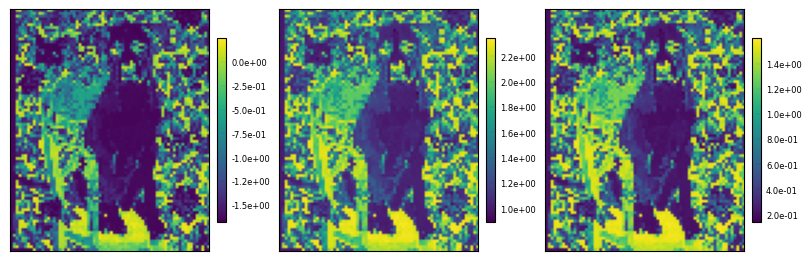

In [39]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


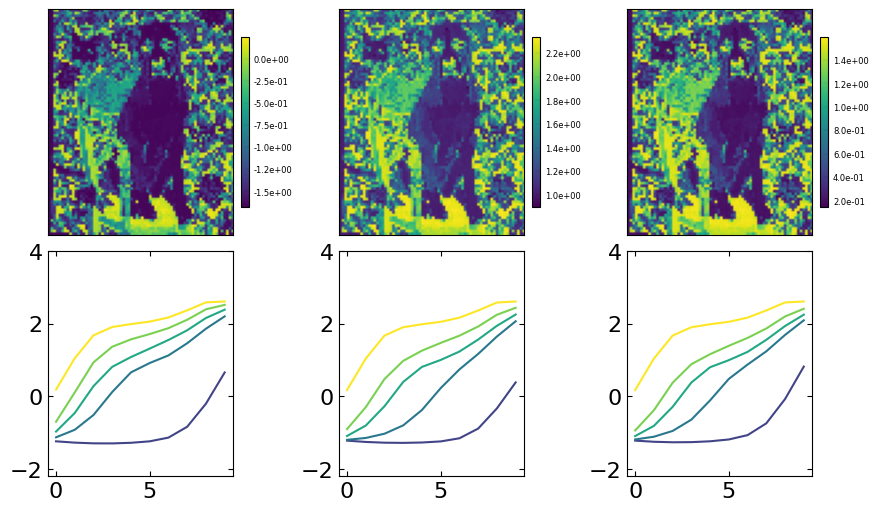

In [40]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


- This once again is very hard to interpret and the spectra do not really contain the necessary details


## Disentanglement

### Regularization

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/L1_reg.png?raw=true)


### Builds the Model


In [41]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [42]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [43]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [45]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [46]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3, # adds a regularization term l1
    mse=False,
    device=device,
)


100%|██████████| 19/19 [00:00<00:00, 27.46it/s]


Epoch 0, Train Loss: 2.1840
.............................


100%|██████████| 19/19 [00:00<00:00, 74.93it/s]


Epoch 1, Train Loss: 2.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 75.33it/s]


Epoch 2, Train Loss: 2.1666
.............................


100%|██████████| 19/19 [00:00<00:00, 76.95it/s]


Epoch 3, Train Loss: 2.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 71.28it/s]


Epoch 4, Train Loss: 2.1497
.............................


100%|██████████| 19/19 [00:00<00:00, 72.96it/s]


Epoch 5, Train Loss: 2.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 67.81it/s]


Epoch 6, Train Loss: 2.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 90.83it/s]


Epoch 7, Train Loss: 2.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 106.90it/s]


Epoch 8, Train Loss: 2.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 113.80it/s]


Epoch 9, Train Loss: 2.1088
.............................


100%|██████████| 19/19 [00:00<00:00, 105.37it/s]


Epoch 10, Train Loss: 2.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 106.75it/s]


Epoch 11, Train Loss: 2.0927
.............................


100%|██████████| 19/19 [00:00<00:00, 117.10it/s]


Epoch 12, Train Loss: 2.0848
.............................


100%|██████████| 19/19 [00:00<00:00, 116.28it/s]


Epoch 13, Train Loss: 2.0770
.............................


100%|██████████| 19/19 [00:00<00:00, 107.54it/s]


Epoch 14, Train Loss: 2.0693
.............................


100%|██████████| 19/19 [00:00<00:00, 115.42it/s]


Epoch 15, Train Loss: 2.0616
.............................


100%|██████████| 19/19 [00:00<00:00, 118.43it/s]


Epoch 16, Train Loss: 2.0540
.............................


100%|██████████| 19/19 [00:00<00:00, 111.50it/s]


Epoch 17, Train Loss: 2.0464
.............................


100%|██████████| 19/19 [00:00<00:00, 117.03it/s]


Epoch 18, Train Loss: 2.0389
.............................


100%|██████████| 19/19 [00:00<00:00, 115.04it/s]


Epoch 19, Train Loss: 2.0315
.............................


100%|██████████| 19/19 [00:00<00:00, 106.32it/s]


Epoch 20, Train Loss: 2.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 113.91it/s]


Epoch 21, Train Loss: 2.0170
.............................


100%|██████████| 19/19 [00:00<00:00, 113.21it/s]


Epoch 22, Train Loss: 2.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 115.03it/s]


Epoch 23, Train Loss: 2.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 111.84it/s]


Epoch 24, Train Loss: 1.9958
.............................


100%|██████████| 19/19 [00:00<00:00, 116.53it/s]


Epoch 25, Train Loss: 1.9888
.............................


100%|██████████| 19/19 [00:00<00:00, 103.61it/s]


Epoch 26, Train Loss: 1.9819
.............................


100%|██████████| 19/19 [00:00<00:00, 115.49it/s]


Epoch 27, Train Loss: 1.9749
.............................


100%|██████████| 19/19 [00:00<00:00, 114.69it/s]


Epoch 28, Train Loss: 1.9679
.............................


100%|██████████| 19/19 [00:00<00:00, 113.87it/s]


Epoch 29, Train Loss: 1.9611
.............................


100%|██████████| 19/19 [00:00<00:00, 116.14it/s]


Epoch 30, Train Loss: 1.9546
.............................


100%|██████████| 19/19 [00:00<00:00, 118.08it/s]


Epoch 31, Train Loss: 1.9482
.............................


100%|██████████| 19/19 [00:00<00:00, 105.38it/s]


Epoch 32, Train Loss: 1.9419
.............................


100%|██████████| 19/19 [00:00<00:00, 110.51it/s]


Epoch 33, Train Loss: 1.9357
.............................


100%|██████████| 19/19 [00:00<00:00, 115.12it/s]


Epoch 34, Train Loss: 1.9296
.............................


100%|██████████| 19/19 [00:00<00:00, 118.00it/s]


Epoch 35, Train Loss: 1.9235
.............................


100%|██████████| 19/19 [00:00<00:00, 113.08it/s]


Epoch 36, Train Loss: 1.9176
.............................


100%|██████████| 19/19 [00:00<00:00, 118.15it/s]


Epoch 37, Train Loss: 1.9117
.............................


100%|██████████| 19/19 [00:00<00:00, 104.37it/s]


Epoch 38, Train Loss: 1.9058
.............................


100%|██████████| 19/19 [00:00<00:00, 111.52it/s]


Epoch 39, Train Loss: 1.8999
.............................


100%|██████████| 19/19 [00:00<00:00, 116.64it/s]


Epoch 40, Train Loss: 1.8940
.............................


100%|██████████| 19/19 [00:00<00:00, 114.38it/s]


Epoch 41, Train Loss: 1.8882
.............................


100%|██████████| 19/19 [00:00<00:00, 115.81it/s]


Epoch 42, Train Loss: 1.8824
.............................


100%|██████████| 19/19 [00:00<00:00, 116.55it/s]


Epoch 43, Train Loss: 1.8766
.............................


100%|██████████| 19/19 [00:00<00:00, 106.35it/s]


Epoch 44, Train Loss: 1.8707
.............................


100%|██████████| 19/19 [00:00<00:00, 114.37it/s]


Epoch 45, Train Loss: 1.8648
.............................


100%|██████████| 19/19 [00:00<00:00, 114.11it/s]


Epoch 46, Train Loss: 1.8589
.............................


100%|██████████| 19/19 [00:00<00:00, 114.93it/s]


Epoch 47, Train Loss: 1.8534
.............................


100%|██████████| 19/19 [00:00<00:00, 114.70it/s]


Epoch 48, Train Loss: 1.8478
.............................


100%|██████████| 19/19 [00:00<00:00, 109.62it/s]


Epoch 49, Train Loss: 1.8423
.............................


100%|██████████| 19/19 [00:00<00:00, 105.29it/s]


Epoch 50, Train Loss: 1.8367
.............................


100%|██████████| 19/19 [00:00<00:00, 117.86it/s]


Epoch 51, Train Loss: 1.8312
.............................


100%|██████████| 19/19 [00:00<00:00, 113.77it/s]


Epoch 52, Train Loss: 1.8255
.............................


100%|██████████| 19/19 [00:00<00:00, 115.82it/s]


Epoch 53, Train Loss: 1.8199
.............................


100%|██████████| 19/19 [00:00<00:00, 112.70it/s]


Epoch 54, Train Loss: 1.8141
.............................


100%|██████████| 19/19 [00:00<00:00, 115.36it/s]


Epoch 55, Train Loss: 1.8082
.............................


100%|██████████| 19/19 [00:00<00:00, 104.47it/s]


Epoch 56, Train Loss: 1.8023
.............................


100%|██████████| 19/19 [00:00<00:00, 114.38it/s]


Epoch 57, Train Loss: 1.7962
.............................


100%|██████████| 19/19 [00:00<00:00, 111.70it/s]


Epoch 58, Train Loss: 1.7900
.............................


100%|██████████| 19/19 [00:00<00:00, 112.53it/s]


Epoch 59, Train Loss: 1.7837
.............................


100%|██████████| 19/19 [00:00<00:00, 118.23it/s]


Epoch 60, Train Loss: 1.7773
.............................


100%|██████████| 19/19 [00:00<00:00, 113.30it/s]


Epoch 61, Train Loss: 1.7707
.............................


100%|██████████| 19/19 [00:00<00:00, 105.43it/s]


Epoch 62, Train Loss: 1.7640
.............................


100%|██████████| 19/19 [00:00<00:00, 112.61it/s]


Epoch 63, Train Loss: 1.7573
.............................


100%|██████████| 19/19 [00:00<00:00, 113.50it/s]


Epoch 64, Train Loss: 1.7504
.............................


100%|██████████| 19/19 [00:00<00:00, 74.53it/s]


Epoch 65, Train Loss: 1.7435
.............................


100%|██████████| 19/19 [00:00<00:00, 69.72it/s]


Epoch 66, Train Loss: 1.7365
.............................


100%|██████████| 19/19 [00:00<00:00, 67.55it/s]


Epoch 67, Train Loss: 1.7294
.............................


100%|██████████| 19/19 [00:00<00:00, 70.71it/s]


Epoch 68, Train Loss: 1.7221
.............................


100%|██████████| 19/19 [00:00<00:00, 76.01it/s]


Epoch 69, Train Loss: 1.7147
.............................


100%|██████████| 19/19 [00:00<00:00, 74.28it/s]


Epoch 70, Train Loss: 1.7072
.............................


100%|██████████| 19/19 [00:00<00:00, 69.03it/s]


Epoch 71, Train Loss: 1.6994
.............................


100%|██████████| 19/19 [00:00<00:00, 71.51it/s]


Epoch 72, Train Loss: 1.6916
.............................


100%|██████████| 19/19 [00:00<00:00, 100.21it/s]


Epoch 73, Train Loss: 1.6836
.............................


100%|██████████| 19/19 [00:00<00:00, 115.43it/s]


Epoch 74, Train Loss: 1.6754
.............................


100%|██████████| 19/19 [00:00<00:00, 117.85it/s]


Epoch 75, Train Loss: 1.6672
.............................


100%|██████████| 19/19 [00:00<00:00, 102.04it/s]


Epoch 76, Train Loss: 1.6588
.............................


100%|██████████| 19/19 [00:00<00:00, 114.53it/s]


Epoch 77, Train Loss: 1.6503
.............................


100%|██████████| 19/19 [00:00<00:00, 111.16it/s]


Epoch 78, Train Loss: 1.6416
.............................


100%|██████████| 19/19 [00:00<00:00, 111.76it/s]


Epoch 79, Train Loss: 1.6329
.............................


100%|██████████| 19/19 [00:00<00:00, 115.15it/s]


Epoch 80, Train Loss: 1.6240
.............................


100%|██████████| 19/19 [00:00<00:00, 114.99it/s]


Epoch 81, Train Loss: 1.6150
.............................


100%|██████████| 19/19 [00:00<00:00, 108.79it/s]


Epoch 82, Train Loss: 1.6059
.............................


100%|██████████| 19/19 [00:00<00:00, 112.59it/s]


Epoch 83, Train Loss: 1.5967
.............................


100%|██████████| 19/19 [00:00<00:00, 113.45it/s]


Epoch 84, Train Loss: 1.5875
.............................


100%|██████████| 19/19 [00:00<00:00, 114.05it/s]


Epoch 85, Train Loss: 1.5781
.............................


100%|██████████| 19/19 [00:00<00:00, 105.51it/s]


Epoch 86, Train Loss: 1.5686
.............................


100%|██████████| 19/19 [00:00<00:00, 104.31it/s]


Epoch 87, Train Loss: 1.5590
.............................


100%|██████████| 19/19 [00:00<00:00, 105.57it/s]


Epoch 88, Train Loss: 1.5493
.............................


100%|██████████| 19/19 [00:00<00:00, 110.69it/s]


Epoch 89, Train Loss: 1.5394
.............................


100%|██████████| 19/19 [00:00<00:00, 114.94it/s]


Epoch 90, Train Loss: 1.5295
.............................


100%|██████████| 19/19 [00:00<00:00, 113.74it/s]


Epoch 91, Train Loss: 1.5194
.............................


100%|██████████| 19/19 [00:00<00:00, 114.26it/s]


Epoch 92, Train Loss: 1.5093
.............................


100%|██████████| 19/19 [00:00<00:00, 108.29it/s]


Epoch 93, Train Loss: 1.4992
.............................


100%|██████████| 19/19 [00:00<00:00, 109.85it/s]


Epoch 94, Train Loss: 1.4890
.............................


100%|██████████| 19/19 [00:00<00:00, 116.16it/s]


Epoch 95, Train Loss: 1.4787
.............................


100%|██████████| 19/19 [00:00<00:00, 117.59it/s]


Epoch 96, Train Loss: 1.4684
.............................


100%|██████████| 19/19 [00:00<00:00, 116.20it/s]


Epoch 97, Train Loss: 1.4581
.............................


100%|██████████| 19/19 [00:00<00:00, 113.10it/s]


Epoch 98, Train Loss: 1.4478
.............................


100%|██████████| 19/19 [00:00<00:00, 114.37it/s]


Epoch 99, Train Loss: 1.4376
.............................


100%|██████████| 19/19 [00:00<00:00, 111.62it/s]


Epoch 100, Train Loss: 1.4273
.............................


100%|██████████| 19/19 [00:00<00:00, 115.97it/s]


Epoch 101, Train Loss: 1.4171
.............................


100%|██████████| 19/19 [00:00<00:00, 118.30it/s]


Epoch 102, Train Loss: 1.4069
.............................


100%|██████████| 19/19 [00:00<00:00, 116.37it/s]


Epoch 103, Train Loss: 1.3967
.............................


100%|██████████| 19/19 [00:00<00:00, 114.86it/s]


Epoch 104, Train Loss: 1.3866
.............................


100%|██████████| 19/19 [00:00<00:00, 116.59it/s]


Epoch 105, Train Loss: 1.3766
.............................


100%|██████████| 19/19 [00:00<00:00, 105.25it/s]


Epoch 106, Train Loss: 1.3667
.............................


100%|██████████| 19/19 [00:00<00:00, 114.87it/s]


Epoch 107, Train Loss: 1.3568
.............................


100%|██████████| 19/19 [00:00<00:00, 116.09it/s]


Epoch 108, Train Loss: 1.3470
.............................


100%|██████████| 19/19 [00:00<00:00, 109.16it/s]


Epoch 109, Train Loss: 1.3373
.............................


100%|██████████| 19/19 [00:00<00:00, 117.68it/s]


Epoch 110, Train Loss: 1.3277
.............................


100%|██████████| 19/19 [00:00<00:00, 111.55it/s]


Epoch 111, Train Loss: 1.3182
.............................


100%|██████████| 19/19 [00:00<00:00, 106.48it/s]


Epoch 112, Train Loss: 1.3088
.............................


100%|██████████| 19/19 [00:00<00:00, 116.40it/s]


Epoch 113, Train Loss: 1.2995
.............................


100%|██████████| 19/19 [00:00<00:00, 113.97it/s]


Epoch 114, Train Loss: 1.2902
.............................


100%|██████████| 19/19 [00:00<00:00, 115.73it/s]


Epoch 115, Train Loss: 1.2811
.............................


100%|██████████| 19/19 [00:00<00:00, 114.30it/s]


Epoch 116, Train Loss: 1.2720
.............................


100%|██████████| 19/19 [00:00<00:00, 117.98it/s]


Epoch 117, Train Loss: 1.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 106.30it/s]


Epoch 118, Train Loss: 1.2542
.............................


100%|██████████| 19/19 [00:00<00:00, 116.02it/s]


Epoch 119, Train Loss: 1.2455
.............................


100%|██████████| 19/19 [00:00<00:00, 114.82it/s]


Epoch 120, Train Loss: 1.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 102.03it/s]


Epoch 121, Train Loss: 1.2286
.............................


100%|██████████| 19/19 [00:00<00:00, 116.82it/s]


Epoch 122, Train Loss: 1.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 114.82it/s]


Epoch 123, Train Loss: 1.2123
.............................


100%|██████████| 19/19 [00:00<00:00, 105.50it/s]


Epoch 124, Train Loss: 1.2043
.............................


100%|██████████| 19/19 [00:00<00:00, 116.01it/s]


Epoch 125, Train Loss: 1.1966
.............................


100%|██████████| 19/19 [00:00<00:00, 112.97it/s]


Epoch 126, Train Loss: 1.1890
.............................


100%|██████████| 19/19 [00:00<00:00, 116.13it/s]


Epoch 127, Train Loss: 1.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 112.09it/s]


Epoch 128, Train Loss: 1.1743
.............................


100%|██████████| 19/19 [00:00<00:00, 115.61it/s]


Epoch 129, Train Loss: 1.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 105.90it/s]


Epoch 130, Train Loss: 1.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 71.38it/s]


Epoch 131, Train Loss: 1.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 74.99it/s]


Epoch 132, Train Loss: 1.1468
.............................


100%|██████████| 19/19 [00:00<00:00, 76.88it/s]


Epoch 133, Train Loss: 1.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 72.55it/s]


Epoch 134, Train Loss: 1.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 70.24it/s]


Epoch 135, Train Loss: 1.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 77.21it/s]


Epoch 136, Train Loss: 1.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 72.29it/s]


Epoch 137, Train Loss: 1.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 69.45it/s]


Epoch 138, Train Loss: 1.1103
.............................


100%|██████████| 19/19 [00:00<00:00, 76.36it/s]


Epoch 139, Train Loss: 1.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 111.01it/s]


Epoch 140, Train Loss: 1.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 109.73it/s]


Epoch 141, Train Loss: 1.0940
.............................


100%|██████████| 19/19 [00:00<00:00, 114.34it/s]


Epoch 142, Train Loss: 1.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 103.79it/s]


Epoch 143, Train Loss: 1.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 113.08it/s]


Epoch 144, Train Loss: 1.0787
.............................


100%|██████████| 19/19 [00:00<00:00, 111.15it/s]


Epoch 145, Train Loss: 1.0738
.............................


100%|██████████| 19/19 [00:00<00:00, 112.86it/s]


Epoch 146, Train Loss: 1.0690
.............................


100%|██████████| 19/19 [00:00<00:00, 114.12it/s]


Epoch 147, Train Loss: 1.0642
.............................


100%|██████████| 19/19 [00:00<00:00, 109.83it/s]


Epoch 148, Train Loss: 1.0595
.............................


100%|██████████| 19/19 [00:00<00:00, 103.19it/s]


Epoch 149, Train Loss: 1.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 114.41it/s]


Epoch 150, Train Loss: 1.0502
.............................


100%|██████████| 19/19 [00:00<00:00, 112.40it/s]


Epoch 151, Train Loss: 1.0457
.............................


100%|██████████| 19/19 [00:00<00:00, 110.11it/s]


Epoch 152, Train Loss: 1.0411
.............................


100%|██████████| 19/19 [00:00<00:00, 113.26it/s]


Epoch 153, Train Loss: 1.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 111.01it/s]


Epoch 154, Train Loss: 1.0319
.............................


100%|██████████| 19/19 [00:00<00:00, 106.37it/s]


Epoch 155, Train Loss: 1.0273
.............................


100%|██████████| 19/19 [00:00<00:00, 113.46it/s]


Epoch 156, Train Loss: 1.0226
.............................


100%|██████████| 19/19 [00:00<00:00, 114.38it/s]


Epoch 157, Train Loss: 1.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 111.59it/s]


Epoch 158, Train Loss: 1.0130
.............................


100%|██████████| 19/19 [00:00<00:00, 114.17it/s]


Epoch 159, Train Loss: 1.0081
.............................


100%|██████████| 19/19 [00:00<00:00, 111.76it/s]


Epoch 160, Train Loss: 1.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 105.28it/s]


Epoch 161, Train Loss: 0.9977
.............................


100%|██████████| 19/19 [00:00<00:00, 114.25it/s]


Epoch 162, Train Loss: 0.9923
.............................


100%|██████████| 19/19 [00:00<00:00, 108.46it/s]


Epoch 163, Train Loss: 0.9866
.............................


100%|██████████| 19/19 [00:00<00:00, 111.65it/s]


Epoch 164, Train Loss: 0.9807
.............................


100%|██████████| 19/19 [00:00<00:00, 110.69it/s]


Epoch 165, Train Loss: 0.9745
.............................


100%|██████████| 19/19 [00:00<00:00, 110.72it/s]


Epoch 166, Train Loss: 0.9680
.............................


100%|██████████| 19/19 [00:00<00:00, 99.25it/s]


Epoch 167, Train Loss: 0.9611
.............................


100%|██████████| 19/19 [00:00<00:00, 113.25it/s]


Epoch 168, Train Loss: 0.9538
.............................


100%|██████████| 19/19 [00:00<00:00, 107.71it/s]


Epoch 169, Train Loss: 0.9460
.............................


100%|██████████| 19/19 [00:00<00:00, 112.88it/s]


Epoch 170, Train Loss: 0.9377
.............................


100%|██████████| 19/19 [00:00<00:00, 109.85it/s]


Epoch 171, Train Loss: 0.9289
.............................


100%|██████████| 19/19 [00:00<00:00, 106.07it/s]


Epoch 172, Train Loss: 0.9194
.............................


100%|██████████| 19/19 [00:00<00:00, 99.45it/s] 


Epoch 173, Train Loss: 0.9092
.............................


100%|██████████| 19/19 [00:00<00:00, 107.01it/s]


Epoch 174, Train Loss: 0.8983
.............................


100%|██████████| 19/19 [00:00<00:00, 105.16it/s]


Epoch 175, Train Loss: 0.8866
.............................


100%|██████████| 19/19 [00:00<00:00, 105.92it/s]


Epoch 176, Train Loss: 0.8741
.............................


100%|██████████| 19/19 [00:00<00:00, 106.88it/s]


Epoch 177, Train Loss: 0.8608
.............................


100%|██████████| 19/19 [00:00<00:00, 99.13it/s]


Epoch 178, Train Loss: 0.8466
.............................


100%|██████████| 19/19 [00:00<00:00, 107.92it/s]


Epoch 179, Train Loss: 0.8315
.............................


100%|██████████| 19/19 [00:00<00:00, 107.28it/s]


Epoch 180, Train Loss: 0.8156
.............................


100%|██████████| 19/19 [00:00<00:00, 112.97it/s]


Epoch 181, Train Loss: 0.7990
.............................


100%|██████████| 19/19 [00:00<00:00, 108.39it/s]


Epoch 182, Train Loss: 0.7817
.............................


100%|██████████| 19/19 [00:00<00:00, 109.05it/s]


Epoch 183, Train Loss: 0.7639
.............................


100%|██████████| 19/19 [00:00<00:00, 103.99it/s]


Epoch 184, Train Loss: 0.7454
.............................


100%|██████████| 19/19 [00:00<00:00, 112.27it/s]


Epoch 185, Train Loss: 0.7260
.............................


100%|██████████| 19/19 [00:00<00:00, 112.83it/s]


Epoch 186, Train Loss: 0.7059
.............................


100%|██████████| 19/19 [00:00<00:00, 113.39it/s]


Epoch 187, Train Loss: 0.6858
.............................


100%|██████████| 19/19 [00:00<00:00, 112.68it/s]


Epoch 188, Train Loss: 0.6661
.............................


100%|██████████| 19/19 [00:00<00:00, 113.01it/s]


Epoch 189, Train Loss: 0.6470
.............................


100%|██████████| 19/19 [00:00<00:00, 99.80it/s]


Epoch 190, Train Loss: 0.6288
.............................


100%|██████████| 19/19 [00:00<00:00, 113.60it/s]


Epoch 191, Train Loss: 0.6116
.............................


100%|██████████| 19/19 [00:00<00:00, 108.97it/s]


Epoch 192, Train Loss: 0.5954
.............................


100%|██████████| 19/19 [00:00<00:00, 106.53it/s]


Epoch 193, Train Loss: 0.5802
.............................


100%|██████████| 19/19 [00:00<00:00, 112.11it/s]


Epoch 194, Train Loss: 0.5660
.............................


100%|██████████| 19/19 [00:00<00:00, 100.17it/s]


Epoch 195, Train Loss: 0.5529
.............................


100%|██████████| 19/19 [00:00<00:00, 70.78it/s]


Epoch 196, Train Loss: 0.5407
.............................


100%|██████████| 19/19 [00:00<00:00, 71.31it/s]


Epoch 197, Train Loss: 0.5293
.............................


100%|██████████| 19/19 [00:00<00:00, 72.32it/s]


Epoch 198, Train Loss: 0.5187
.............................


100%|██████████| 19/19 [00:00<00:00, 68.08it/s]


Epoch 199, Train Loss: 0.5089
.............................


100%|██████████| 19/19 [00:00<00:00, 72.33it/s]


Epoch 200, Train Loss: 0.4998
.............................


100%|██████████| 19/19 [00:00<00:00, 70.28it/s]


Epoch 201, Train Loss: 0.4913
.............................


100%|██████████| 19/19 [00:00<00:00, 69.81it/s]


Epoch 202, Train Loss: 0.4834
.............................


100%|██████████| 19/19 [00:00<00:00, 69.07it/s]


Epoch 203, Train Loss: 0.4760
.............................


100%|██████████| 19/19 [00:00<00:00, 89.54it/s]


Epoch 204, Train Loss: 0.4690
.............................


100%|██████████| 19/19 [00:00<00:00, 110.88it/s]


Epoch 205, Train Loss: 0.4625
.............................


100%|██████████| 19/19 [00:00<00:00, 111.24it/s]


Epoch 206, Train Loss: 0.4565
.............................


100%|██████████| 19/19 [00:00<00:00, 104.39it/s]


Epoch 207, Train Loss: 0.4507
.............................


100%|██████████| 19/19 [00:00<00:00, 107.00it/s]


Epoch 208, Train Loss: 0.4453
.............................


100%|██████████| 19/19 [00:00<00:00, 98.15it/s]


Epoch 209, Train Loss: 0.4403
.............................


100%|██████████| 19/19 [00:00<00:00, 110.09it/s]


Epoch 210, Train Loss: 0.4355
.............................


100%|██████████| 19/19 [00:00<00:00, 111.57it/s]


Epoch 211, Train Loss: 0.4309
.............................


100%|██████████| 19/19 [00:00<00:00, 106.98it/s]


Epoch 212, Train Loss: 0.4266
.............................


100%|██████████| 19/19 [00:00<00:00, 105.24it/s]


Epoch 213, Train Loss: 0.4226
.............................


100%|██████████| 19/19 [00:00<00:00, 102.09it/s]


Epoch 214, Train Loss: 0.4187
.............................


100%|██████████| 19/19 [00:00<00:00, 110.37it/s]


Epoch 215, Train Loss: 0.4150
.............................


100%|██████████| 19/19 [00:00<00:00, 112.01it/s]


Epoch 216, Train Loss: 0.4116
.............................


100%|██████████| 19/19 [00:00<00:00, 107.12it/s]


Epoch 217, Train Loss: 0.4083
.............................


100%|██████████| 19/19 [00:00<00:00, 106.98it/s]


Epoch 218, Train Loss: 0.4051
.............................


100%|██████████| 19/19 [00:00<00:00, 111.56it/s]


Epoch 219, Train Loss: 0.4022
.............................


100%|██████████| 19/19 [00:00<00:00, 101.09it/s]


Epoch 220, Train Loss: 0.3993
.............................


100%|██████████| 19/19 [00:00<00:00, 109.30it/s]


Epoch 221, Train Loss: 0.3966
.............................


100%|██████████| 19/19 [00:00<00:00, 103.06it/s]


Epoch 222, Train Loss: 0.3941
.............................


100%|██████████| 19/19 [00:00<00:00, 111.30it/s]


Epoch 223, Train Loss: 0.3916
.............................


100%|██████████| 19/19 [00:00<00:00, 107.29it/s]


Epoch 224, Train Loss: 0.3893
.............................


100%|██████████| 19/19 [00:00<00:00, 107.73it/s]


Epoch 225, Train Loss: 0.3871
.............................


100%|██████████| 19/19 [00:00<00:00, 99.79it/s]


Epoch 226, Train Loss: 0.3850
.............................


100%|██████████| 19/19 [00:00<00:00, 110.98it/s]


Epoch 227, Train Loss: 0.3829
.............................


100%|██████████| 19/19 [00:00<00:00, 110.62it/s]


Epoch 228, Train Loss: 0.3810
.............................


100%|██████████| 19/19 [00:00<00:00, 110.22it/s]


Epoch 229, Train Loss: 0.3792
.............................


100%|██████████| 19/19 [00:00<00:00, 109.16it/s]


Epoch 230, Train Loss: 0.3774
.............................


100%|██████████| 19/19 [00:00<00:00, 102.19it/s]


Epoch 231, Train Loss: 0.3757
.............................


100%|██████████| 19/19 [00:00<00:00, 111.87it/s]


Epoch 232, Train Loss: 0.3740
.............................


100%|██████████| 19/19 [00:00<00:00, 109.47it/s]


Epoch 233, Train Loss: 0.3724
.............................


100%|██████████| 19/19 [00:00<00:00, 111.83it/s]


Epoch 234, Train Loss: 0.3709
.............................


100%|██████████| 19/19 [00:00<00:00, 109.28it/s]


Epoch 235, Train Loss: 0.3694
.............................


100%|██████████| 19/19 [00:00<00:00, 108.91it/s]


Epoch 236, Train Loss: 0.3680
.............................


100%|██████████| 19/19 [00:00<00:00, 102.76it/s]


Epoch 237, Train Loss: 0.3666
.............................


100%|██████████| 19/19 [00:00<00:00, 112.16it/s]


Epoch 238, Train Loss: 0.3652
.............................


100%|██████████| 19/19 [00:00<00:00, 113.07it/s]


Epoch 239, Train Loss: 0.3639
.............................


100%|██████████| 19/19 [00:00<00:00, 110.20it/s]


Epoch 240, Train Loss: 0.3626
.............................


100%|██████████| 19/19 [00:00<00:00, 110.93it/s]


Epoch 241, Train Loss: 0.3614
.............................


100%|██████████| 19/19 [00:00<00:00, 109.85it/s]


Epoch 242, Train Loss: 0.3601
.............................


100%|██████████| 19/19 [00:00<00:00, 99.05it/s]


Epoch 243, Train Loss: 0.3590
.............................


100%|██████████| 19/19 [00:00<00:00, 109.77it/s]


Epoch 244, Train Loss: 0.3578
.............................


100%|██████████| 19/19 [00:00<00:00, 108.02it/s]


Epoch 245, Train Loss: 0.3566
.............................


100%|██████████| 19/19 [00:00<00:00, 105.21it/s]


Epoch 246, Train Loss: 0.3555
.............................


100%|██████████| 19/19 [00:00<00:00, 112.21it/s]


Epoch 247, Train Loss: 0.3544
.............................


100%|██████████| 19/19 [00:00<00:00, 109.94it/s]


Epoch 248, Train Loss: 0.3533
.............................


100%|██████████| 19/19 [00:00<00:00, 102.63it/s]


Epoch 249, Train Loss: 0.3523
.............................


100%|██████████| 19/19 [00:00<00:00, 110.34it/s]


Epoch 250, Train Loss: 0.3513
.............................


100%|██████████| 19/19 [00:00<00:00, 111.07it/s]


Epoch 251, Train Loss: 0.3502
.............................


100%|██████████| 19/19 [00:00<00:00, 103.97it/s]


Epoch 252, Train Loss: 0.3492
.............................


100%|██████████| 19/19 [00:00<00:00, 112.21it/s]


Epoch 253, Train Loss: 0.3483
.............................


100%|██████████| 19/19 [00:00<00:00, 103.12it/s]


Epoch 254, Train Loss: 0.3473
.............................


100%|██████████| 19/19 [00:00<00:00, 109.73it/s]


Epoch 255, Train Loss: 0.3463
.............................


100%|██████████| 19/19 [00:00<00:00, 112.44it/s]


Epoch 256, Train Loss: 0.3454
.............................


100%|██████████| 19/19 [00:00<00:00, 110.09it/s]


Epoch 257, Train Loss: 0.3445
.............................


100%|██████████| 19/19 [00:00<00:00, 113.00it/s]


Epoch 258, Train Loss: 0.3436
.............................


100%|██████████| 19/19 [00:00<00:00, 107.60it/s]


Epoch 259, Train Loss: 0.3427
.............................


100%|██████████| 19/19 [00:00<00:00, 67.32it/s]


Epoch 260, Train Loss: 0.3418
.............................


100%|██████████| 19/19 [00:00<00:00, 70.29it/s]


Epoch 261, Train Loss: 0.3409
.............................


100%|██████████| 19/19 [00:00<00:00, 70.21it/s]


Epoch 262, Train Loss: 0.3400
.............................


100%|██████████| 19/19 [00:00<00:00, 70.93it/s]


Epoch 263, Train Loss: 0.3391
.............................


100%|██████████| 19/19 [00:00<00:00, 68.24it/s]


Epoch 264, Train Loss: 0.3383
.............................


100%|██████████| 19/19 [00:00<00:00, 71.41it/s]


Epoch 265, Train Loss: 0.3374
.............................


100%|██████████| 19/19 [00:00<00:00, 69.47it/s]


Epoch 266, Train Loss: 0.3366
.............................


100%|██████████| 19/19 [00:00<00:00, 68.48it/s]


Epoch 267, Train Loss: 0.3357
.............................


100%|██████████| 19/19 [00:00<00:00, 89.29it/s]


Epoch 268, Train Loss: 0.3349
.............................


100%|██████████| 19/19 [00:00<00:00, 75.12it/s]


Epoch 269, Train Loss: 0.3341
.............................


100%|██████████| 19/19 [00:00<00:00, 71.06it/s]


Epoch 270, Train Loss: 0.3333
.............................


100%|██████████| 19/19 [00:00<00:00, 71.07it/s]


Epoch 271, Train Loss: 0.3325
.............................


100%|██████████| 19/19 [00:00<00:00, 64.80it/s]


Epoch 272, Train Loss: 0.3317
.............................


100%|██████████| 19/19 [00:00<00:00, 74.76it/s]


Epoch 273, Train Loss: 0.3309
.............................


100%|██████████| 19/19 [00:00<00:00, 74.70it/s]


Epoch 274, Train Loss: 0.3302
.............................


100%|██████████| 19/19 [00:00<00:00, 63.06it/s]


Epoch 275, Train Loss: 0.3294
.............................


100%|██████████| 19/19 [00:00<00:00, 64.62it/s]


Epoch 276, Train Loss: 0.3286
.............................


100%|██████████| 19/19 [00:00<00:00, 67.84it/s]


Epoch 277, Train Loss: 0.3278
.............................


100%|██████████| 19/19 [00:00<00:00, 112.97it/s]


Epoch 278, Train Loss: 0.3271
.............................


100%|██████████| 19/19 [00:00<00:00, 109.22it/s]


Epoch 279, Train Loss: 0.3263
.............................


100%|██████████| 19/19 [00:00<00:00, 100.67it/s]


Epoch 280, Train Loss: 0.3256
.............................


100%|██████████| 19/19 [00:00<00:00, 109.24it/s]


Epoch 281, Train Loss: 0.3248
.............................


100%|██████████| 19/19 [00:00<00:00, 112.81it/s]


Epoch 282, Train Loss: 0.3241
.............................


100%|██████████| 19/19 [00:00<00:00, 114.61it/s]


Epoch 283, Train Loss: 0.3234
.............................


100%|██████████| 19/19 [00:00<00:00, 111.85it/s]


Epoch 284, Train Loss: 0.3226
.............................


100%|██████████| 19/19 [00:00<00:00, 110.13it/s]


Epoch 285, Train Loss: 0.3219
.............................


100%|██████████| 19/19 [00:00<00:00, 103.63it/s]


Epoch 286, Train Loss: 0.3212
.............................


100%|██████████| 19/19 [00:00<00:00, 94.40it/s]


Epoch 287, Train Loss: 0.3205
.............................


100%|██████████| 19/19 [00:00<00:00, 111.14it/s]


Epoch 288, Train Loss: 0.3198
.............................


100%|██████████| 19/19 [00:00<00:00, 111.65it/s]


Epoch 289, Train Loss: 0.3191
.............................


100%|██████████| 19/19 [00:00<00:00, 106.93it/s]


Epoch 290, Train Loss: 0.3184
.............................


100%|██████████| 19/19 [00:00<00:00, 106.46it/s]


Epoch 291, Train Loss: 0.3177
.............................


100%|██████████| 19/19 [00:00<00:00, 98.14it/s]


Epoch 292, Train Loss: 0.3170
.............................


100%|██████████| 19/19 [00:00<00:00, 108.39it/s]


Epoch 293, Train Loss: 0.3163
.............................


100%|██████████| 19/19 [00:00<00:00, 111.23it/s]


Epoch 294, Train Loss: 0.3157
.............................


100%|██████████| 19/19 [00:00<00:00, 105.58it/s]


Epoch 295, Train Loss: 0.3150
.............................


100%|██████████| 19/19 [00:00<00:00, 104.23it/s]


Epoch 296, Train Loss: 0.3144
.............................


100%|██████████| 19/19 [00:00<00:00, 101.57it/s]


Epoch 297, Train Loss: 0.3137
.............................


100%|██████████| 19/19 [00:00<00:00, 101.68it/s]


Epoch 298, Train Loss: 0.3131
.............................


100%|██████████| 19/19 [00:00<00:00, 108.89it/s]


Epoch 299, Train Loss: 0.3125
.............................


100%|██████████| 19/19 [00:00<00:00, 111.25it/s]


Epoch 300, Train Loss: 0.3119
.............................


100%|██████████| 19/19 [00:00<00:00, 111.25it/s]


Epoch 301, Train Loss: 0.3113
.............................


100%|██████████| 19/19 [00:00<00:00, 105.65it/s]


Epoch 302, Train Loss: 0.3107
.............................


100%|██████████| 19/19 [00:00<00:00, 100.55it/s]


Epoch 303, Train Loss: 0.3101
.............................


100%|██████████| 19/19 [00:00<00:00, 108.93it/s]


Epoch 304, Train Loss: 0.3095
.............................


100%|██████████| 19/19 [00:00<00:00, 113.50it/s]


Epoch 305, Train Loss: 0.3090
.............................


100%|██████████| 19/19 [00:00<00:00, 106.93it/s]


Epoch 306, Train Loss: 0.3084
.............................


100%|██████████| 19/19 [00:00<00:00, 105.81it/s]


Epoch 307, Train Loss: 0.3079
.............................


100%|██████████| 19/19 [00:00<00:00, 109.44it/s]


Epoch 308, Train Loss: 0.3073
.............................


100%|██████████| 19/19 [00:00<00:00, 100.06it/s]


Epoch 309, Train Loss: 0.3068
.............................


100%|██████████| 19/19 [00:00<00:00, 105.99it/s]


Epoch 310, Train Loss: 0.3063
.............................


100%|██████████| 19/19 [00:00<00:00, 111.00it/s]


Epoch 311, Train Loss: 0.3058
.............................


100%|██████████| 19/19 [00:00<00:00, 108.89it/s]


Epoch 312, Train Loss: 0.3053
.............................


100%|██████████| 19/19 [00:00<00:00, 109.87it/s]


Epoch 313, Train Loss: 0.3048
.............................


100%|██████████| 19/19 [00:00<00:00, 102.93it/s]


Epoch 314, Train Loss: 0.3043
.............................


100%|██████████| 19/19 [00:00<00:00, 110.52it/s]


Epoch 315, Train Loss: 0.3039
.............................


100%|██████████| 19/19 [00:00<00:00, 109.64it/s]


Epoch 316, Train Loss: 0.3034
.............................


100%|██████████| 19/19 [00:00<00:00, 108.89it/s]


Epoch 317, Train Loss: 0.3029
.............................


100%|██████████| 19/19 [00:00<00:00, 82.92it/s] 


Epoch 318, Train Loss: 0.3025
.............................


100%|██████████| 19/19 [00:00<00:00, 67.08it/s]


Epoch 319, Train Loss: 0.3020
.............................


100%|██████████| 19/19 [00:00<00:00, 71.71it/s]


Epoch 320, Train Loss: 0.3016
.............................


100%|██████████| 19/19 [00:00<00:00, 75.03it/s]


Epoch 321, Train Loss: 0.3011
.............................


100%|██████████| 19/19 [00:00<00:00, 74.16it/s]


Epoch 322, Train Loss: 0.3007
.............................


100%|██████████| 19/19 [00:00<00:00, 68.06it/s]


Epoch 323, Train Loss: 0.3003
.............................


100%|██████████| 19/19 [00:00<00:00, 69.03it/s]


Epoch 324, Train Loss: 0.2998
.............................


100%|██████████| 19/19 [00:00<00:00, 66.86it/s]


Epoch 325, Train Loss: 0.2994
.............................


100%|██████████| 19/19 [00:00<00:00, 66.14it/s]


Epoch 326, Train Loss: 0.2990
.............................


100%|██████████| 19/19 [00:00<00:00, 99.42it/s] 


Epoch 327, Train Loss: 0.2986
.............................


100%|██████████| 19/19 [00:00<00:00, 108.54it/s]


Epoch 328, Train Loss: 0.2982
.............................


100%|██████████| 19/19 [00:00<00:00, 108.57it/s]


Epoch 329, Train Loss: 0.2977
.............................


100%|██████████| 19/19 [00:00<00:00, 105.33it/s]


Epoch 330, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 105.19it/s]


Epoch 331, Train Loss: 0.2969
.............................


100%|██████████| 19/19 [00:00<00:00, 108.46it/s]


Epoch 332, Train Loss: 0.2965
.............................


100%|██████████| 19/19 [00:00<00:00, 99.12it/s]


Epoch 333, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 108.57it/s]


Epoch 334, Train Loss: 0.2957
.............................


100%|██████████| 19/19 [00:00<00:00, 106.89it/s]


Epoch 335, Train Loss: 0.2953
.............................


100%|██████████| 19/19 [00:00<00:00, 107.71it/s]


Epoch 336, Train Loss: 0.2949
.............................


100%|██████████| 19/19 [00:00<00:00, 107.11it/s]


Epoch 337, Train Loss: 0.2945
.............................


100%|██████████| 19/19 [00:00<00:00, 110.93it/s]


Epoch 338, Train Loss: 0.2941
.............................


100%|██████████| 19/19 [00:00<00:00, 100.57it/s]


Epoch 339, Train Loss: 0.2937
.............................


100%|██████████| 19/19 [00:00<00:00, 109.29it/s]


Epoch 340, Train Loss: 0.2933
.............................


100%|██████████| 19/19 [00:00<00:00, 110.37it/s]


Epoch 341, Train Loss: 0.2929
.............................


100%|██████████| 19/19 [00:00<00:00, 107.72it/s]


Epoch 342, Train Loss: 0.2925
.............................


100%|██████████| 19/19 [00:00<00:00, 108.88it/s]


Epoch 343, Train Loss: 0.2921
.............................


100%|██████████| 19/19 [00:00<00:00, 100.12it/s]


Epoch 344, Train Loss: 0.2917
.............................


100%|██████████| 19/19 [00:00<00:00, 108.78it/s]


Epoch 345, Train Loss: 0.2913
.............................


100%|██████████| 19/19 [00:00<00:00, 110.43it/s]


Epoch 346, Train Loss: 0.2909
.............................


100%|██████████| 19/19 [00:00<00:00, 110.16it/s]


Epoch 347, Train Loss: 0.2904
.............................


100%|██████████| 19/19 [00:00<00:00, 103.89it/s]


Epoch 348, Train Loss: 0.2900
.............................


100%|██████████| 19/19 [00:00<00:00, 108.67it/s]


Epoch 349, Train Loss: 0.2896
.............................


100%|██████████| 19/19 [00:00<00:00, 104.68it/s]


Epoch 350, Train Loss: 0.2892
.............................


100%|██████████| 19/19 [00:00<00:00, 110.24it/s]


Epoch 351, Train Loss: 0.2888
.............................


100%|██████████| 19/19 [00:00<00:00, 108.91it/s]


Epoch 352, Train Loss: 0.2884
.............................


100%|██████████| 19/19 [00:00<00:00, 103.53it/s]


Epoch 353, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 110.64it/s]


Epoch 354, Train Loss: 0.2876
.............................


100%|██████████| 19/19 [00:00<00:00, 105.95it/s]


Epoch 355, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 101.08it/s]


Epoch 356, Train Loss: 0.2868
.............................


100%|██████████| 19/19 [00:00<00:00, 105.17it/s]


Epoch 357, Train Loss: 0.2864
.............................


100%|██████████| 19/19 [00:00<00:00, 108.10it/s]


Epoch 358, Train Loss: 0.2860
.............................


100%|██████████| 19/19 [00:00<00:00, 109.45it/s]


Epoch 359, Train Loss: 0.2856
.............................


100%|██████████| 19/19 [00:00<00:00, 107.72it/s]


Epoch 360, Train Loss: 0.2852
.............................


100%|██████████| 19/19 [00:00<00:00, 102.86it/s]


Epoch 361, Train Loss: 0.2848
.............................


100%|██████████| 19/19 [00:00<00:00, 107.36it/s]


Epoch 362, Train Loss: 0.2844
.............................


100%|██████████| 19/19 [00:00<00:00, 109.61it/s]


Epoch 363, Train Loss: 0.2840
.............................


100%|██████████| 19/19 [00:00<00:00, 104.31it/s]


Epoch 364, Train Loss: 0.2836
.............................


100%|██████████| 19/19 [00:00<00:00, 112.11it/s]


Epoch 365, Train Loss: 0.2832
.............................


100%|██████████| 19/19 [00:00<00:00, 105.22it/s]


Epoch 366, Train Loss: 0.2828
.............................


100%|██████████| 19/19 [00:00<00:00, 101.18it/s]


Epoch 367, Train Loss: 0.2824
.............................


100%|██████████| 19/19 [00:00<00:00, 107.94it/s]


Epoch 368, Train Loss: 0.2820
.............................


100%|██████████| 19/19 [00:00<00:00, 111.08it/s]


Epoch 369, Train Loss: 0.2816
.............................


100%|██████████| 19/19 [00:00<00:00, 103.08it/s]


Epoch 370, Train Loss: 0.2812
.............................


100%|██████████| 19/19 [00:00<00:00, 111.05it/s]


Epoch 371, Train Loss: 0.2808
.............................


100%|██████████| 19/19 [00:00<00:00, 110.10it/s]


Epoch 372, Train Loss: 0.2803
.............................


100%|██████████| 19/19 [00:00<00:00, 101.30it/s]


Epoch 373, Train Loss: 0.2799
.............................


100%|██████████| 19/19 [00:00<00:00, 106.51it/s]


Epoch 374, Train Loss: 0.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 107.40it/s]


Epoch 375, Train Loss: 0.2791
.............................


100%|██████████| 19/19 [00:00<00:00, 108.52it/s]


Epoch 376, Train Loss: 0.2787
.............................


100%|██████████| 19/19 [00:00<00:00, 108.42it/s]


Epoch 377, Train Loss: 0.2783
.............................


100%|██████████| 19/19 [00:00<00:00, 100.36it/s]


Epoch 378, Train Loss: 0.2779
.............................


100%|██████████| 19/19 [00:00<00:00, 112.28it/s]


Epoch 379, Train Loss: 0.2774
.............................


100%|██████████| 19/19 [00:00<00:00, 108.36it/s]


Epoch 380, Train Loss: 0.2770
.............................


100%|██████████| 19/19 [00:00<00:00, 86.77it/s]


Epoch 381, Train Loss: 0.2766
.............................


100%|██████████| 19/19 [00:00<00:00, 69.22it/s]


Epoch 382, Train Loss: 0.2762
.............................


100%|██████████| 19/19 [00:00<00:00, 73.50it/s]


Epoch 383, Train Loss: 0.2758
.............................


100%|██████████| 19/19 [00:00<00:00, 72.33it/s]


Epoch 384, Train Loss: 0.2753
.............................


100%|██████████| 19/19 [00:00<00:00, 72.74it/s]


Epoch 385, Train Loss: 0.2749
.............................


100%|██████████| 19/19 [00:00<00:00, 70.73it/s]


Epoch 386, Train Loss: 0.2745
.............................


100%|██████████| 19/19 [00:00<00:00, 64.83it/s]


Epoch 387, Train Loss: 0.2741
.............................


100%|██████████| 19/19 [00:00<00:00, 66.44it/s]


Epoch 388, Train Loss: 0.2737
.............................


100%|██████████| 19/19 [00:00<00:00, 67.63it/s]


Epoch 389, Train Loss: 0.2733
.............................


100%|██████████| 19/19 [00:00<00:00, 83.89it/s]


Epoch 390, Train Loss: 0.2729
.............................


100%|██████████| 19/19 [00:00<00:00, 94.58it/s] 


Epoch 391, Train Loss: 0.2725
.............................


100%|██████████| 19/19 [00:00<00:00, 107.00it/s]


Epoch 392, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 107.79it/s]


Epoch 393, Train Loss: 0.2716
.............................


100%|██████████| 19/19 [00:00<00:00, 107.85it/s]


Epoch 394, Train Loss: 0.2712
.............................


100%|██████████| 19/19 [00:00<00:00, 103.78it/s]


Epoch 395, Train Loss: 0.2708
.............................


100%|██████████| 19/19 [00:00<00:00, 108.90it/s]


Epoch 396, Train Loss: 0.2704
.............................


100%|██████████| 19/19 [00:00<00:00, 100.25it/s]


Epoch 397, Train Loss: 0.2700
.............................


100%|██████████| 19/19 [00:00<00:00, 96.68it/s]


Epoch 398, Train Loss: 0.2696
.............................


100%|██████████| 19/19 [00:00<00:00, 102.68it/s]


Epoch 399, Train Loss: 0.2692
.............................


100%|██████████| 19/19 [00:00<00:00, 108.73it/s]


Epoch 400, Train Loss: 0.2688
.............................


100%|██████████| 19/19 [00:00<00:00, 108.67it/s]


Epoch 401, Train Loss: 0.2684
.............................


100%|██████████| 19/19 [00:00<00:00, 96.37it/s] 


Epoch 402, Train Loss: 0.2681
.............................


100%|██████████| 19/19 [00:00<00:00, 104.09it/s]


Epoch 403, Train Loss: 0.2677
.............................


100%|██████████| 19/19 [00:00<00:00, 105.68it/s]


Epoch 404, Train Loss: 0.2673
.............................


100%|██████████| 19/19 [00:00<00:00, 106.88it/s]


Epoch 405, Train Loss: 0.2669
.............................


100%|██████████| 19/19 [00:00<00:00, 107.37it/s]


Epoch 406, Train Loss: 0.2665
.............................


100%|██████████| 19/19 [00:00<00:00, 106.20it/s]


Epoch 407, Train Loss: 0.2661
.............................


100%|██████████| 19/19 [00:00<00:00, 98.42it/s]


Epoch 408, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 110.38it/s]


Epoch 409, Train Loss: 0.2653
.............................


100%|██████████| 19/19 [00:00<00:00, 105.11it/s]


Epoch 410, Train Loss: 0.2649
.............................


100%|██████████| 19/19 [00:00<00:00, 105.63it/s]


Epoch 411, Train Loss: 0.2645
.............................


100%|██████████| 19/19 [00:00<00:00, 108.95it/s]


Epoch 412, Train Loss: 0.2641
.............................


100%|██████████| 19/19 [00:00<00:00, 99.96it/s] 


Epoch 413, Train Loss: 0.2638
.............................


100%|██████████| 19/19 [00:00<00:00, 108.07it/s]


Epoch 414, Train Loss: 0.2634
.............................


100%|██████████| 19/19 [00:00<00:00, 106.45it/s]


Epoch 415, Train Loss: 0.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 108.85it/s]


Epoch 416, Train Loss: 0.2626
.............................


100%|██████████| 19/19 [00:00<00:00, 111.60it/s]


Epoch 417, Train Loss: 0.2622
.............................


100%|██████████| 19/19 [00:00<00:00, 109.38it/s]


Epoch 418, Train Loss: 0.2618
.............................


100%|██████████| 19/19 [00:00<00:00, 101.01it/s]


Epoch 419, Train Loss: 0.2614
.............................


100%|██████████| 19/19 [00:00<00:00, 109.70it/s]


Epoch 420, Train Loss: 0.2610
.............................


100%|██████████| 19/19 [00:00<00:00, 109.48it/s]


Epoch 421, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 110.28it/s]


Epoch 422, Train Loss: 0.2603
.............................


100%|██████████| 19/19 [00:00<00:00, 109.59it/s]


Epoch 423, Train Loss: 0.2599
.............................


100%|██████████| 19/19 [00:00<00:00, 105.99it/s]


Epoch 424, Train Loss: 0.2595
.............................


100%|██████████| 19/19 [00:00<00:00, 96.78it/s]


Epoch 425, Train Loss: 0.2591
.............................


100%|██████████| 19/19 [00:00<00:00, 108.34it/s]


Epoch 426, Train Loss: 0.2587
.............................


100%|██████████| 19/19 [00:00<00:00, 105.81it/s]


Epoch 427, Train Loss: 0.2584
.............................


100%|██████████| 19/19 [00:00<00:00, 110.20it/s]


Epoch 428, Train Loss: 0.2580
.............................


100%|██████████| 19/19 [00:00<00:00, 108.68it/s]


Epoch 429, Train Loss: 0.2576
.............................


100%|██████████| 19/19 [00:00<00:00, 96.63it/s] 


Epoch 430, Train Loss: 0.2572
.............................


100%|██████████| 19/19 [00:00<00:00, 109.48it/s]


Epoch 431, Train Loss: 0.2568
.............................


100%|██████████| 19/19 [00:00<00:00, 106.47it/s]


Epoch 432, Train Loss: 0.2564
.............................


100%|██████████| 19/19 [00:00<00:00, 107.90it/s]


Epoch 433, Train Loss: 0.2561
.............................


100%|██████████| 19/19 [00:00<00:00, 104.51it/s]


Epoch 434, Train Loss: 0.2557
.............................


100%|██████████| 19/19 [00:00<00:00, 107.35it/s]


Epoch 435, Train Loss: 0.2553
.............................


100%|██████████| 19/19 [00:00<00:00, 90.87it/s]


Epoch 436, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 105.88it/s]


Epoch 437, Train Loss: 0.2545
.............................


100%|██████████| 19/19 [00:00<00:00, 109.04it/s]


Epoch 438, Train Loss: 0.2541
.............................


100%|██████████| 19/19 [00:00<00:00, 107.93it/s]


Epoch 439, Train Loss: 0.2538
.............................


100%|██████████| 19/19 [00:00<00:00, 106.91it/s]


Epoch 440, Train Loss: 0.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 98.40it/s] 


Epoch 441, Train Loss: 0.2530
.............................


100%|██████████| 19/19 [00:00<00:00, 92.22it/s]


Epoch 442, Train Loss: 0.2526
.............................


100%|██████████| 19/19 [00:00<00:00, 105.70it/s]


Epoch 443, Train Loss: 0.2522
.............................


100%|██████████| 19/19 [00:00<00:00, 75.99it/s]


Epoch 444, Train Loss: 0.2519
.............................


100%|██████████| 19/19 [00:00<00:00, 65.31it/s]


Epoch 445, Train Loss: 0.2515
.............................


100%|██████████| 19/19 [00:00<00:00, 69.23it/s]


Epoch 446, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 70.47it/s]


Epoch 447, Train Loss: 0.2507
.............................


100%|██████████| 19/19 [00:00<00:00, 67.63it/s]


Epoch 448, Train Loss: 0.2503
.............................


100%|██████████| 19/19 [00:00<00:00, 67.93it/s]


Epoch 449, Train Loss: 0.2499
.............................


100%|██████████| 19/19 [00:00<00:00, 62.91it/s]


Epoch 450, Train Loss: 0.2496
.............................


100%|██████████| 19/19 [00:00<00:00, 65.47it/s]


Epoch 451, Train Loss: 0.2492
.............................


100%|██████████| 19/19 [00:00<00:00, 73.02it/s]


Epoch 452, Train Loss: 0.2488
.............................


100%|██████████| 19/19 [00:00<00:00, 105.79it/s]


Epoch 453, Train Loss: 0.2484
.............................


100%|██████████| 19/19 [00:00<00:00, 96.40it/s]


Epoch 454, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 105.99it/s]


Epoch 455, Train Loss: 0.2477
.............................


100%|██████████| 19/19 [00:00<00:00, 109.18it/s]


Epoch 456, Train Loss: 0.2473
.............................


100%|██████████| 19/19 [00:00<00:00, 105.69it/s]


Epoch 457, Train Loss: 0.2469
.............................


100%|██████████| 19/19 [00:00<00:00, 106.04it/s]


Epoch 458, Train Loss: 0.2465
.............................


100%|██████████| 19/19 [00:00<00:00, 100.33it/s]


Epoch 459, Train Loss: 0.2462
.............................


100%|██████████| 19/19 [00:00<00:00, 109.14it/s]


Epoch 460, Train Loss: 0.2458
.............................


100%|██████████| 19/19 [00:00<00:00, 108.52it/s]


Epoch 461, Train Loss: 0.2454
.............................


100%|██████████| 19/19 [00:00<00:00, 101.48it/s]


Epoch 462, Train Loss: 0.2450
.............................


100%|██████████| 19/19 [00:00<00:00, 106.08it/s]


Epoch 463, Train Loss: 0.2447
.............................


100%|██████████| 19/19 [00:00<00:00, 108.69it/s]


Epoch 464, Train Loss: 0.2443
.............................


100%|██████████| 19/19 [00:00<00:00, 96.41it/s]


Epoch 465, Train Loss: 0.2439
.............................


100%|██████████| 19/19 [00:00<00:00, 102.84it/s]


Epoch 466, Train Loss: 0.2435
.............................


100%|██████████| 19/19 [00:00<00:00, 109.30it/s]


Epoch 467, Train Loss: 0.2432
.............................


100%|██████████| 19/19 [00:00<00:00, 106.09it/s]


Epoch 468, Train Loss: 0.2428
.............................


100%|██████████| 19/19 [00:00<00:00, 99.16it/s] 


Epoch 469, Train Loss: 0.2424
.............................


100%|██████████| 19/19 [00:00<00:00, 96.32it/s]


Epoch 470, Train Loss: 0.2420
.............................


100%|██████████| 19/19 [00:00<00:00, 106.46it/s]


Epoch 471, Train Loss: 0.2417
.............................


100%|██████████| 19/19 [00:00<00:00, 105.61it/s]


Epoch 472, Train Loss: 0.2413
.............................


100%|██████████| 19/19 [00:00<00:00, 108.00it/s]


Epoch 473, Train Loss: 0.2409
.............................


100%|██████████| 19/19 [00:00<00:00, 103.18it/s]


Epoch 474, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 103.26it/s]


Epoch 475, Train Loss: 0.2402
.............................


100%|██████████| 19/19 [00:00<00:00, 99.96it/s]


Epoch 476, Train Loss: 0.2398
.............................


100%|██████████| 19/19 [00:00<00:00, 106.83it/s]


Epoch 477, Train Loss: 0.2394
.............................


100%|██████████| 19/19 [00:00<00:00, 102.86it/s]


Epoch 478, Train Loss: 0.2391
.............................


100%|██████████| 19/19 [00:00<00:00, 103.25it/s]


Epoch 479, Train Loss: 0.2387
.............................


100%|██████████| 19/19 [00:00<00:00, 104.69it/s]


Epoch 480, Train Loss: 0.2383
.............................


100%|██████████| 19/19 [00:00<00:00, 99.90it/s] 


Epoch 481, Train Loss: 0.2380
.............................


100%|██████████| 19/19 [00:00<00:00, 107.85it/s]


Epoch 482, Train Loss: 0.2376
.............................


100%|██████████| 19/19 [00:00<00:00, 110.58it/s]


Epoch 483, Train Loss: 0.2372
.............................


100%|██████████| 19/19 [00:00<00:00, 103.06it/s]


Epoch 484, Train Loss: 0.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 107.34it/s]


Epoch 485, Train Loss: 0.2365
.............................


100%|██████████| 19/19 [00:00<00:00, 108.44it/s]


Epoch 486, Train Loss: 0.2361
.............................


100%|██████████| 19/19 [00:00<00:00, 100.24it/s]


Epoch 487, Train Loss: 0.2358
.............................


100%|██████████| 19/19 [00:00<00:00, 109.91it/s]


Epoch 488, Train Loss: 0.2354
.............................


100%|██████████| 19/19 [00:00<00:00, 107.23it/s]


Epoch 489, Train Loss: 0.2350
.............................


100%|██████████| 19/19 [00:00<00:00, 106.73it/s]


Epoch 490, Train Loss: 0.2347
.............................


100%|██████████| 19/19 [00:00<00:00, 102.53it/s]


Epoch 491, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 105.41it/s]


Epoch 492, Train Loss: 0.2339
.............................


100%|██████████| 19/19 [00:00<00:00, 99.57it/s]


Epoch 493, Train Loss: 0.2336
.............................


100%|██████████| 19/19 [00:00<00:00, 105.53it/s]


Epoch 494, Train Loss: 0.2332
.............................


100%|██████████| 19/19 [00:00<00:00, 105.37it/s]


Epoch 495, Train Loss: 0.2329
.............................


100%|██████████| 19/19 [00:00<00:00, 102.66it/s]


Epoch 496, Train Loss: 0.2325
.............................


100%|██████████| 19/19 [00:00<00:00, 107.60it/s]


Epoch 497, Train Loss: 0.2321
.............................


100%|██████████| 19/19 [00:00<00:00, 99.70it/s] 


Epoch 498, Train Loss: 0.2318
.............................


100%|██████████| 19/19 [00:00<00:00, 104.18it/s]

Epoch 499, Train Loss: 0.2314
.............................


### Validation


In [47]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


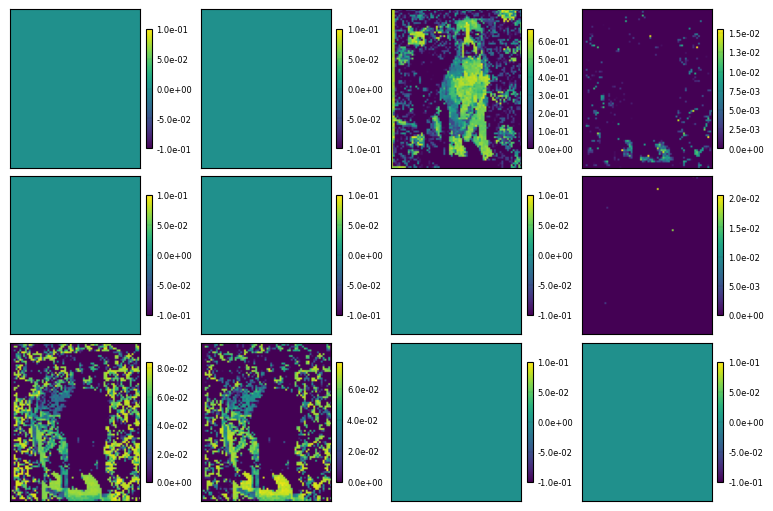

In [48]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


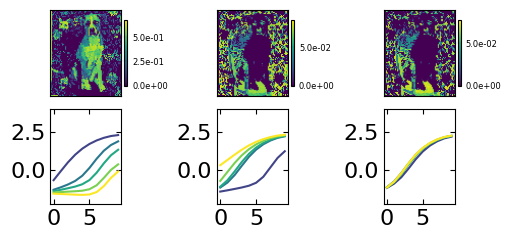

In [49]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[2, 8, 9])


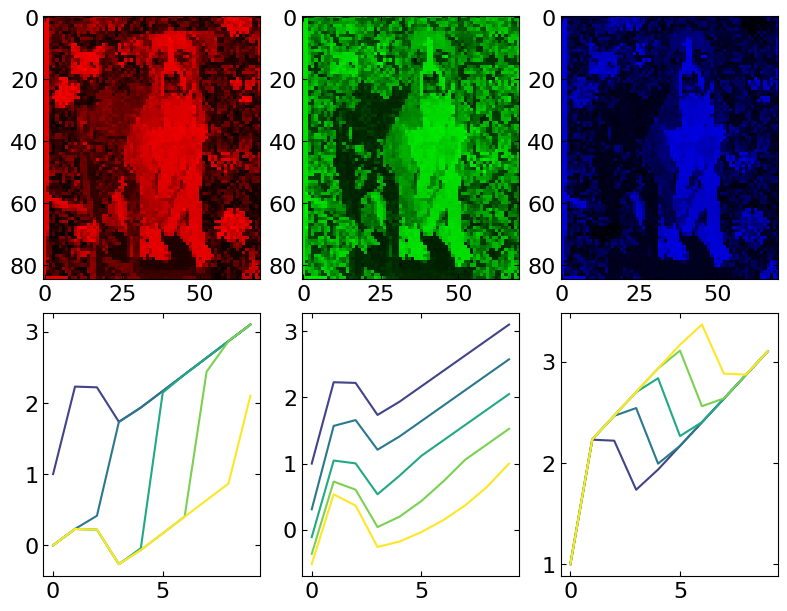

In [50]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


## Attention Mechanisms



Builds the Model


In [74]:
import torch
import torch.nn as nn
import math

latent_dim = 12
seq_len = 10

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerBlock(nn.Module):
    def __init__(self, latent_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(latent_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(latent_dim)
        self.ff = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Linear(latent_dim * 2, latent_dim)
        )
        self.norm2 = nn.LayerNorm(latent_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class Encoder(nn.Module):
    def __init__(self, latent_dim=12, num_layers=3):
        super(Encoder, self).__init__()
        self.input_proj = nn.Linear(1, latent_dim)
        self.pos_encoder = PositionalEncoding(latent_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(latent_dim, num_heads=2) for _ in range(num_layers)
        ])
        self.embedding = nn.Linear(latent_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input_proj(x)           # (B, T, latent_dim)
        x = self.pos_encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = x[:, -1, :]                  # Use final token
        x = self.relu(self.embedding(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=12, seq_len=10, num_layers=3):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.expand = nn.Linear(latent_dim, latent_dim * seq_len)
        self.pos_encoder = PositionalEncoding(latent_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(latent_dim, num_heads=2) for _ in range(num_layers)
        ])
        self.output_proj = nn.Sequential(
            nn.Conv1d(latent_dim, 1, kernel_size=1),
        )

    def forward(self, x):
        x = self.expand(x).view(x.size(0), self.seq_len, -1)
        x = self.pos_encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = x.transpose(1, 2)
        x = self.output_proj(x)
        x = x.transpose(1, 2)
        return x


In [75]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [76]:
model


Autoencoder(
  (encoder): Encoder(
    (input_proj): Linear(in_features=1, out_features=12, bias=True)
    (pos_encoder): PositionalEncoding()
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (ff): Sequential(
          (0): Linear(in_features=12, out_features=24, bias=True)
          (1): ReLU()
          (2): Linear(in_features=24, out_features=12, bias=True)
        )
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      )
    )
    (embedding): Linear(in_features=12, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (expand): Linear(in_features=12, out_features=120, bias=True)
    (pos_encoder): PositionalEncoding()
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
    

### Dataloader


In [77]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [78]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-4, # adds a regularization term l1
    mse=False,
    device=device,
)


100%|██████████| 19/19 [00:00<00:00, 46.60it/s]


Epoch 0, Train Loss: 1.8680
.............................


100%|██████████| 19/19 [00:00<00:00, 47.71it/s]


Epoch 1, Train Loss: 1.8179
.............................


100%|██████████| 19/19 [00:00<00:00, 47.75it/s]


Epoch 2, Train Loss: 1.7705
.............................


100%|██████████| 19/19 [00:00<00:00, 47.36it/s]


Epoch 3, Train Loss: 1.7337
.............................


100%|██████████| 19/19 [00:00<00:00, 47.99it/s]


Epoch 4, Train Loss: 1.7044
.............................


100%|██████████| 19/19 [00:00<00:00, 48.41it/s]


Epoch 5, Train Loss: 1.6756
.............................


100%|██████████| 19/19 [00:00<00:00, 46.06it/s]


Epoch 6, Train Loss: 1.6478
.............................


100%|██████████| 19/19 [00:00<00:00, 48.07it/s]


Epoch 7, Train Loss: 1.6200
.............................


100%|██████████| 19/19 [00:00<00:00, 45.92it/s]


Epoch 8, Train Loss: 1.5910
.............................


100%|██████████| 19/19 [00:00<00:00, 47.68it/s]


Epoch 9, Train Loss: 1.5601
.............................


100%|██████████| 19/19 [00:00<00:00, 45.40it/s]


Epoch 10, Train Loss: 1.5263
.............................


100%|██████████| 19/19 [00:00<00:00, 30.78it/s]


Epoch 11, Train Loss: 1.4890
.............................


100%|██████████| 19/19 [00:00<00:00, 32.79it/s]


Epoch 12, Train Loss: 1.4478
.............................


100%|██████████| 19/19 [00:00<00:00, 31.20it/s]


Epoch 13, Train Loss: 1.4028
.............................


100%|██████████| 19/19 [00:00<00:00, 36.37it/s]


Epoch 14, Train Loss: 1.3537
.............................


100%|██████████| 19/19 [00:00<00:00, 47.21it/s]


Epoch 15, Train Loss: 1.3011
.............................


100%|██████████| 19/19 [00:00<00:00, 43.01it/s]


Epoch 16, Train Loss: 1.2458
.............................


100%|██████████| 19/19 [00:00<00:00, 46.29it/s]


Epoch 17, Train Loss: 1.1894
.............................


100%|██████████| 19/19 [00:00<00:00, 47.52it/s]


Epoch 18, Train Loss: 1.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 45.08it/s]


Epoch 19, Train Loss: 1.0783
.............................


100%|██████████| 19/19 [00:00<00:00, 47.59it/s]


Epoch 20, Train Loss: 1.0249
.............................


100%|██████████| 19/19 [00:00<00:00, 45.37it/s]


Epoch 21, Train Loss: 0.9741
.............................


100%|██████████| 19/19 [00:00<00:00, 48.07it/s]


Epoch 22, Train Loss: 0.9260
.............................


100%|██████████| 19/19 [00:00<00:00, 47.46it/s]


Epoch 23, Train Loss: 0.8803
.............................


100%|██████████| 19/19 [00:00<00:00, 45.33it/s]


Epoch 24, Train Loss: 0.8371
.............................


100%|██████████| 19/19 [00:00<00:00, 49.05it/s]


Epoch 25, Train Loss: 0.7964
.............................


100%|██████████| 19/19 [00:00<00:00, 41.71it/s]


Epoch 26, Train Loss: 0.7582
.............................


100%|██████████| 19/19 [00:00<00:00, 44.90it/s]


Epoch 27, Train Loss: 0.7223
.............................


100%|██████████| 19/19 [00:00<00:00, 46.97it/s]


Epoch 28, Train Loss: 0.6883
.............................


100%|██████████| 19/19 [00:00<00:00, 45.90it/s]


Epoch 29, Train Loss: 0.6558
.............................


100%|██████████| 19/19 [00:00<00:00, 49.40it/s]


Epoch 30, Train Loss: 0.6251
.............................


100%|██████████| 19/19 [00:00<00:00, 46.69it/s]


Epoch 31, Train Loss: 0.5960
.............................


100%|██████████| 19/19 [00:00<00:00, 48.99it/s]


Epoch 32, Train Loss: 0.5685
.............................


100%|██████████| 19/19 [00:00<00:00, 47.56it/s]


Epoch 33, Train Loss: 0.5423
.............................


100%|██████████| 19/19 [00:00<00:00, 46.68it/s]


Epoch 34, Train Loss: 0.5174
.............................


100%|██████████| 19/19 [00:00<00:00, 48.59it/s]


Epoch 35, Train Loss: 0.4935
.............................


100%|██████████| 19/19 [00:00<00:00, 45.76it/s]


Epoch 36, Train Loss: 0.4706
.............................


100%|██████████| 19/19 [00:00<00:00, 49.36it/s]


Epoch 37, Train Loss: 0.4488
.............................


100%|██████████| 19/19 [00:00<00:00, 40.36it/s]


Epoch 38, Train Loss: 0.4282
.............................


100%|██████████| 19/19 [00:00<00:00, 33.32it/s]


Epoch 39, Train Loss: 0.4089
.............................


100%|██████████| 19/19 [00:00<00:00, 35.29it/s]


Epoch 40, Train Loss: 0.3907
.............................


100%|██████████| 19/19 [00:00<00:00, 29.94it/s]


Epoch 41, Train Loss: 0.3738
.............................


100%|██████████| 19/19 [00:00<00:00, 38.34it/s]


Epoch 42, Train Loss: 0.3582
.............................


100%|██████████| 19/19 [00:00<00:00, 46.26it/s]


Epoch 43, Train Loss: 0.3435
.............................


100%|██████████| 19/19 [00:00<00:00, 47.69it/s]


Epoch 44, Train Loss: 0.3298
.............................


100%|██████████| 19/19 [00:00<00:00, 46.90it/s]


Epoch 45, Train Loss: 0.3171
.............................


100%|██████████| 19/19 [00:00<00:00, 47.73it/s]


Epoch 46, Train Loss: 0.3054
.............................


100%|██████████| 19/19 [00:00<00:00, 46.19it/s]


Epoch 47, Train Loss: 0.2945
.............................


100%|██████████| 19/19 [00:00<00:00, 47.45it/s]


Epoch 48, Train Loss: 0.2843
.............................


100%|██████████| 19/19 [00:00<00:00, 47.14it/s]


Epoch 49, Train Loss: 0.2750
.............................


100%|██████████| 19/19 [00:00<00:00, 44.67it/s]


Epoch 50, Train Loss: 0.2663
.............................


100%|██████████| 19/19 [00:00<00:00, 47.05it/s]


Epoch 51, Train Loss: 0.2582
.............................


100%|██████████| 19/19 [00:00<00:00, 46.10it/s]


Epoch 52, Train Loss: 0.2507
.............................


100%|██████████| 19/19 [00:00<00:00, 48.31it/s]


Epoch 53, Train Loss: 0.2437
.............................


100%|██████████| 19/19 [00:00<00:00, 47.24it/s]


Epoch 54, Train Loss: 0.2372
.............................


100%|██████████| 19/19 [00:00<00:00, 47.35it/s]


Epoch 55, Train Loss: 0.2311
.............................


100%|██████████| 19/19 [00:00<00:00, 49.20it/s]


Epoch 56, Train Loss: 0.2255
.............................


100%|██████████| 19/19 [00:00<00:00, 48.90it/s]


Epoch 57, Train Loss: 0.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 46.79it/s]


Epoch 58, Train Loss: 0.2154
.............................


100%|██████████| 19/19 [00:00<00:00, 47.77it/s]


Epoch 59, Train Loss: 0.2108
.............................


100%|██████████| 19/19 [00:00<00:00, 46.32it/s]


Epoch 60, Train Loss: 0.2066
.............................


100%|██████████| 19/19 [00:00<00:00, 47.33it/s]


Epoch 61, Train Loss: 0.2026
.............................


100%|██████████| 19/19 [00:00<00:00, 48.06it/s]


Epoch 62, Train Loss: 0.1989
.............................


100%|██████████| 19/19 [00:00<00:00, 45.72it/s]


Epoch 63, Train Loss: 0.1954
.............................


100%|██████████| 19/19 [00:00<00:00, 47.92it/s]


Epoch 64, Train Loss: 0.1921
.............................


100%|██████████| 19/19 [00:00<00:00, 47.61it/s]


Epoch 65, Train Loss: 0.1890
.............................


100%|██████████| 19/19 [00:00<00:00, 41.52it/s]


Epoch 66, Train Loss: 0.1860
.............................


100%|██████████| 19/19 [00:00<00:00, 33.80it/s]


Epoch 67, Train Loss: 0.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 35.39it/s]


Epoch 68, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 29.82it/s]


Epoch 69, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 37.68it/s]


Epoch 70, Train Loss: 0.1756
.............................


100%|██████████| 19/19 [00:00<00:00, 44.86it/s]


Epoch 71, Train Loss: 0.1733
.............................


100%|██████████| 19/19 [00:00<00:00, 47.60it/s]


Epoch 72, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 47.24it/s]


Epoch 73, Train Loss: 0.1691
.............................


100%|██████████| 19/19 [00:00<00:00, 45.42it/s]


Epoch 74, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 47.69it/s]


Epoch 75, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 33.67it/s]


Epoch 76, Train Loss: 0.1637
.............................


100%|██████████| 19/19 [00:00<00:00, 34.06it/s]


Epoch 77, Train Loss: 0.1621
.............................


100%|██████████| 19/19 [00:00<00:00, 33.02it/s]


Epoch 78, Train Loss: 0.1606
.............................


100%|██████████| 19/19 [00:00<00:00, 30.10it/s]


Epoch 79, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 44.33it/s]


Epoch 80, Train Loss: 0.1577
.............................


100%|██████████| 19/19 [00:00<00:00, 48.24it/s]


Epoch 81, Train Loss: 0.1564
.............................


100%|██████████| 19/19 [00:00<00:00, 48.17it/s]


Epoch 82, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 47.13it/s]


Epoch 83, Train Loss: 0.1539
.............................


100%|██████████| 19/19 [00:00<00:00, 48.96it/s]


Epoch 84, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 47.29it/s]


Epoch 85, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 48.05it/s]


Epoch 86, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 48.29it/s]


Epoch 87, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 46.41it/s]


Epoch 88, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 47.97it/s]


Epoch 89, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 45.88it/s]


Epoch 90, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 47.62it/s]


Epoch 91, Train Loss: 0.1462
.............................


100%|██████████| 19/19 [00:00<00:00, 27.36it/s]


Epoch 92, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 19.70it/s]


Epoch 93, Train Loss: 0.1446
.............................


100%|██████████| 19/19 [00:00<00:00, 33.73it/s]


Epoch 94, Train Loss: 0.1439
.............................


100%|██████████| 19/19 [00:00<00:00, 31.55it/s]


Epoch 95, Train Loss: 0.1432
.............................


100%|██████████| 19/19 [00:00<00:00, 47.72it/s]


Epoch 96, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 46.97it/s]


Epoch 97, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 46.98it/s]


Epoch 98, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 47.94it/s]


Epoch 99, Train Loss: 0.1406
.............................


100%|██████████| 19/19 [00:00<00:00, 46.83it/s]


Epoch 100, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 46.98it/s]


Epoch 101, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 47.70it/s]


Epoch 102, Train Loss: 0.1388
.............................


100%|██████████| 19/19 [00:00<00:00, 46.14it/s]


Epoch 103, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 47.88it/s]


Epoch 104, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 46.44it/s]


Epoch 105, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 48.14it/s]


Epoch 106, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 47.85it/s]


Epoch 107, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 46.32it/s]


Epoch 108, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 47.59it/s]


Epoch 109, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 45.78it/s]


Epoch 110, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 48.23it/s]


Epoch 111, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 48.22it/s]


Epoch 112, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 45.70it/s]


Epoch 113, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 47.43it/s]


Epoch 114, Train Loss: 0.1323
.............................


100%|██████████| 19/19 [00:00<00:00, 46.44it/s]


Epoch 115, Train Loss: 0.1318
.............................


100%|██████████| 19/19 [00:00<00:00, 46.99it/s]


Epoch 116, Train Loss: 0.1313
.............................


100%|██████████| 19/19 [00:00<00:00, 48.25it/s]


Epoch 117, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 45.17it/s]


Epoch 118, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 47.53it/s]


Epoch 119, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 32.90it/s]


Epoch 120, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 35.10it/s]


Epoch 121, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 32.06it/s]


Epoch 122, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 32.30it/s]


Epoch 123, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 46.60it/s]


Epoch 124, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 48.49it/s]


Epoch 125, Train Loss: 0.1271
.............................


100%|██████████| 19/19 [00:00<00:00, 46.01it/s]


Epoch 126, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 47.47it/s]


Epoch 127, Train Loss: 0.1261
.............................


100%|██████████| 19/19 [00:00<00:00, 47.81it/s]


Epoch 128, Train Loss: 0.1257
.............................


100%|██████████| 19/19 [00:00<00:00, 46.20it/s]


Epoch 129, Train Loss: 0.1252
.............................


100%|██████████| 19/19 [00:00<00:00, 47.51it/s]


Epoch 130, Train Loss: 0.1247
.............................


100%|██████████| 19/19 [00:00<00:00, 46.00it/s]


Epoch 131, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 48.02it/s]


Epoch 132, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 47.79it/s]


Epoch 133, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 45.81it/s]


Epoch 134, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 47.65it/s]


Epoch 135, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 45.12it/s]


Epoch 136, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 48.23it/s]


Epoch 137, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 48.94it/s]


Epoch 138, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 45.81it/s]


Epoch 139, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 48.30it/s]


Epoch 140, Train Loss: 0.1199
.............................


100%|██████████| 19/19 [00:00<00:00, 46.68it/s]


Epoch 141, Train Loss: 0.1194
.............................


100%|██████████| 19/19 [00:00<00:00, 47.89it/s]


Epoch 142, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 47.48it/s]


Epoch 143, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 45.52it/s]


Epoch 144, Train Loss: 0.1179
.............................


100%|██████████| 19/19 [00:00<00:00, 47.84it/s]


Epoch 145, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 43.25it/s]


Epoch 146, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 48.68it/s]


Epoch 147, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 33.24it/s]


Epoch 148, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 33.87it/s]


Epoch 149, Train Loss: 0.1151
.............................


100%|██████████| 19/19 [00:00<00:00, 33.05it/s]


Epoch 150, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 32.80it/s]


Epoch 151, Train Loss: 0.1139
.............................


100%|██████████| 19/19 [00:00<00:00, 46.18it/s]


Epoch 152, Train Loss: 0.1133
.............................


100%|██████████| 19/19 [00:00<00:00, 47.79it/s]


Epoch 153, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 47.46it/s]


Epoch 154, Train Loss: 0.1121
.............................


100%|██████████| 19/19 [00:00<00:00, 45.85it/s]


Epoch 155, Train Loss: 0.1115
.............................


100%|██████████| 19/19 [00:00<00:00, 46.70it/s]


Epoch 156, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 46.86it/s]


Epoch 157, Train Loss: 0.1102
.............................


100%|██████████| 19/19 [00:00<00:00, 47.02it/s]


Epoch 158, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 47.85it/s]


Epoch 159, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 45.06it/s]


Epoch 160, Train Loss: 0.1083
.............................


100%|██████████| 19/19 [00:00<00:00, 47.58it/s]


Epoch 161, Train Loss: 0.1076
.............................


100%|██████████| 19/19 [00:00<00:00, 43.57it/s]


Epoch 162, Train Loss: 0.1069
.............................


100%|██████████| 19/19 [00:00<00:00, 47.49it/s]


Epoch 163, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 47.09it/s]


Epoch 164, Train Loss: 0.1055
.............................


100%|██████████| 19/19 [00:00<00:00, 44.95it/s]


Epoch 165, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 46.17it/s]


Epoch 166, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 45.15it/s]


Epoch 167, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 46.79it/s]


Epoch 168, Train Loss: 0.1026
.............................


100%|██████████| 19/19 [00:00<00:00, 47.81it/s]


Epoch 169, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 46.00it/s]


Epoch 170, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 46.22it/s]


Epoch 171, Train Loss: 0.1003
.............................


100%|██████████| 19/19 [00:00<00:00, 46.50it/s]


Epoch 172, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 48.38it/s]


Epoch 173, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 48.47it/s]


Epoch 174, Train Loss: 0.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 44.66it/s]


Epoch 175, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 32.27it/s]


Epoch 176, Train Loss: 0.0963
.............................


100%|██████████| 19/19 [00:00<00:00, 33.38it/s]


Epoch 177, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 31.39it/s]


Epoch 178, Train Loss: 0.0948
.............................


100%|██████████| 19/19 [00:00<00:00, 34.63it/s]


Epoch 179, Train Loss: 0.0939
.............................


100%|██████████| 19/19 [00:00<00:00, 46.34it/s]


Epoch 180, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 44.77it/s]


Epoch 181, Train Loss: 0.0923
.............................


100%|██████████| 19/19 [00:00<00:00, 46.59it/s]


Epoch 182, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 43.96it/s]


Epoch 183, Train Loss: 0.0906
.............................


100%|██████████| 19/19 [00:00<00:00, 46.62it/s]


Epoch 184, Train Loss: 0.0898
.............................


100%|██████████| 19/19 [00:00<00:00, 46.51it/s]


Epoch 185, Train Loss: 0.0891
.............................


100%|██████████| 19/19 [00:00<00:00, 44.96it/s]


Epoch 186, Train Loss: 0.0883
.............................


100%|██████████| 19/19 [00:00<00:00, 47.27it/s]


Epoch 187, Train Loss: 0.0875
.............................


100%|██████████| 19/19 [00:00<00:00, 45.63it/s]


Epoch 188, Train Loss: 0.0868
.............................


100%|██████████| 19/19 [00:00<00:00, 47.00it/s]


Epoch 189, Train Loss: 0.0860
.............................


100%|██████████| 19/19 [00:00<00:00, 48.28it/s]


Epoch 190, Train Loss: 0.0853
.............................


100%|██████████| 19/19 [00:00<00:00, 46.07it/s]


Epoch 191, Train Loss: 0.0845
.............................


100%|██████████| 19/19 [00:00<00:00, 48.83it/s]


Epoch 192, Train Loss: 0.0838
.............................


100%|██████████| 19/19 [00:00<00:00, 45.27it/s]


Epoch 193, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 47.97it/s]


Epoch 194, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 47.74it/s]


Epoch 195, Train Loss: 0.0817
.............................


100%|██████████| 19/19 [00:00<00:00, 44.36it/s]


Epoch 196, Train Loss: 0.0810
.............................


100%|██████████| 19/19 [00:00<00:00, 47.47it/s]


Epoch 197, Train Loss: 0.0803
.............................


100%|██████████| 19/19 [00:00<00:00, 46.13it/s]


Epoch 198, Train Loss: 0.0796
.............................


100%|██████████| 19/19 [00:00<00:00, 48.35it/s]


Epoch 199, Train Loss: 0.0790
.............................


100%|██████████| 19/19 [00:00<00:00, 48.60it/s]


Epoch 200, Train Loss: 0.0783
.............................


100%|██████████| 19/19 [00:00<00:00, 45.79it/s]


Epoch 201, Train Loss: 0.0777
.............................


100%|██████████| 19/19 [00:00<00:00, 46.67it/s]


Epoch 202, Train Loss: 0.0770
.............................


100%|██████████| 19/19 [00:00<00:00, 37.77it/s]


Epoch 203, Train Loss: 0.0764
.............................


100%|██████████| 19/19 [00:00<00:00, 32.17it/s]


Epoch 204, Train Loss: 0.0758
.............................


100%|██████████| 19/19 [00:00<00:00, 32.99it/s]


Epoch 205, Train Loss: 0.0752
.............................


100%|██████████| 19/19 [00:00<00:00, 29.27it/s]


Epoch 206, Train Loss: 0.0746
.............................


100%|██████████| 19/19 [00:00<00:00, 41.71it/s]


Epoch 207, Train Loss: 0.0740
.............................


100%|██████████| 19/19 [00:00<00:00, 44.55it/s]


Epoch 208, Train Loss: 0.0734
.............................


100%|██████████| 19/19 [00:00<00:00, 43.53it/s]


Epoch 209, Train Loss: 0.0729
.............................


100%|██████████| 19/19 [00:00<00:00, 46.24it/s]


Epoch 210, Train Loss: 0.0723
.............................


100%|██████████| 19/19 [00:00<00:00, 46.50it/s]


Epoch 211, Train Loss: 0.0717
.............................


100%|██████████| 19/19 [00:00<00:00, 43.65it/s]


Epoch 212, Train Loss: 0.0711
.............................


100%|██████████| 19/19 [00:00<00:00, 45.69it/s]


Epoch 213, Train Loss: 0.0706
.............................


100%|██████████| 19/19 [00:00<00:00, 42.44it/s]


Epoch 214, Train Loss: 0.0700
.............................


100%|██████████| 19/19 [00:00<00:00, 46.14it/s]


Epoch 215, Train Loss: 0.0694
.............................


100%|██████████| 19/19 [00:00<00:00, 46.01it/s]


Epoch 216, Train Loss: 0.0689
.............................


100%|██████████| 19/19 [00:00<00:00, 47.04it/s]


Epoch 217, Train Loss: 0.0683
.............................


100%|██████████| 19/19 [00:00<00:00, 46.63it/s]


Epoch 218, Train Loss: 0.0678
.............................


100%|██████████| 19/19 [00:00<00:00, 44.46it/s]


Epoch 219, Train Loss: 0.0673
.............................


100%|██████████| 19/19 [00:00<00:00, 46.77it/s]


Epoch 220, Train Loss: 0.0668
.............................


100%|██████████| 19/19 [00:00<00:00, 45.07it/s]


Epoch 221, Train Loss: 0.0662
.............................


100%|██████████| 19/19 [00:00<00:00, 46.84it/s]


Epoch 222, Train Loss: 0.0657
.............................


100%|██████████| 19/19 [00:00<00:00, 46.98it/s]


Epoch 223, Train Loss: 0.0652
.............................


100%|██████████| 19/19 [00:00<00:00, 46.35it/s]


Epoch 224, Train Loss: 0.0647
.............................


100%|██████████| 19/19 [00:00<00:00, 47.52it/s]


Epoch 225, Train Loss: 0.0642
.............................


100%|██████████| 19/19 [00:00<00:00, 46.62it/s]


Epoch 226, Train Loss: 0.0637
.............................


100%|██████████| 19/19 [00:00<00:00, 46.55it/s]


Epoch 227, Train Loss: 0.0632
.............................


100%|██████████| 19/19 [00:00<00:00, 47.11it/s]


Epoch 228, Train Loss: 0.0627
.............................


100%|██████████| 19/19 [00:00<00:00, 44.26it/s]


Epoch 229, Train Loss: 0.0622
.............................


100%|██████████| 19/19 [00:00<00:00, 39.39it/s]


Epoch 230, Train Loss: 0.0617
.............................


100%|██████████| 19/19 [00:00<00:00, 31.96it/s]


Epoch 231, Train Loss: 0.0613
.............................


100%|██████████| 19/19 [00:00<00:00, 34.36it/s]


Epoch 232, Train Loss: 0.0608
.............................


100%|██████████| 19/19 [00:00<00:00, 30.20it/s]


Epoch 233, Train Loss: 0.0603
.............................


100%|██████████| 19/19 [00:00<00:00, 38.58it/s]


Epoch 234, Train Loss: 0.0599
.............................


100%|██████████| 19/19 [00:00<00:00, 43.76it/s]


Epoch 235, Train Loss: 0.0594
.............................


100%|██████████| 19/19 [00:00<00:00, 45.41it/s]


Epoch 236, Train Loss: 0.0590
.............................


100%|██████████| 19/19 [00:00<00:00, 44.52it/s]


Epoch 237, Train Loss: 0.0585
.............................


100%|██████████| 19/19 [00:00<00:00, 46.30it/s]


Epoch 238, Train Loss: 0.0581
.............................


100%|██████████| 19/19 [00:00<00:00, 44.78it/s]


Epoch 239, Train Loss: 0.0577
.............................


100%|██████████| 19/19 [00:00<00:00, 45.60it/s]


Epoch 240, Train Loss: 0.0572
.............................


100%|██████████| 19/19 [00:00<00:00, 48.38it/s]


Epoch 241, Train Loss: 0.0568
.............................


100%|██████████| 19/19 [00:00<00:00, 45.21it/s]


Epoch 242, Train Loss: 0.0564
.............................


100%|██████████| 19/19 [00:00<00:00, 46.99it/s]


Epoch 243, Train Loss: 0.0560
.............................


100%|██████████| 19/19 [00:00<00:00, 45.09it/s]


Epoch 244, Train Loss: 0.0556
.............................


100%|██████████| 19/19 [00:00<00:00, 46.56it/s]


Epoch 245, Train Loss: 0.0552
.............................


100%|██████████| 19/19 [00:00<00:00, 47.17it/s]


Epoch 246, Train Loss: 0.0548
.............................


100%|██████████| 19/19 [00:00<00:00, 45.24it/s]


Epoch 247, Train Loss: 0.0544
.............................


100%|██████████| 19/19 [00:00<00:00, 47.69it/s]


Epoch 248, Train Loss: 0.0540
.............................


100%|██████████| 19/19 [00:00<00:00, 44.89it/s]


Epoch 249, Train Loss: 0.0536
.............................


100%|██████████| 19/19 [00:00<00:00, 46.76it/s]


Epoch 250, Train Loss: 0.0532
.............................


100%|██████████| 19/19 [00:00<00:00, 47.79it/s]


Epoch 251, Train Loss: 0.0528
.............................


100%|██████████| 19/19 [00:00<00:00, 43.75it/s]


Epoch 252, Train Loss: 0.0525
.............................


100%|██████████| 19/19 [00:00<00:00, 45.80it/s]


Epoch 253, Train Loss: 0.0521
.............................


100%|██████████| 19/19 [00:00<00:00, 44.44it/s]


Epoch 254, Train Loss: 0.0517
.............................


100%|██████████| 19/19 [00:00<00:00, 45.73it/s]


Epoch 255, Train Loss: 0.0514
.............................


100%|██████████| 19/19 [00:00<00:00, 45.73it/s]


Epoch 256, Train Loss: 0.0510
.............................


100%|██████████| 19/19 [00:00<00:00, 45.21it/s]


Epoch 257, Train Loss: 0.0507
.............................


100%|██████████| 19/19 [00:00<00:00, 31.24it/s]


Epoch 258, Train Loss: 0.0503
.............................


100%|██████████| 19/19 [00:00<00:00, 23.68it/s]


Epoch 259, Train Loss: 0.0500
.............................


100%|██████████| 19/19 [00:01<00:00, 17.88it/s]


Epoch 260, Train Loss: 0.0496
.............................


100%|██████████| 19/19 [00:00<00:00, 43.95it/s]


Epoch 261, Train Loss: 0.0493
.............................


100%|██████████| 19/19 [00:00<00:00, 47.02it/s]


Epoch 262, Train Loss: 0.0490
.............................


100%|██████████| 19/19 [00:00<00:00, 45.44it/s]


Epoch 263, Train Loss: 0.0487
.............................


100%|██████████| 19/19 [00:00<00:00, 45.01it/s]


Epoch 264, Train Loss: 0.0483
.............................


100%|██████████| 19/19 [00:00<00:00, 45.51it/s]


Epoch 265, Train Loss: 0.0480
.............................


100%|██████████| 19/19 [00:00<00:00, 44.63it/s]


Epoch 266, Train Loss: 0.0477
.............................


100%|██████████| 19/19 [00:00<00:00, 46.46it/s]


Epoch 267, Train Loss: 0.0474
.............................


100%|██████████| 19/19 [00:00<00:00, 45.42it/s]


Epoch 268, Train Loss: 0.0471
.............................


100%|██████████| 19/19 [00:00<00:00, 43.64it/s]


Epoch 269, Train Loss: 0.0468
.............................


100%|██████████| 19/19 [00:00<00:00, 44.66it/s]


Epoch 270, Train Loss: 0.0465
.............................


100%|██████████| 19/19 [00:00<00:00, 43.74it/s]


Epoch 271, Train Loss: 0.0462
.............................


100%|██████████| 19/19 [00:00<00:00, 46.59it/s]


Epoch 272, Train Loss: 0.0459
.............................


100%|██████████| 19/19 [00:00<00:00, 44.54it/s]


Epoch 273, Train Loss: 0.0456
.............................


100%|██████████| 19/19 [00:00<00:00, 45.48it/s]


Epoch 274, Train Loss: 0.0453
.............................


100%|██████████| 19/19 [00:00<00:00, 45.75it/s]


Epoch 275, Train Loss: 0.0450
.............................


100%|██████████| 19/19 [00:00<00:00, 44.97it/s]


Epoch 276, Train Loss: 0.0448
.............................


100%|██████████| 19/19 [00:00<00:00, 46.36it/s]


Epoch 277, Train Loss: 0.0445
.............................


100%|██████████| 19/19 [00:00<00:00, 44.13it/s]


Epoch 278, Train Loss: 0.0442
.............................


100%|██████████| 19/19 [00:00<00:00, 46.25it/s]


Epoch 279, Train Loss: 0.0440
.............................


100%|██████████| 19/19 [00:00<00:00, 42.77it/s]


Epoch 280, Train Loss: 0.0437
.............................


100%|██████████| 19/19 [00:00<00:00, 45.27it/s]


Epoch 281, Train Loss: 0.0434
.............................


100%|██████████| 19/19 [00:00<00:00, 45.96it/s]


Epoch 282, Train Loss: 0.0432
.............................


100%|██████████| 19/19 [00:00<00:00, 45.52it/s]


Epoch 283, Train Loss: 0.0429
.............................


100%|██████████| 19/19 [00:00<00:00, 34.00it/s]


Epoch 284, Train Loss: 0.0427
.............................


100%|██████████| 19/19 [00:00<00:00, 31.69it/s]


Epoch 285, Train Loss: 0.0424
.............................


100%|██████████| 19/19 [00:00<00:00, 32.10it/s]


Epoch 286, Train Loss: 0.0422
.............................


100%|██████████| 19/19 [00:00<00:00, 30.95it/s]


Epoch 287, Train Loss: 0.0419
.............................


100%|██████████| 19/19 [00:00<00:00, 45.49it/s]


Epoch 288, Train Loss: 0.0417
.............................


100%|██████████| 19/19 [00:00<00:00, 44.43it/s]


Epoch 289, Train Loss: 0.0415
.............................


100%|██████████| 19/19 [00:00<00:00, 45.75it/s]


Epoch 290, Train Loss: 0.0412
.............................


100%|██████████| 19/19 [00:00<00:00, 45.21it/s]


Epoch 291, Train Loss: 0.0410
.............................


100%|██████████| 19/19 [00:00<00:00, 46.25it/s]


Epoch 292, Train Loss: 0.0408
.............................


100%|██████████| 19/19 [00:00<00:00, 46.65it/s]


Epoch 293, Train Loss: 0.0405
.............................


100%|██████████| 19/19 [00:00<00:00, 44.11it/s]


Epoch 294, Train Loss: 0.0403
.............................


100%|██████████| 19/19 [00:00<00:00, 46.25it/s]


Epoch 295, Train Loss: 0.0401
.............................


100%|██████████| 19/19 [00:00<00:00, 44.53it/s]


Epoch 296, Train Loss: 0.0399
.............................


100%|██████████| 19/19 [00:00<00:00, 47.59it/s]


Epoch 297, Train Loss: 0.0396
.............................


100%|██████████| 19/19 [00:00<00:00, 45.86it/s]


Epoch 298, Train Loss: 0.0394
.............................


100%|██████████| 19/19 [00:00<00:00, 44.44it/s]


Epoch 299, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 46.46it/s]


Epoch 300, Train Loss: 0.0390
.............................


100%|██████████| 19/19 [00:00<00:00, 43.73it/s]


Epoch 301, Train Loss: 0.0388
.............................


100%|██████████| 19/19 [00:00<00:00, 46.64it/s]


Epoch 302, Train Loss: 0.0386
.............................


100%|██████████| 19/19 [00:00<00:00, 44.30it/s]


Epoch 303, Train Loss: 0.0384
.............................


100%|██████████| 19/19 [00:00<00:00, 45.92it/s]


Epoch 304, Train Loss: 0.0382
.............................


100%|██████████| 19/19 [00:00<00:00, 46.43it/s]


Epoch 305, Train Loss: 0.0380
.............................


100%|██████████| 19/19 [00:00<00:00, 44.46it/s]


Epoch 306, Train Loss: 0.0377
.............................


100%|██████████| 19/19 [00:00<00:00, 45.69it/s]


Epoch 307, Train Loss: 0.0376
.............................


100%|██████████| 19/19 [00:00<00:00, 43.95it/s]


Epoch 308, Train Loss: 0.0374
.............................


100%|██████████| 19/19 [00:00<00:00, 46.63it/s]


Epoch 309, Train Loss: 0.0372
.............................


100%|██████████| 19/19 [00:00<00:00, 47.70it/s]


Epoch 310, Train Loss: 0.0370
.............................


100%|██████████| 19/19 [00:00<00:00, 32.75it/s]


Epoch 311, Train Loss: 0.0368
.............................


100%|██████████| 19/19 [00:00<00:00, 30.68it/s]


Epoch 312, Train Loss: 0.0366
.............................


100%|██████████| 19/19 [00:00<00:00, 30.44it/s]


Epoch 313, Train Loss: 0.0364
.............................


100%|██████████| 19/19 [00:00<00:00, 32.16it/s]


Epoch 314, Train Loss: 0.0362
.............................


100%|██████████| 19/19 [00:00<00:00, 45.30it/s]


Epoch 315, Train Loss: 0.0360
.............................


100%|██████████| 19/19 [00:00<00:00, 43.98it/s]


Epoch 316, Train Loss: 0.0358
.............................


100%|██████████| 19/19 [00:00<00:00, 46.03it/s]


Epoch 317, Train Loss: 0.0357
.............................


100%|██████████| 19/19 [00:00<00:00, 45.59it/s]


Epoch 318, Train Loss: 0.0355
.............................


100%|██████████| 19/19 [00:00<00:00, 43.68it/s]


Epoch 319, Train Loss: 0.0353
.............................


100%|██████████| 19/19 [00:00<00:00, 45.87it/s]


Epoch 320, Train Loss: 0.0351
.............................


100%|██████████| 19/19 [00:00<00:00, 44.21it/s]


Epoch 321, Train Loss: 0.0350
.............................


100%|██████████| 19/19 [00:00<00:00, 47.82it/s]


Epoch 322, Train Loss: 0.0348
.............................


100%|██████████| 19/19 [00:00<00:00, 46.32it/s]


Epoch 323, Train Loss: 0.0346
.............................


100%|██████████| 19/19 [00:00<00:00, 45.16it/s]


Epoch 324, Train Loss: 0.0344
.............................


100%|██████████| 19/19 [00:00<00:00, 46.55it/s]


Epoch 325, Train Loss: 0.0343
.............................


100%|██████████| 19/19 [00:00<00:00, 44.56it/s]


Epoch 326, Train Loss: 0.0341
.............................


100%|██████████| 19/19 [00:00<00:00, 47.68it/s]


Epoch 327, Train Loss: 0.0339
.............................


100%|██████████| 19/19 [00:00<00:00, 45.92it/s]


Epoch 328, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 45.03it/s]


Epoch 329, Train Loss: 0.0336
.............................


100%|██████████| 19/19 [00:00<00:00, 45.79it/s]


Epoch 330, Train Loss: 0.0334
.............................


100%|██████████| 19/19 [00:00<00:00, 45.05it/s]


Epoch 331, Train Loss: 0.0333
.............................


100%|██████████| 19/19 [00:00<00:00, 46.98it/s]


Epoch 332, Train Loss: 0.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 46.80it/s]


Epoch 333, Train Loss: 0.0330
.............................


100%|██████████| 19/19 [00:00<00:00, 46.22it/s]


Epoch 334, Train Loss: 0.0328
.............................


100%|██████████| 19/19 [00:00<00:00, 47.08it/s]


Epoch 335, Train Loss: 0.0327
.............................


100%|██████████| 19/19 [00:00<00:00, 45.32it/s]


Epoch 336, Train Loss: 0.0325
.............................


100%|██████████| 19/19 [00:00<00:00, 46.85it/s]


Epoch 337, Train Loss: 0.0323
.............................


100%|██████████| 19/19 [00:00<00:00, 33.86it/s]


Epoch 338, Train Loss: 0.0322
.............................


100%|██████████| 19/19 [00:00<00:00, 33.83it/s]


Epoch 339, Train Loss: 0.0320
.............................


100%|██████████| 19/19 [00:00<00:00, 33.16it/s]


Epoch 340, Train Loss: 0.0319
.............................


100%|██████████| 19/19 [00:00<00:00, 30.77it/s]


Epoch 341, Train Loss: 0.0318
.............................


100%|██████████| 19/19 [00:00<00:00, 45.79it/s]


Epoch 342, Train Loss: 0.0316
.............................


100%|██████████| 19/19 [00:00<00:00, 46.48it/s]


Epoch 343, Train Loss: 0.0315
.............................


100%|██████████| 19/19 [00:00<00:00, 44.65it/s]


Epoch 344, Train Loss: 0.0313
.............................


100%|██████████| 19/19 [00:00<00:00, 46.22it/s]


Epoch 345, Train Loss: 0.0312
.............................


100%|██████████| 19/19 [00:00<00:00, 42.87it/s]


Epoch 346, Train Loss: 0.0310
.............................


100%|██████████| 19/19 [00:00<00:00, 45.29it/s]


Epoch 347, Train Loss: 0.0309
.............................


100%|██████████| 19/19 [00:00<00:00, 47.02it/s]


Epoch 348, Train Loss: 0.0308
.............................


100%|██████████| 19/19 [00:00<00:00, 46.05it/s]


Epoch 349, Train Loss: 0.0306
.............................


100%|██████████| 19/19 [00:00<00:00, 46.84it/s]


Epoch 350, Train Loss: 0.0305
.............................


100%|██████████| 19/19 [00:00<00:00, 47.12it/s]


Epoch 351, Train Loss: 0.0303
.............................


100%|██████████| 19/19 [00:00<00:00, 45.48it/s]


Epoch 352, Train Loss: 0.0302
.............................


100%|██████████| 19/19 [00:00<00:00, 47.35it/s]


Epoch 353, Train Loss: 0.0301
.............................


100%|██████████| 19/19 [00:00<00:00, 46.03it/s]


Epoch 354, Train Loss: 0.0299
.............................


100%|██████████| 19/19 [00:00<00:00, 46.79it/s]


Epoch 355, Train Loss: 0.0298
.............................


100%|██████████| 19/19 [00:00<00:00, 48.10it/s]


Epoch 356, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 45.09it/s]


Epoch 357, Train Loss: 0.0296
.............................


100%|██████████| 19/19 [00:00<00:00, 47.53it/s]


Epoch 358, Train Loss: 0.0294
.............................


100%|██████████| 19/19 [00:00<00:00, 45.85it/s]


Epoch 359, Train Loss: 0.0293
.............................


100%|██████████| 19/19 [00:00<00:00, 47.30it/s]


Epoch 360, Train Loss: 0.0292
.............................


100%|██████████| 19/19 [00:00<00:00, 48.31it/s]


Epoch 361, Train Loss: 0.0291
.............................


100%|██████████| 19/19 [00:00<00:00, 46.13it/s]


Epoch 362, Train Loss: 0.0289
.............................


100%|██████████| 19/19 [00:00<00:00, 47.92it/s]


Epoch 363, Train Loss: 0.0288
.............................


100%|██████████| 19/19 [00:00<00:00, 46.95it/s]


Epoch 364, Train Loss: 0.0287
.............................


100%|██████████| 19/19 [00:00<00:00, 47.63it/s]


Epoch 365, Train Loss: 0.0286
.............................


100%|██████████| 19/19 [00:00<00:00, 32.35it/s]


Epoch 366, Train Loss: 0.0285
.............................


100%|██████████| 19/19 [00:00<00:00, 34.42it/s]


Epoch 367, Train Loss: 0.0284
.............................


100%|██████████| 19/19 [00:00<00:00, 34.29it/s]


Epoch 368, Train Loss: 0.0282
.............................


100%|██████████| 19/19 [00:00<00:00, 31.01it/s]


Epoch 369, Train Loss: 0.0281
.............................


100%|██████████| 19/19 [00:00<00:00, 45.96it/s]


Epoch 370, Train Loss: 0.0280
.............................


100%|██████████| 19/19 [00:00<00:00, 44.89it/s]


Epoch 371, Train Loss: 0.0279
.............................


100%|██████████| 19/19 [00:00<00:00, 45.13it/s]


Epoch 372, Train Loss: 0.0278
.............................


100%|██████████| 19/19 [00:00<00:00, 45.10it/s]


Epoch 373, Train Loss: 0.0277
.............................


100%|██████████| 19/19 [00:00<00:00, 46.85it/s]


Epoch 374, Train Loss: 0.0276
.............................


100%|██████████| 19/19 [00:00<00:00, 46.46it/s]


Epoch 375, Train Loss: 0.0274
.............................


100%|██████████| 19/19 [00:00<00:00, 47.65it/s]


Epoch 376, Train Loss: 0.0273
.............................


100%|██████████| 19/19 [00:00<00:00, 47.68it/s]


Epoch 377, Train Loss: 0.0272
.............................


100%|██████████| 19/19 [00:00<00:00, 45.49it/s]


Epoch 378, Train Loss: 0.0271
.............................


100%|██████████| 19/19 [00:00<00:00, 47.32it/s]


Epoch 379, Train Loss: 0.0270
.............................


100%|██████████| 19/19 [00:00<00:00, 46.18it/s]


Epoch 380, Train Loss: 0.0269
.............................


100%|██████████| 19/19 [00:00<00:00, 45.58it/s]


Epoch 381, Train Loss: 0.0268
.............................


100%|██████████| 19/19 [00:00<00:00, 46.13it/s]


Epoch 382, Train Loss: 0.0267
.............................


100%|██████████| 19/19 [00:00<00:00, 45.30it/s]


Epoch 383, Train Loss: 0.0266
.............................


100%|██████████| 19/19 [00:00<00:00, 47.21it/s]


Epoch 384, Train Loss: 0.0265
.............................


100%|██████████| 19/19 [00:00<00:00, 46.00it/s]


Epoch 385, Train Loss: 0.0264
.............................


100%|██████████| 19/19 [00:00<00:00, 44.09it/s]


Epoch 386, Train Loss: 0.0263
.............................


100%|██████████| 19/19 [00:00<00:00, 45.64it/s]


Epoch 387, Train Loss: 0.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 41.84it/s]


Epoch 388, Train Loss: 0.0261
.............................


100%|██████████| 19/19 [00:00<00:00, 44.27it/s]


Epoch 389, Train Loss: 0.0260
.............................


100%|██████████| 19/19 [00:00<00:00, 45.01it/s]


Epoch 390, Train Loss: 0.0259
.............................


100%|██████████| 19/19 [00:00<00:00, 47.11it/s]


Epoch 391, Train Loss: 0.0258
.............................


100%|██████████| 19/19 [00:00<00:00, 47.21it/s]


Epoch 392, Train Loss: 0.0257
.............................


100%|██████████| 19/19 [00:00<00:00, 39.41it/s]


Epoch 393, Train Loss: 0.0256
.............................


100%|██████████| 19/19 [00:00<00:00, 31.30it/s]


Epoch 394, Train Loss: 0.0255
.............................


100%|██████████| 19/19 [00:00<00:00, 32.09it/s]


Epoch 395, Train Loss: 0.0254
.............................


100%|██████████| 19/19 [00:00<00:00, 28.18it/s]


Epoch 396, Train Loss: 0.0253
.............................


100%|██████████| 19/19 [00:00<00:00, 43.36it/s]


Epoch 397, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 45.77it/s]


Epoch 398, Train Loss: 0.0251
.............................


100%|██████████| 19/19 [00:00<00:00, 44.61it/s]


Epoch 399, Train Loss: 0.0250
.............................


100%|██████████| 19/19 [00:00<00:00, 45.48it/s]


Epoch 400, Train Loss: 0.0249
.............................


100%|██████████| 19/19 [00:00<00:00, 44.60it/s]


Epoch 401, Train Loss: 0.0248
.............................


100%|██████████| 19/19 [00:00<00:00, 46.37it/s]


Epoch 402, Train Loss: 0.0247
.............................


100%|██████████| 19/19 [00:00<00:00, 44.56it/s]


Epoch 403, Train Loss: 0.0246
.............................


100%|██████████| 19/19 [00:00<00:00, 45.90it/s]


Epoch 404, Train Loss: 0.0245
.............................


100%|██████████| 19/19 [00:00<00:00, 46.29it/s]


Epoch 405, Train Loss: 0.0245
.............................


100%|██████████| 19/19 [00:00<00:00, 43.96it/s]


Epoch 406, Train Loss: 0.0244
.............................


100%|██████████| 19/19 [00:00<00:00, 45.63it/s]


Epoch 407, Train Loss: 0.0243
.............................


100%|██████████| 19/19 [00:00<00:00, 44.57it/s]


Epoch 408, Train Loss: 0.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 46.52it/s]


Epoch 409, Train Loss: 0.0241
.............................


100%|██████████| 19/19 [00:00<00:00, 45.90it/s]


Epoch 410, Train Loss: 0.0240
.............................


100%|██████████| 19/19 [00:00<00:00, 43.48it/s]


Epoch 411, Train Loss: 0.0239
.............................


100%|██████████| 19/19 [00:00<00:00, 45.68it/s]


Epoch 412, Train Loss: 0.0238
.............................


100%|██████████| 19/19 [00:00<00:00, 44.58it/s]


Epoch 413, Train Loss: 0.0238
.............................


100%|██████████| 19/19 [00:00<00:00, 46.68it/s]


Epoch 414, Train Loss: 0.0237
.............................


100%|██████████| 19/19 [00:00<00:00, 44.63it/s]


Epoch 415, Train Loss: 0.0236
.............................


100%|██████████| 19/19 [00:00<00:00, 44.63it/s]


Epoch 416, Train Loss: 0.0235
.............................


100%|██████████| 19/19 [00:00<00:00, 46.62it/s]


Epoch 417, Train Loss: 0.0234
.............................


100%|██████████| 19/19 [00:00<00:00, 44.50it/s]


Epoch 418, Train Loss: 0.0233
.............................


100%|██████████| 19/19 [00:00<00:00, 47.37it/s]


Epoch 419, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch 420, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 32.45it/s]


Epoch 421, Train Loss: 0.0231
.............................


100%|██████████| 19/19 [00:00<00:00, 33.69it/s]


Epoch 422, Train Loss: 0.0230
.............................


100%|██████████| 19/19 [00:00<00:00, 29.07it/s]


Epoch 423, Train Loss: 0.0229
.............................


100%|██████████| 19/19 [00:00<00:00, 40.03it/s]


Epoch 424, Train Loss: 0.0228
.............................


100%|██████████| 19/19 [00:00<00:00, 46.91it/s]


Epoch 425, Train Loss: 0.0228
.............................


100%|██████████| 19/19 [00:00<00:00, 45.03it/s]


Epoch 426, Train Loss: 0.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 47.62it/s]


Epoch 427, Train Loss: 0.0226
.............................


100%|██████████| 19/19 [00:00<00:00, 46.74it/s]


Epoch 428, Train Loss: 0.0225
.............................


100%|██████████| 19/19 [00:00<00:00, 44.70it/s]


Epoch 429, Train Loss: 0.0224
.............................


100%|██████████| 19/19 [00:00<00:00, 47.84it/s]


Epoch 430, Train Loss: 0.0224
.............................


100%|██████████| 19/19 [00:00<00:00, 44.07it/s]


Epoch 431, Train Loss: 0.0223
.............................


100%|██████████| 19/19 [00:00<00:00, 47.67it/s]


Epoch 432, Train Loss: 0.0222
.............................


100%|██████████| 19/19 [00:00<00:00, 45.37it/s]


Epoch 433, Train Loss: 0.0221
.............................


100%|██████████| 19/19 [00:00<00:00, 44.83it/s]


Epoch 434, Train Loss: 0.0221
.............................


100%|██████████| 19/19 [00:00<00:00, 45.73it/s]


Epoch 435, Train Loss: 0.0220
.............................


100%|██████████| 19/19 [00:00<00:00, 43.89it/s]


Epoch 436, Train Loss: 0.0219
.............................


100%|██████████| 19/19 [00:00<00:00, 46.12it/s]


Epoch 437, Train Loss: 0.0219
.............................


100%|██████████| 19/19 [00:00<00:00, 46.91it/s]


Epoch 438, Train Loss: 0.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 45.72it/s]


Epoch 439, Train Loss: 0.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 44.94it/s]


Epoch 440, Train Loss: 0.0216
.............................


100%|██████████| 19/19 [00:00<00:00, 44.01it/s]


Epoch 441, Train Loss: 0.0216
.............................


100%|██████████| 19/19 [00:00<00:00, 46.11it/s]


Epoch 442, Train Loss: 0.0215
.............................


100%|██████████| 19/19 [00:00<00:00, 43.42it/s]


Epoch 443, Train Loss: 0.0214
.............................


100%|██████████| 19/19 [00:00<00:00, 45.24it/s]


Epoch 444, Train Loss: 0.0214
.............................


100%|██████████| 19/19 [00:00<00:00, 46.21it/s]


Epoch 445, Train Loss: 0.0213
.............................


100%|██████████| 19/19 [00:00<00:00, 44.97it/s]


Epoch 446, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 41.01it/s]


Epoch 447, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 30.53it/s]


Epoch 448, Train Loss: 0.0211
.............................


100%|██████████| 19/19 [00:00<00:00, 33.20it/s]


Epoch 449, Train Loss: 0.0210
.............................


100%|██████████| 19/19 [00:00<00:00, 29.48it/s]


Epoch 450, Train Loss: 0.0210
.............................


100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch 451, Train Loss: 0.0209
.............................


100%|██████████| 19/19 [00:00<00:00, 30.81it/s]


Epoch 452, Train Loss: 0.0209
.............................


100%|██████████| 19/19 [00:00<00:00, 32.94it/s]


Epoch 453, Train Loss: 0.0208
.............................


100%|██████████| 19/19 [00:00<00:00, 33.62it/s]


Epoch 454, Train Loss: 0.0207
.............................


100%|██████████| 19/19 [00:00<00:00, 30.37it/s]


Epoch 455, Train Loss: 0.0207
.............................


100%|██████████| 19/19 [00:00<00:00, 46.55it/s]


Epoch 456, Train Loss: 0.0206
.............................


100%|██████████| 19/19 [00:00<00:00, 45.23it/s]


Epoch 457, Train Loss: 0.0205
.............................


100%|██████████| 19/19 [00:00<00:00, 45.77it/s]


Epoch 458, Train Loss: 0.0205
.............................


100%|██████████| 19/19 [00:00<00:00, 46.75it/s]


Epoch 459, Train Loss: 0.0204
.............................


100%|██████████| 19/19 [00:00<00:00, 44.64it/s]


Epoch 460, Train Loss: 0.0204
.............................


100%|██████████| 19/19 [00:00<00:00, 47.01it/s]


Epoch 461, Train Loss: 0.0203
.............................


100%|██████████| 19/19 [00:00<00:00, 45.13it/s]


Epoch 462, Train Loss: 0.0202
.............................


100%|██████████| 19/19 [00:00<00:00, 46.30it/s]


Epoch 463, Train Loss: 0.0202
.............................


100%|██████████| 19/19 [00:00<00:00, 47.06it/s]


Epoch 464, Train Loss: 0.0201
.............................


100%|██████████| 19/19 [00:00<00:00, 45.09it/s]


Epoch 465, Train Loss: 0.0201
.............................


100%|██████████| 19/19 [00:00<00:00, 46.91it/s]


Epoch 466, Train Loss: 0.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 45.17it/s]


Epoch 467, Train Loss: 0.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 45.65it/s]


Epoch 468, Train Loss: 0.0199
.............................


100%|██████████| 19/19 [00:00<00:00, 46.95it/s]


Epoch 469, Train Loss: 0.0198
.............................


100%|██████████| 19/19 [00:00<00:00, 42.75it/s]


Epoch 470, Train Loss: 0.0198
.............................


100%|██████████| 19/19 [00:00<00:00, 44.88it/s]


Epoch 471, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 45.05it/s]


Epoch 472, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 33.26it/s]


Epoch 473, Train Loss: 0.0196
.............................


100%|██████████| 19/19 [00:00<00:00, 33.29it/s]


Epoch 474, Train Loss: 0.0196
.............................


100%|██████████| 19/19 [00:00<00:00, 33.91it/s]


Epoch 475, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 28.32it/s]


Epoch 476, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 44.27it/s]


Epoch 477, Train Loss: 0.0194
.............................


100%|██████████| 19/19 [00:00<00:00, 43.58it/s]


Epoch 478, Train Loss: 0.0194
.............................


100%|██████████| 19/19 [00:00<00:00, 44.24it/s]


Epoch 479, Train Loss: 0.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 45.46it/s]


Epoch 480, Train Loss: 0.0192
.............................


100%|██████████| 19/19 [00:00<00:00, 47.30it/s]


Epoch 481, Train Loss: 0.0192
.............................


100%|██████████| 19/19 [00:00<00:00, 45.72it/s]


Epoch 482, Train Loss: 0.0191
.............................


100%|██████████| 19/19 [00:00<00:00, 45.75it/s]


Epoch 483, Train Loss: 0.0191
.............................


100%|██████████| 19/19 [00:00<00:00, 46.77it/s]


Epoch 484, Train Loss: 0.0190
.............................


100%|██████████| 19/19 [00:00<00:00, 46.41it/s]


Epoch 485, Train Loss: 0.0190
.............................


100%|██████████| 19/19 [00:00<00:00, 48.11it/s]


Epoch 486, Train Loss: 0.0189
.............................


100%|██████████| 19/19 [00:00<00:00, 48.10it/s]


Epoch 487, Train Loss: 0.0189
.............................


100%|██████████| 19/19 [00:00<00:00, 45.45it/s]


Epoch 488, Train Loss: 0.0188
.............................


100%|██████████| 19/19 [00:00<00:00, 46.14it/s]


Epoch 489, Train Loss: 0.0188
.............................


100%|██████████| 19/19 [00:00<00:00, 46.55it/s]


Epoch 490, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 49.05it/s]


Epoch 491, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 45.47it/s]


Epoch 492, Train Loss: 0.0186
.............................


100%|██████████| 19/19 [00:00<00:00, 44.82it/s]


Epoch 493, Train Loss: 0.0186
.............................


100%|██████████| 19/19 [00:00<00:00, 46.76it/s]


Epoch 494, Train Loss: 0.0185
.............................


100%|██████████| 19/19 [00:00<00:00, 44.58it/s]


Epoch 495, Train Loss: 0.0185
.............................


100%|██████████| 19/19 [00:00<00:00, 47.00it/s]


Epoch 496, Train Loss: 0.0184
.............................


100%|██████████| 19/19 [00:00<00:00, 45.76it/s]


Epoch 497, Train Loss: 0.0184
.............................


100%|██████████| 19/19 [00:00<00:00, 43.45it/s]


Epoch 498, Train Loss: 0.0183
.............................


100%|██████████| 19/19 [00:00<00:00, 45.45it/s]

Epoch 499, Train Loss: 0.0183
.............................


### Validation


In [79]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


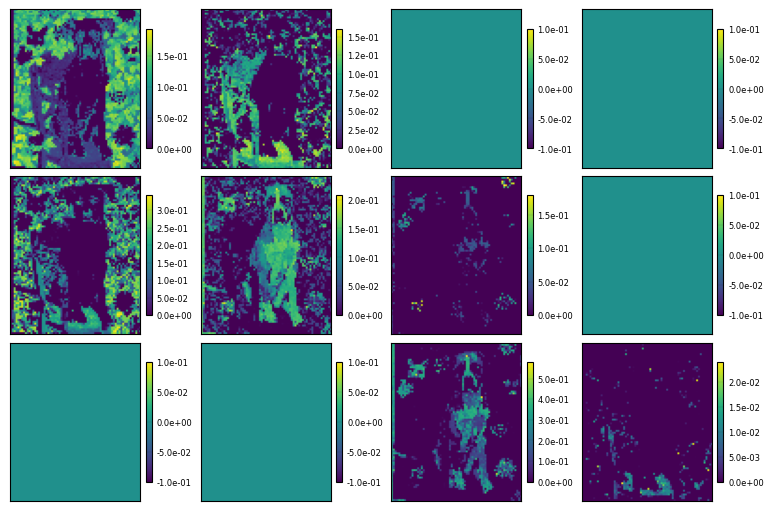

In [80]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


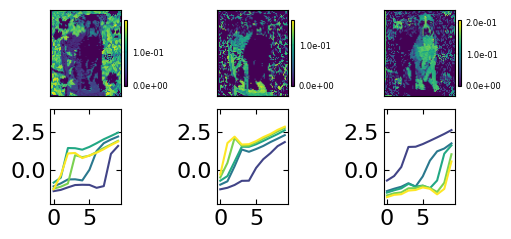

In [81]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[0, 1, 5])


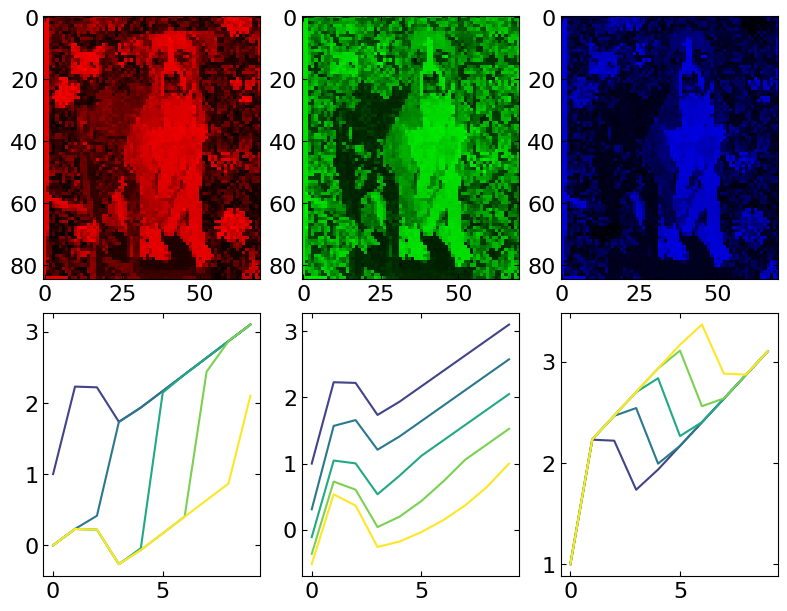

In [82]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)
